In [3]:
import os
import librosa
import numpy as np
import pandas as pd

def load_reference_file(reference_path):
    """Load the reference CSV file containing labels."""
    try:
        reference_df = pd.read_csv(reference_path, header=None)
        reference_df.columns = ['filename', 'label']
        reference_df['filename'] += '.wav'  # Ensure filenames match
        reference_df.set_index('filename', inplace=True)
        return reference_df
    except Exception as e:
        raise FileNotFoundError(f"Could not read reference CSV: {e}")

def extract_mfcc_features(file_path, fixed_length=130):
    """Extract MFCC features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        # Padding or truncating MFCCs to the fixed length
        if mfcc.shape[1] < fixed_length:
            padding = fixed_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_length]
        
        return mfcc.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def read_audio_files(data_path, reference_df, fixed_length=130):
    """Process audio files to extract MFCCs and their corresponding labels."""
    mfccs = []
    labels = []
    
    # Get sorted list of files
    file_list = sorted(os.listdir(data_path))
    
    for file in file_list:
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            print(f"Processing file: {file_path}")  # Debugging line
            
            mfcc = extract_mfcc_features(file_path, fixed_length)
            if mfcc is not None:
                mfccs.append(mfcc)
                
                # Fetch label from the reference file
                if file in reference_df.index:
                    label = reference_df.loc[file, 'label']
                    labels.append(label)
                else:
                    print(f"Label for {file} not found in reference.csv. Skipping.")
    
    return np.array(mfccs), np.array(labels)

def process_dataset(base_path, folders, fixed_length=130):
    """Process multiple folders to extract MFCCs and labels."""
    all_mfccs = []
    all_labels = []
    
    for folder in folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')
        
        reference_df = load_reference_file(reference_path)
        folder_mfccs, folder_labels = read_audio_files(data_path, reference_df, fixed_length)
        
        all_mfccs.extend(folder_mfccs)
        all_labels.extend(folder_labels)
    
    return np.array(all_mfccs), np.array(all_labels)


base_path = '/kaggle/input/physionet-challenge-2016'
folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']

all_mfccs, all_labels = process_dataset(base_path, folders)

print(f"Total MFCC shape: {all_mfccs.shape}, Total Labels shape: {all_labels.shape}")

np.save('mfcc_features.npy', all_mfccs)
np.save('labels.npy', all_labels)


Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0001.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0002.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0003.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0004.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0005.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0006.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0007.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0008.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0009.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0010.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0011.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0012.wav
Processing file: /kaggle/input/physionet-challenge-2016/training-a/a0013.wav

In [4]:
print(all_mfccs[1])
print(all_labels[1])

[-268.50842 -218.85402 -224.99608 ...    0.         0.         0.     ]
1


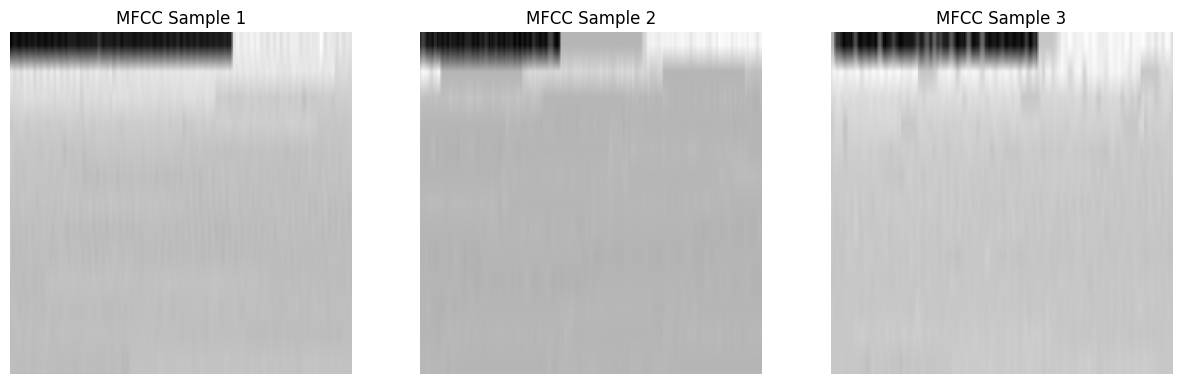

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def normalize_mfcc(mfcc):
    """Normalize MFCC values to the range [0, 255] for image representation."""
    mfcc_min = np.min(mfcc)
    mfcc_max = np.max(mfcc)
    
    if mfcc_max - mfcc_min == 0:
        
        return np.zeros_like(mfcc)
    
    return 255 * (mfcc - mfcc_min) / (mfcc_max - mfcc_min)

def mfcc_to_rgb(mfcc, target_size=(224, 224)):
    """Convert MFCC to RGB image representation."""
  
    mfcc_normalized = normalize_mfcc(mfcc)
    
   
    resized_mfcc = cv2.resize(mfcc_normalized, target_size, interpolation=cv2.INTER_LINEAR)
    
    
    rgb_image = np.stack([resized_mfcc] * 3, axis=-1).astype(np.uint8)
    
    return rgb_image

def reshape_mfcc_features(all_mfccs, n_mfcc=13):
    """Reshape the flattened MFCC features into a 3D array (samples, n_mfcc, time_steps)."""
    num_samples = all_mfccs.shape[0]
    flattened_dim = all_mfccs.shape[1]
    
    
    time_steps = flattened_dim // n_mfcc
    if flattened_dim % n_mfcc != 0:
        raise ValueError(f"Inconsistent dimensions: Cannot reshape {flattened_dim} into (13, time_steps).")
    
    return all_mfccs.reshape((num_samples, n_mfcc, time_steps))

def display_images(mfcc_features, num_images=3, target_size=(224, 224)):
    """Display a few MFCC features as RGB images."""
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        mfcc = mfcc_features[i]  # Extract individual MFCC sample
        rgb_image = mfcc_to_rgb(mfcc, target_size)
        
        # Plot the RGB image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(rgb_image)
        plt.title(f"MFCC Sample {i + 1}")
        plt.axis('off')
    
    plt.show()


try:
   
    n_mfcc = 13 
    num_samples = all_mfccs.shape[0]
    
    
    all_mfccs_reshaped = reshape_mfcc_features(all_mfccs, n_mfcc)

    display_images(all_mfccs_reshaped, num_images=3, target_size=(224, 224))

except Exception as e:
    print(f"Error processing MFCC features: {e}")


In [6]:
import os
import librosa
import numpy as np
import pandas as pd

def load_reference_file(reference_path):
    """Load and preprocess the reference CSV file."""
    try:
        reference_df = pd.read_csv(reference_path, header=None)
        reference_df.columns = ['filename', 'label']
        reference_df['filename'] += '.wav'  # Ensure '.wav' extension
        reference_df.set_index('filename', inplace=True)
    except Exception as e:
        raise FileNotFoundError(f"Could not read reference CSV: {e}")
    
    return reference_df

def extract_mel_spectrogram(file_path, fixed_length=130, n_mels=128):
    """Extract Mel Spectrogram from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        
        if mel_spec_db.shape[1] < fixed_length:
            padding = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, padding)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :fixed_length]
    except Exception as e:
        raise ValueError(f"Error processing file {file_path}: {e}")
    
    return mel_spec_db

def read_dataset_with_labels(data_path, reference_path, fixed_length=130, n_mels=128):
    """Read the dataset and extract Mel Spectrograms along with corresponding labels."""
    mel_specs = []
    labels = []
    
   
    reference_df = load_reference_file(reference_path)
    
   
    file_list = sorted(os.listdir(data_path))
    
    for file in file_list:
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            try:
                mel_spec_db = extract_mel_spectrogram(file_path, fixed_length, n_mels)
                mel_specs.append(mel_spec_db)
                
                if file in reference_df.index:
                    label = reference_df.loc[file, 'label']
                    labels.append(label)
                else:
                    print(f"Warning: Label for {file} not found. Skipping.")
            except Exception as e:
                print(f"Error with file {file}: {e}")
    
    # Ensure there are no missing Mel Spectrograms
    if not mel_specs:
        raise ValueError("No valid Mel Spectrogram data found. Please check the dataset.")

    return np.array(mel_specs), np.array(labels)

def process_all_folders(base_path, folders):
    """Process all folders, extracting Mel Spectrograms and labels."""
    all_mel_specs = []
    all_labels = []

    for folder in folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')

        try:
            folder_mel_specs, folder_labels = read_dataset_with_labels(data_path, reference_path)
            all_mel_specs.extend(folder_mel_specs)
            all_labels.extend(folder_labels)
        except Exception as e:
            print(f"Error processing folder {folder}: {e}")
    
    return np.array(all_mel_specs), np.array(all_labels)


if __name__ == "__main__":
    
    base_path = '/kaggle/input/physionet-challenge-2016'
    folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']
    
    try:
       
        all_mel_specs, all_labels = process_all_folders(base_path, folders)

        
        print(f"Total Mel Spectrogram shape: {all_mel_specs.shape}, Total Labels shape: {all_labels.shape}")

        np.save('mel_spectrogram_features.npy', all_mel_specs)
        np.save('labels.npy', all_labels)
        
    except Exception as e:
        print(f"Error during dataset processing: {e}")


Total Mel Spectrogram shape: (3240, 128, 130), Total Labels shape: (3240,)


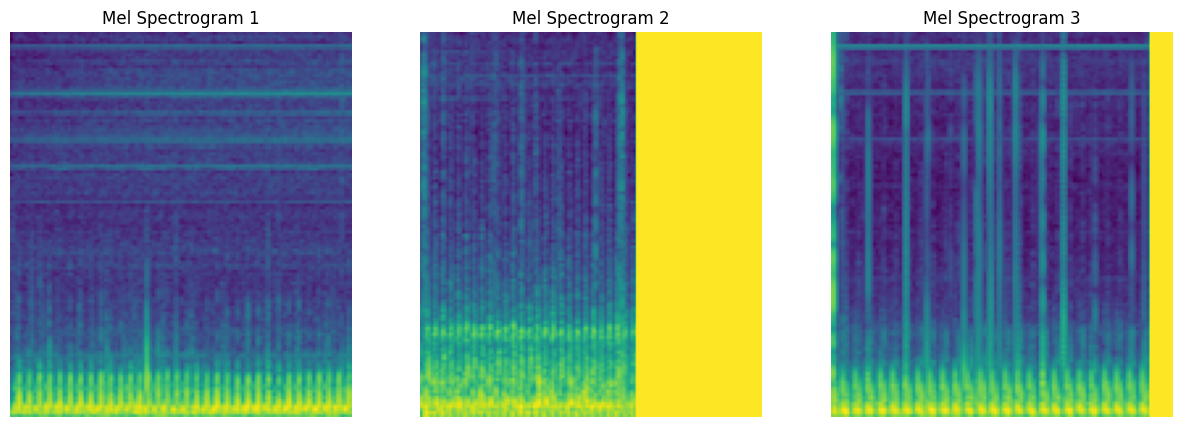

/tmp/ipykernel_30/2171209822.py:20: RuntimeWarning: invalid value encountered in log1p
  mel_spec_log = np.log1p(mel_spec)


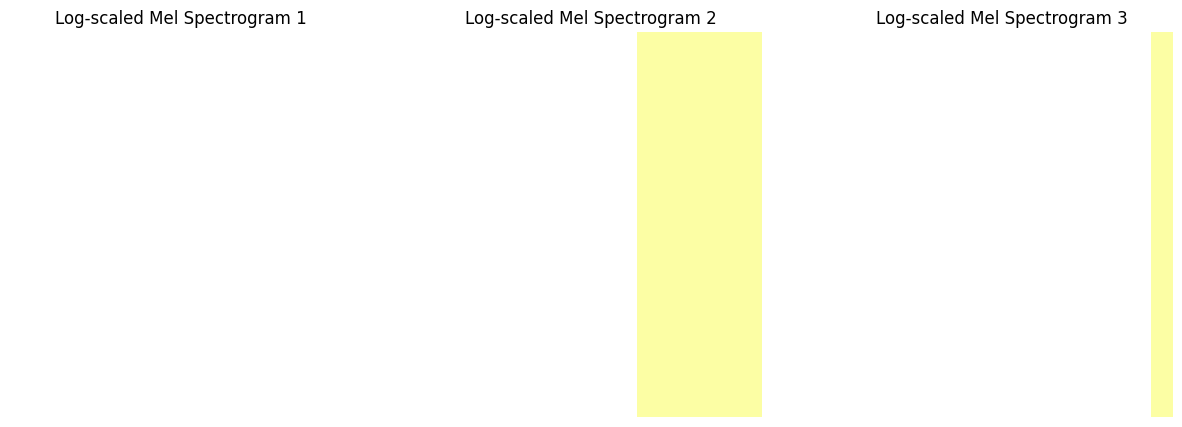

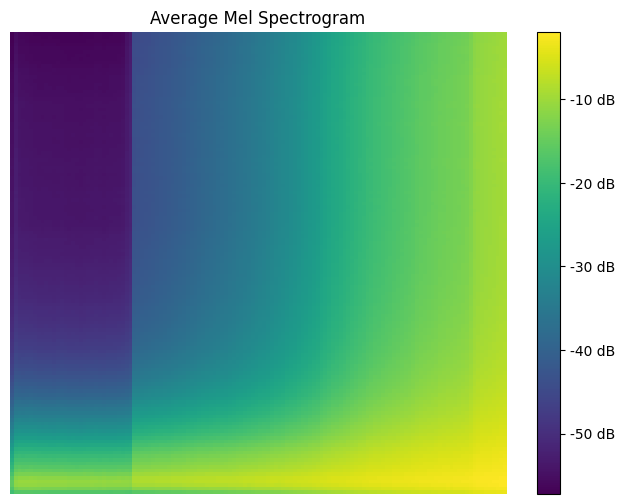

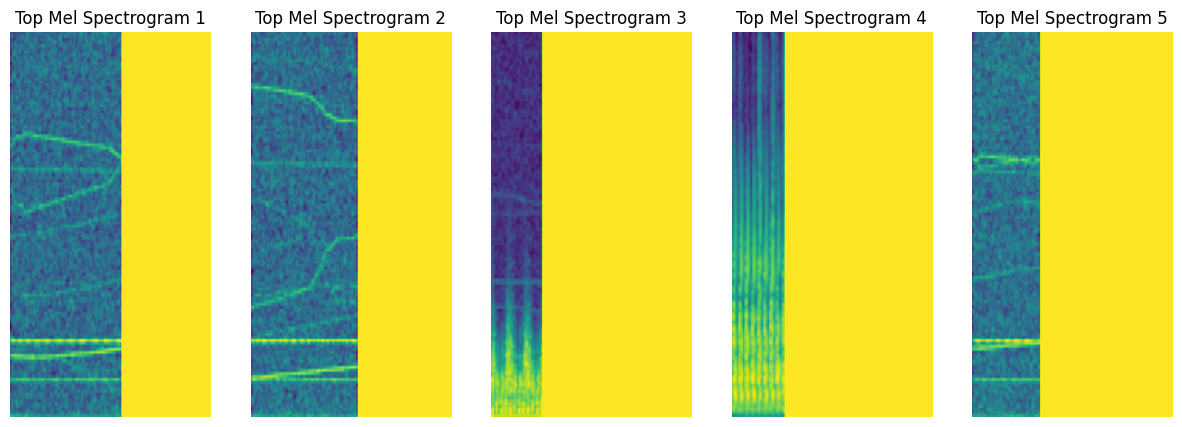

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def display_mel_spectrograms(mel_specs, num_images=3):
    """Display Mel Spectrograms with a default color map."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()

def display_log_mel_spectrograms(mel_specs, num_images=3):
    """Display Mel Spectrograms with log scaling."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        mel_spec_log = np.log1p(mel_spec) 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(mel_spec_log, aspect='auto', origin='lower', cmap='inferno')
        plt.title(f"Log-scaled Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()

def display_average_mel_spectrogram(mel_specs):
    """Display the average Mel Spectrogram across all samples."""
    avg_mel_spec = np.mean(mel_specs, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(avg_mel_spec, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Average Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.axis('off')
    plt.show()

def display_top_mel_spectrograms(mel_specs, top_n=5):
    """Display top N Mel Spectrograms based on energy."""
    energies = [np.sum(mel_spec) for mel_spec in mel_specs]  
    top_indices = np.argsort(energies)[-top_n:]  
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        mel_spec = mel_specs[idx]
        plt.subplot(1, top_n, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Top Mel Spectrogram {i + 1}")
        plt.axis('off')
    plt.show()


display_mel_spectrograms(all_mel_specs, num_images=3)


display_log_mel_spectrograms(all_mel_specs, num_images=3)


display_average_mel_spectrogram(all_mel_specs)


display_top_mel_spectrograms(all_mel_specs, top_n=5)


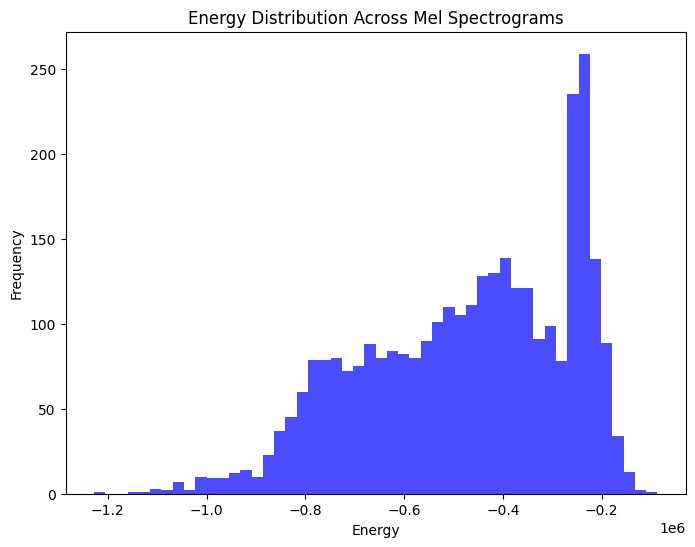

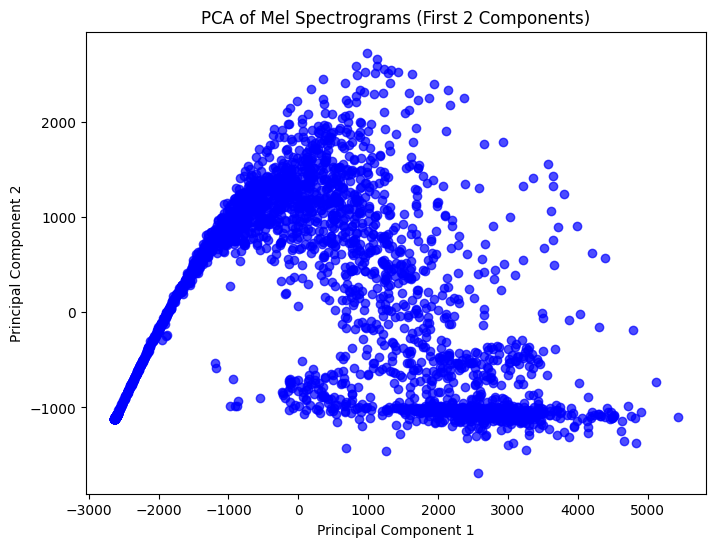

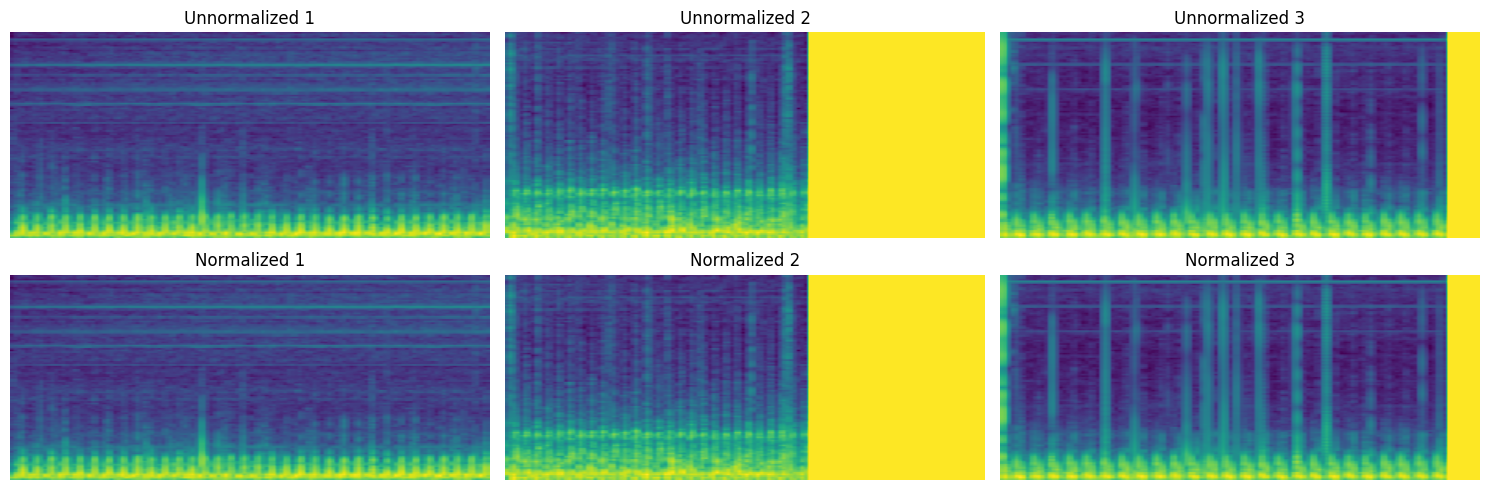

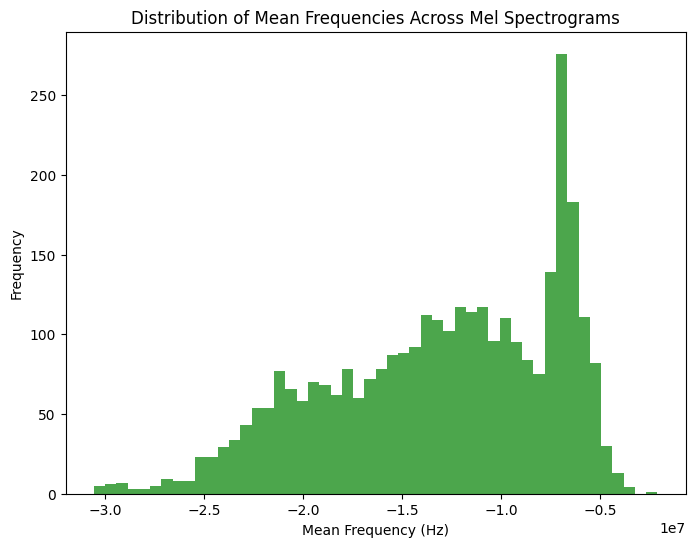

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
  
def display_energy_distribution(mel_specs):
    """Display the distribution of energy across Mel Spectrograms."""
    energies = [np.sum(mel_spec) for mel_spec in mel_specs]  # Total energy in each Mel spectrogram
    plt.figure(figsize=(8, 6))
    plt.hist(energies, bins=50, color='blue', alpha=0.7)
    plt.title("Energy Distribution Across Mel Spectrograms")
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.show()

def display_pca_mel_spectrograms(mel_specs, n_components=2):
    """Display PCA components of Mel Spectrograms."""
    mel_specs_flattened = mel_specs.reshape(mel_specs.shape[0], -1)  
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(mel_specs_flattened)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c='blue', alpha=0.7)
    plt.title(f"PCA of Mel Spectrograms (First {n_components} Components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

def display_normalized_vs_unnormalized(mel_specs, num_images=3):
    """Display comparison of normalized and unnormalized Mel Spectrograms."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        mel_spec = mel_specs[i]
        
        
        mel_spec_normalized = (mel_spec - np.min(mel_spec)) / (np.max(mel_spec) - np.min(mel_spec))
        
       
        plt.subplot(2, num_images, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Unnormalized {i + 1}")
        plt.axis('off')
        
        
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(mel_spec_normalized, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Normalized {i + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_mean_frequency_distribution(mel_specs, sr=22050):
    """Display the distribution of mean frequencies across the Mel Spectrograms."""
    mean_frequencies = []
    for mel_spec in mel_specs:
        
        freq_axis = librosa.mel_frequencies(n_mels=mel_spec.shape[0], fmin=0, fmax=sr / 2)
        
        
        weighted_frequencies = np.dot(mel_spec.T, freq_axis)  
        mean_frequency = np.mean(weighted_frequencies) 
        
        mean_frequencies.append(mean_frequency)
    
    plt.figure(figsize=(8, 6))
    plt.hist(mean_frequencies, bins=50, color='green', alpha=0.7)
    plt.title("Distribution of Mean Frequencies Across Mel Spectrograms")
    plt.xlabel("Mean Frequency (Hz)")
    plt.ylabel("Frequency")
    plt.show()




display_energy_distribution(all_mel_specs)


display_pca_mel_spectrograms(all_mel_specs)


display_normalized_vs_unnormalized(all_mel_specs, num_images=3)

display_mean_frequency_distribution(all_mel_specs)


In [9]:
import os
import librosa
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


SAMPLE_RATE = 22050
DURATION = 2 
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
FIXED_LENGTH = 87  


def load_and_preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(audio) < SAMPLE_RATE * DURATION:
        audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))
    else:
        audio = audio[:SAMPLE_RATE * DURATION]
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
    return mel_spec_db


def augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.5):
    if np.random.random() < augment_prob:
        stretch_factor = np.random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(audio, rate=stretch_factor)

    if np.random.random() < augment_prob:
        n_steps = np.random.randint(-4, 5)
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

    if np.random.random() < augment_prob:
        noise_factor = np.random.uniform(0.005, 0.02)
        noise = np.random.randn(len(audio))
        audio = audio + noise_factor * noise

    if np.random.random() < augment_prob:
        gain_factor = np.random.uniform(0.8, 1.2)
        audio = audio * gain_factor

    target_length = sr * DURATION
    if len(audio) > target_length:
        start = np.random.randint(0, len(audio) - target_length)
        audio = audio[start:start + target_length]
    elif len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))

    audio = np.clip(audio, -1, 1)
    return audio


class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False, fixed_length=FIXED_LENGTH):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        
        audio, sr = librosa.load(self.file_paths[idx], sr=SAMPLE_RATE, duration=DURATION)

        
        if self.augment:
            audio = augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.5)

        
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

       
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        
        print(f"Mel spectrogram shape: {mel_spec_db.shape}")

       
        if mel_spec_db.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :self.fixed_length]

        label = self.labels[idx]
        return torch.FloatTensor(mel_spec_db).unsqueeze(0), torch.tensor(label)


def collate_fn(batch):
    specs, labels = zip(*batch)
    specs = torch.stack(specs)
    labels = torch.stack(labels)
    return specs, labels

# Helper function to remap labels
def remap_labels(labels):
    return [0 if label == -1 else label for label in labels]


def prepare_dataset(data_path, reference_path):
    file_paths = []
    labels = []

    reference_df = pd.read_csv(reference_path, header=None)
    reference_df.columns = ['filename', 'label']
    reference_df['filename'] += '.wav'  # Append '.wav' to match audio files

    for file in sorted(os.listdir(data_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            if file in reference_df['filename'].values:
                file_paths.append(file_path)
                label = reference_df.loc[reference_df['filename'] == file, 'label'].values[0]
                labels.append(int(label))
    labels = remap_labels(labels)
    return file_paths, labels



In [10]:
import os
import pandas as pd
from torch.utils.data import DataLoader


def prepare_dataset(data_path, reference_path):
    file_paths = []
    labels = []

    # Load reference.csv to extract labels
    reference_df = pd.read_csv(reference_path, header=None)
    reference_df.columns = ['filename', 'label']
    reference_df['filename'] += '.wav'  # Append '.wav' to match audio files

    
    for file in sorted(os.listdir(data_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            if file in reference_df['filename'].values:
                file_paths.append(file_path)
                label = reference_df.loc[reference_df['filename'] == file, 'label'].values[0]
                labels.append(int(label))
    
    
    labels = remap_labels(labels)
    return file_paths, labels


# Main execution flow
if __name__ == "__main__":
    # Specify base path and dataset folders
    base_path = '/kaggle/input/physionet-challenge-2016'
    train_folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']
    validation_folder = 'validation'

   
    train_file_paths, train_labels = [], []
    val_file_paths, val_labels = [], []

  
    for folder in train_folders:
        data_path = os.path.join(base_path, folder)
        reference_path = os.path.join(data_path, 'REFERENCE.csv')
        file_paths, labels = prepare_dataset(data_path, reference_path)
        train_file_paths.extend(file_paths)
        train_labels.extend(labels)

  
    validation_data_path = os.path.join(base_path, validation_folder)
    validation_reference_path = os.path.join(validation_data_path, 'REFERENCE.csv')
    val_file_paths, val_labels = prepare_dataset(validation_data_path, validation_reference_path)

   
    train_dataset = HeartSoundDataset(train_file_paths, train_labels, augment=True)
    val_dataset = HeartSoundDataset(val_file_paths, val_labels, augment=False)

    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    
    print(f"Train Dataset: {len(train_dataset)} samples")
    print(f"Validation Dataset: {len(val_dataset)} samples")
    print(train_dataset[0])
    print(train_dataset[8])

Train Dataset: 3240 samples
Validation Dataset: 301 samples
Mel spectrogram shape: (64, 87)
(tensor([[[0.5710, 0.6122, 0.5308,  ..., 0.5800, 0.4326, 0.3840],
         [0.2774, 0.2734, 0.1988,  ..., 0.2787, 0.3162, 0.3113],
         [0.2451, 0.2296, 0.1113,  ..., 0.2291, 0.2179, 0.1408],
         ...,
         [0.1614, 0.2171, 0.1863,  ..., 0.1925, 0.1979, 0.1166],
         [0.1016, 0.1901, 0.2088,  ..., 0.1588, 0.1586, 0.1063],
         [0.1174, 0.2091, 0.1889,  ..., 0.1830, 0.1603, 0.1407]]]), tensor(1))
Mel spectrogram shape: (64, 87)
(tensor([[[0.8771, 0.9944, 1.0000,  ..., 0.7411, 0.7324, 0.6720],
         [0.8532, 0.9484, 0.9083,  ..., 0.4846, 0.5084, 0.4501],
         [0.7912, 0.8596, 0.8221,  ..., 0.4104, 0.3945, 0.3263],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), tensor(0))


In [49]:
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False, fixed_length=FIXED_LENGTH):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.file_paths[idx], sr=SAMPLE_RATE, duration=DURATION)
        if self.augment:
            audio = augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.5)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        if mel_spec_db.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :self.fixed_length]
        label = self.labels[idx]
        return torch.FloatTensor(mel_spec_db).unsqueeze(0), torch.tensor(label)

def collate_fn(batch):
    specs, labels = zip(*batch)
    specs = torch.stack(specs)
    labels = torch.stack(labels)
    return specs, labels


In [51]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers):
        super(ECGTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, num_heads), num_layers
        )
        self.fc = nn.Linear(d_model, 256)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x.mean(dim=1))

In [52]:
class PCGTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers):
        super(PCGTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, num_heads), num_layers
        )
        self.fc = nn.Linear(d_model, 256)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x.mean(dim=1))


In [53]:
class MultimodalFusionTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super(MultimodalFusionTransformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, num_heads), num_layers
        )
        self.fc = nn.Linear(d_model, 128)

    def forward(self, ecg_features, pcg_features):
        combined = torch.cat((ecg_features, pcg_features), dim=1)
        combined = combined.unsqueeze(1)
        combined = self.transformer(combined)
        return self.fc(combined.mean(dim=1))


In [55]:
class StackedTransformerEnsemble(nn.Module):
    def __init__(self):
        super(StackedTransformerEnsemble, self).__init__()
        self.meta_learner = nn.Linear(128, 2)

    def forward(self, fused_features):
        return self.meta_learner(fused_features)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt


class HeartSoundNet(nn.Module):
    def __init__(self, num_classes):
        super(HeartSoundNet, self).__init__()
        
        
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        
       
        self.mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        
        self.feature_extractor = self.mobilenetv2.features
        
       
        self.fc1 = nn.Linear(1280, 512)  
        self.batch_norm = nn.BatchNorm1d(512)  
        self.fc2 = nn.Linear(512, num_classes)  

    def forward(self, x):
        x = self.feature_extractor(x)  
        x = x.mean([2, 3])  
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)  
        x = self.fc2(x)
        return x



def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0 
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        if scheduler:
            scheduler.step(val_acc)
            
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
      f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")


       
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with validation loss: {val_loss:.4f}")
            patience_counter = 0  
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    return model, train_losses, val_losses, train_accuracies, val_accuracies




In [12]:

import torch.nn as nn
import torch.optim as optim


num_classes = 2  
learning_rate = 0.0001
num_epochs = 30
early_stopping_patience = 10  
model = HeartSoundNet(num_classes=num_classes)


# class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)


criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


trained_model, train_losses, val_losses, train_acc, val_acc = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    scheduler, 
    early_stopping_patience=early_stopping_patience  
)


torch.save(trained_model.state_dict(), 'heart_sound_model.pth')




/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 
Epoch 1/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   1%|          | 1/102 [00:03<05:54,  3.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   2%|▏         | 2/102 [00:05<04:07,  2.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:   3%|▎         | 3/102 [00:07<03:44,  2.26s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:   4%|▍         | 4/102 [00:08<03:20,  2.04s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   5%|▍         | 5/102 [00:10<03:06,  1.93s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   6%|▌         | 6/102 [00:12<02:51,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:   7%|▋         | 7/102 [00:13<02:44,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   8%|▊         | 8/102 [00:15<02:39,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:   9%|▉         | 9/102 [00:16<02:30,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  10%|▉         | 10/102 [00:18<02:32,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  11%|█         | 11/102 [00:20<02:27,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  12%|█▏        | 12/102 [00:21<02:22,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  13%|█▎        | 13/102 [00:23<02:27,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  14%|█▎        | 14/102 [00:26<02:52,  1.96s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  15%|█▍        | 15/102 [00:27<02:45,  1.90s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  16%|█▌        | 16/102 [00:29<02:41,  1.88s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  17%|█▋        | 17/102 [00:31<02:34,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  18%|█▊        | 18/102 [00:32<02:25,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  19%|█▊        | 19/102 [00:34<02:16,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  20%|█▉        | 20/102 [00:35<02:08,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  21%|██        | 21/102 [00:37<02:10,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  22%|██▏       | 22/102 [00:39<02:18,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  23%|██▎       | 23/102 [00:41<02:20,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  24%|██▎       | 24/102 [00:43<02:16,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  25%|██▍       | 25/102 [00:44<02:09,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  25%|██▌       | 26/102 [00:46<02:11,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  26%|██▋       | 27/102 [00:47<02:03,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  27%|██▋       | 28/102 [00:49<01:59,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  28%|██▊       | 29/102 [00:50<01:52,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  29%|██▉       | 30/102 [00:52<01:49,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  30%|███       | 31/102 [00:54<01:52,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  31%|███▏      | 32/102 [00:55<01:42,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  32%|███▏      | 33/102 [00:56<01:43,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  33%|███▎      | 34/102 [00:58<01:47,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  34%|███▍      | 35/102 [01:00<01:51,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  35%|███▌      | 36/102 [01:01<01:44,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  36%|███▋      | 37/102 [01:03<01:45,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  37%|███▋      | 38/102 [01:05<01:46,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  38%|███▊      | 39/102 [01:06<01:43,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  39%|███▉      | 40/102 [01:08<01:42,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  40%|████      | 41/102 [01:10<01:36,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  41%|████      | 42/102 [01:11<01:34,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  42%|████▏     | 43/102 [01:13<01:35,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  43%|████▎     | 44/102 [01:14<01:29,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  44%|████▍     | 45/102 [01:16<01:28,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  45%|████▌     | 46/102 [01:17<01:26,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  46%|████▌     | 47/102 [01:19<01:21,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  47%|████▋     | 48/102 [01:20<01:21,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  48%|████▊     | 49/102 [01:21<01:16,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  49%|████▉     | 50/102 [01:23<01:18,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  50%|█████     | 51/102 [01:25<01:21,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  51%|█████     | 52/102 [01:26<01:17,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  52%|█████▏    | 53/102 [01:28<01:18,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  53%|█████▎    | 54/102 [01:30<01:15,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  54%|█████▍    | 55/102 [01:32<01:22,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  55%|█████▍    | 56/102 [01:33<01:17,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  56%|█████▌    | 57/102 [01:35<01:14,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  57%|█████▋    | 58/102 [01:36<01:08,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  58%|█████▊    | 59/102 [01:38<01:04,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  59%|█████▉    | 60/102 [01:39<01:03,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  60%|█████▉    | 61/102 [01:41<01:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  61%|██████    | 62/102 [01:42<00:59,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  62%|██████▏   | 63/102 [01:43<00:54,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  63%|██████▎   | 64/102 [01:45<00:56,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  64%|██████▎   | 65/102 [01:46<00:54,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  65%|██████▍   | 66/102 [01:48<00:51,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  66%|██████▌   | 67/102 [01:49<00:52,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  67%|██████▋   | 68/102 [01:51<00:55,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  68%|██████▊   | 69/102 [01:53<00:52,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  69%|██████▊   | 70/102 [01:55<00:51,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  70%|██████▉   | 71/102 [01:56<00:50,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  71%|███████   | 72/102 [01:58<00:48,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  72%|███████▏  | 73/102 [01:59<00:47,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  73%|███████▎  | 74/102 [02:01<00:45,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  74%|███████▎  | 75/102 [02:03<00:44,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  75%|███████▍  | 76/102 [02:04<00:42,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  75%|███████▌  | 77/102 [02:06<00:39,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  76%|███████▋  | 78/102 [02:07<00:37,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  77%|███████▋  | 79/102 [02:09<00:34,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  78%|███████▊  | 80/102 [02:10<00:34,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  79%|███████▉  | 81/102 [02:12<00:32,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  80%|████████  | 82/102 [02:14<00:32,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  81%|████████▏ | 83/102 [02:15<00:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  82%|████████▏ | 84/102 [02:17<00:28,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  83%|████████▎ | 85/102 [02:18<00:27,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  84%|████████▍ | 86/102 [02:20<00:25,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  85%|████████▌ | 87/102 [02:22<00:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  86%|████████▋ | 88/102 [02:23<00:23,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  87%|████████▋ | 89/102 [02:25<00:22,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  88%|████████▊ | 90/102 [02:27<00:20,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  89%|████████▉ | 91/102 [02:29<00:18,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  90%|█████████ | 92/102 [02:31<00:17,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  91%|█████████ | 93/102 [02:32<00:15,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  92%|█████████▏| 94/102 [02:34<00:13,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  93%|█████████▎| 95/102 [02:36<00:12,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  94%|█████████▍| 96/102 [02:38<00:12,  2.01s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  95%|█████████▌| 97/102 [02:40<00:09,  1.90s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  96%|█████████▌| 98/102 [02:42<00:07,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  97%|█████████▋| 99/102 [02:43<00:05,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 1/30 - Training:  98%|█████████▊| 100/102 [02:45<00:03,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training:  99%|█████████▉| 101/102 [02:46<00:01,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 1/30 - Training: 100%|██████████| 102/102 [02:47<00:00,  1.64s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/30, Train Loss: 0.4975, Val Loss: 0.4832, Train Acc: 0.7038, Val Acc: 0.8410


Epoch 2/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   1%|          | 1/102 [00:01<02:29,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:   2%|▏         | 2/102 [00:03<02:30,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   3%|▎         | 3/102 [00:04<02:31,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   4%|▍         | 4/102 [00:06<02:26,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:   5%|▍         | 5/102 [00:07<02:30,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   6%|▌         | 6/102 [00:09<02:25,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:   7%|▋         | 7/102 [00:10<02:24,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   8%|▊         | 8/102 [00:12<02:28,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:   9%|▉         | 9/102 [00:14<02:31,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  10%|▉         | 10/102 [00:15<02:33,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  11%|█         | 11/102 [00:18<02:53,  1.91s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  12%|█▏        | 12/102 [00:19<02:45,  1.84s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  13%|█▎        | 13/102 [00:21<02:41,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  14%|█▎        | 14/102 [00:22<02:21,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  15%|█▍        | 15/102 [00:24<02:14,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  16%|█▌        | 16/102 [00:25<02:09,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  17%|█▋        | 17/102 [00:27<02:03,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  18%|█▊        | 18/102 [00:28<02:01,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  19%|█▊        | 19/102 [00:29<02:02,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  20%|█▉        | 20/102 [00:31<02:00,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  21%|██        | 21/102 [00:32<01:57,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  22%|██▏       | 22/102 [00:34<01:55,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  23%|██▎       | 23/102 [00:35<01:52,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  24%|██▎       | 24/102 [00:37<01:50,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  25%|██▍       | 25/102 [00:38<01:56,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  25%|██▌       | 26/102 [00:40<02:02,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  26%|██▋       | 27/102 [00:42<02:05,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  27%|██▋       | 28/102 [00:44<02:12,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  28%|██▊       | 29/102 [00:46<02:08,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  29%|██▉       | 30/102 [00:47<02:02,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  30%|███       | 31/102 [00:49<02:09,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  31%|███▏      | 32/102 [00:52<02:18,  1.97s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  32%|███▏      | 33/102 [00:53<02:05,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  33%|███▎      | 34/102 [00:55<02:03,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  34%|███▍      | 35/102 [00:57<02:02,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  35%|███▌      | 36/102 [00:58<01:53,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  36%|███▋      | 37/102 [01:00<01:52,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  37%|███▋      | 38/102 [01:02<01:51,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  38%|███▊      | 39/102 [01:03<01:43,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  39%|███▉      | 40/102 [01:05<01:46,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  40%|████      | 41/102 [01:07<01:43,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  41%|████      | 42/102 [01:08<01:41,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  42%|████▏     | 43/102 [01:10<01:41,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  43%|████▎     | 44/102 [01:12<01:41,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  44%|████▍     | 45/102 [01:14<01:37,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  45%|████▌     | 46/102 [01:15<01:36,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  46%|████▌     | 47/102 [01:17<01:29,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  47%|████▋     | 48/102 [01:19<01:32,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  48%|████▊     | 49/102 [01:20<01:30,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  49%|████▉     | 50/102 [01:23<01:39,  1.91s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  50%|█████     | 51/102 [01:25<01:36,  1.88s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  51%|█████     | 52/102 [01:26<01:29,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  52%|█████▏    | 53/102 [01:28<01:24,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  53%|█████▎    | 54/102 [01:29<01:19,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  54%|█████▍    | 55/102 [01:31<01:21,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  55%|█████▍    | 56/102 [01:33<01:20,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  56%|█████▌    | 57/102 [01:34<01:13,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  57%|█████▋    | 58/102 [01:36<01:09,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  58%|█████▊    | 59/102 [01:37<01:07,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  59%|█████▉    | 60/102 [01:39<01:05,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  60%|█████▉    | 61/102 [01:41<01:06,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  61%|██████    | 62/102 [01:42<01:06,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  62%|██████▏   | 63/102 [01:44<01:09,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  63%|██████▎   | 64/102 [01:47<01:10,  1.86s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  64%|██████▎   | 65/102 [01:48<01:06,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  65%|██████▍   | 66/102 [01:50<01:03,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  66%|██████▌   | 67/102 [01:52<01:02,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  67%|██████▋   | 68/102 [01:54<01:00,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  68%|██████▊   | 69/102 [01:56<01:01,  1.87s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  69%|██████▊   | 70/102 [01:58<01:00,  1.90s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  70%|██████▉   | 71/102 [01:59<00:56,  1.84s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  71%|███████   | 72/102 [02:01<00:52,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  72%|███████▏  | 73/102 [02:02<00:48,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  73%|███████▎  | 74/102 [02:04<00:45,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  74%|███████▎  | 75/102 [02:05<00:43,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  75%|███████▍  | 76/102 [02:07<00:42,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  75%|███████▌  | 77/102 [02:09<00:41,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  76%|███████▋  | 78/102 [02:10<00:39,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  77%|███████▋  | 79/102 [02:12<00:38,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  78%|███████▊  | 80/102 [02:14<00:36,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  79%|███████▉  | 81/102 [02:15<00:34,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  80%|████████  | 82/102 [02:17<00:31,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  81%|████████▏ | 83/102 [02:18<00:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  82%|████████▏ | 84/102 [02:20<00:28,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  83%|████████▎ | 85/102 [02:21<00:25,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  84%|████████▍ | 86/102 [02:23<00:24,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  85%|████████▌ | 87/102 [02:24<00:22,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  86%|████████▋ | 88/102 [02:26<00:21,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  87%|████████▋ | 89/102 [02:27<00:19,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  88%|████████▊ | 90/102 [02:30<00:20,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  89%|████████▉ | 91/102 [02:31<00:18,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  90%|█████████ | 92/102 [02:33<00:16,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  91%|█████████ | 93/102 [02:34<00:14,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  92%|█████████▏| 94/102 [02:36<00:13,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  93%|█████████▎| 95/102 [02:38<00:11,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  94%|█████████▍| 96/102 [02:39<00:09,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  95%|█████████▌| 97/102 [02:41<00:08,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  96%|█████████▌| 98/102 [02:43<00:06,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  97%|█████████▋| 99/102 [02:44<00:04,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 2/30 - Training:  98%|█████████▊| 100/102 [02:45<00:03,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training:  99%|█████████▉| 101/102 [02:47<00:01,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 2/30 - Training: 100%|██████████| 102/102 [02:48<00:00,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:   1%|          | 1/102 [00:01<02:28,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   2%|▏         | 2/102 [00:03<02:56,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:   3%|▎         | 3/102 [00:04<02:37,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   4%|▍         | 4/102 [00:06<02:31,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   5%|▍         | 5/102 [00:07<02:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   6%|▌         | 6/102 [00:10<03:05,  1.94s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:   7%|▋         | 7/102 [00:12<02:50,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   8%|▊         | 8/102 [00:13<02:40,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:   9%|▉         | 9/102 [00:15<02:37,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  10%|▉         | 10/102 [00:17<02:39,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  11%|█         | 11/102 [00:18<02:41,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  12%|█▏        | 12/102 [00:20<02:42,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  13%|█▎        | 13/102 [00:22<02:39,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  14%|█▎        | 14/102 [00:24<02:38,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  15%|█▍        | 15/102 [00:25<02:29,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  16%|█▌        | 16/102 [00:27<02:20,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  17%|█▋        | 17/102 [00:28<02:17,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  18%|█▊        | 18/102 [00:30<02:17,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  19%|█▊        | 19/102 [00:32<02:10,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  20%|█▉        | 20/102 [00:33<02:03,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  21%|██        | 21/102 [00:34<02:01,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  22%|██▏       | 22/102 [00:36<02:00,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  23%|██▎       | 23/102 [00:38<02:03,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  24%|██▎       | 24/102 [00:39<02:04,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  25%|██▍       | 25/102 [00:41<02:05,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  25%|██▌       | 26/102 [00:43<02:19,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  26%|██▋       | 27/102 [00:45<02:15,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  27%|██▋       | 28/102 [00:47<02:14,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  28%|██▊       | 29/102 [00:49<02:11,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  29%|██▉       | 30/102 [00:51<02:10,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  30%|███       | 31/102 [00:52<02:01,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  31%|███▏      | 32/102 [00:54<02:01,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  32%|███▏      | 33/102 [00:55<01:59,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  33%|███▎      | 34/102 [00:57<01:53,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  34%|███▍      | 35/102 [00:59<01:48,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  35%|███▌      | 36/102 [01:00<01:40,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  36%|███▋      | 37/102 [01:01<01:40,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  37%|███▋      | 38/102 [01:03<01:38,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  38%|███▊      | 39/102 [01:04<01:33,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  39%|███▉      | 40/102 [01:05<01:26,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  40%|████      | 41/102 [01:07<01:22,  1.36s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  41%|████      | 42/102 [01:08<01:24,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  42%|████▏     | 43/102 [01:10<01:21,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  43%|████▎     | 44/102 [01:11<01:24,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  44%|████▍     | 45/102 [01:13<01:21,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  45%|████▌     | 46/102 [01:14<01:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  46%|████▌     | 47/102 [01:17<01:36,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  47%|████▋     | 48/102 [01:18<01:35,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  48%|████▊     | 49/102 [01:20<01:28,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  49%|████▉     | 50/102 [01:21<01:20,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  50%|█████     | 51/102 [01:22<01:16,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  51%|█████     | 52/102 [01:24<01:12,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  52%|█████▏    | 53/102 [01:25<01:11,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  53%|█████▎    | 54/102 [01:27<01:07,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  54%|█████▍    | 55/102 [01:28<01:07,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  55%|█████▍    | 56/102 [01:30<01:07,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  56%|█████▌    | 57/102 [01:31<01:06,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  57%|█████▋    | 58/102 [01:33<01:06,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  58%|█████▊    | 59/102 [01:34<01:03,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  59%|█████▉    | 60/102 [01:35<01:00,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  60%|█████▉    | 61/102 [01:37<01:01,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  61%|██████    | 62/102 [01:38<00:57,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  62%|██████▏   | 63/102 [01:40<00:56,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  63%|██████▎   | 64/102 [01:41<00:56,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  64%|██████▎   | 65/102 [01:43<00:54,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  65%|██████▍   | 66/102 [01:44<00:53,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  66%|██████▌   | 67/102 [01:46<00:50,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  67%|██████▋   | 68/102 [01:48<00:54,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  68%|██████▊   | 69/102 [01:50<00:57,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  69%|██████▊   | 70/102 [01:51<00:52,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  70%|██████▉   | 71/102 [01:53<00:49,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  71%|███████   | 72/102 [01:54<00:45,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  72%|███████▏  | 73/102 [01:55<00:42,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  73%|███████▎  | 74/102 [01:57<00:41,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  74%|███████▎  | 75/102 [01:58<00:39,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  75%|███████▍  | 76/102 [02:00<00:36,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  75%|███████▌  | 77/102 [02:01<00:36,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  76%|███████▋  | 78/102 [02:03<00:35,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  77%|███████▋  | 79/102 [02:04<00:34,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  78%|███████▊  | 80/102 [02:06<00:33,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  79%|███████▉  | 81/102 [02:08<00:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  80%|████████  | 82/102 [02:09<00:30,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  81%|████████▏ | 83/102 [02:10<00:28,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  82%|████████▏ | 84/102 [02:12<00:26,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  83%|████████▎ | 85/102 [02:13<00:25,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  84%|████████▍ | 86/102 [02:15<00:23,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  85%|████████▌ | 87/102 [02:16<00:22,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  86%|████████▋ | 88/102 [02:18<00:21,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  87%|████████▋ | 89/102 [02:20<00:20,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  88%|████████▊ | 90/102 [02:22<00:20,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  89%|████████▉ | 91/102 [02:23<00:19,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  90%|█████████ | 92/102 [02:25<00:16,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  91%|█████████ | 93/102 [02:26<00:14,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  92%|█████████▏| 94/102 [02:28<00:12,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  93%|█████████▎| 95/102 [02:29<00:10,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  94%|█████████▍| 96/102 [02:31<00:09,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  95%|█████████▌| 97/102 [02:32<00:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  96%|█████████▌| 98/102 [02:34<00:05,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training:  97%|█████████▋| 99/102 [02:35<00:04,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  98%|█████████▊| 100/102 [02:37<00:03,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 3/30 - Training:  99%|█████████▉| 101/102 [02:38<00:01,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 3/30 - Training: 100%|██████████| 102/102 [02:39<00:00,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:   1%|          | 1/102 [00:01<02:38,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   2%|▏         | 2/102 [00:03<02:47,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   3%|▎         | 3/102 [00:05<02:48,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:   4%|▍         | 4/102 [00:06<02:42,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   5%|▍         | 5/102 [00:07<02:27,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:   6%|▌         | 6/102 [00:10<02:45,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:   7%|▋         | 7/102 [00:12<03:05,  1.96s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   8%|▊         | 8/102 [00:14<03:00,  1.92s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:   9%|▉         | 9/102 [00:16<02:52,  1.85s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  10%|▉         | 10/102 [00:17<02:44,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  11%|█         | 11/102 [00:19<02:42,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  12%|█▏        | 12/102 [00:21<02:36,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  13%|█▎        | 13/102 [00:22<02:37,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  14%|█▎        | 14/102 [00:24<02:35,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  15%|█▍        | 15/102 [00:26<02:28,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  16%|█▌        | 16/102 [00:27<02:22,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  17%|█▋        | 17/102 [00:29<02:19,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  18%|█▊        | 18/102 [00:31<02:21,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  19%|█▊        | 19/102 [00:32<02:17,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  20%|█▉        | 20/102 [00:34<02:18,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  21%|██        | 21/102 [00:36<02:23,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  22%|██▏       | 22/102 [00:38<02:25,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  23%|██▎       | 23/102 [00:40<02:21,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  24%|██▎       | 24/102 [00:41<02:20,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  25%|██▍       | 25/102 [00:44<02:44,  2.13s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  25%|██▌       | 26/102 [00:46<02:28,  1.95s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  26%|██▋       | 27/102 [00:47<02:16,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  27%|██▋       | 28/102 [00:49<02:05,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  28%|██▊       | 29/102 [00:50<02:01,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  29%|██▉       | 30/102 [00:52<01:57,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  30%|███       | 31/102 [00:54<01:55,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  31%|███▏      | 32/102 [00:55<01:53,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  32%|███▏      | 33/102 [00:57<01:57,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  33%|███▎      | 34/102 [00:59<02:00,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  34%|███▍      | 35/102 [01:01<01:54,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  35%|███▌      | 36/102 [01:02<01:49,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  36%|███▋      | 37/102 [01:04<01:48,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  37%|███▋      | 38/102 [01:06<01:47,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  38%|███▊      | 39/102 [01:07<01:49,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  39%|███▉      | 40/102 [01:09<01:48,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  40%|████      | 41/102 [01:11<01:48,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  41%|████      | 42/102 [01:12<01:41,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  42%|████▏     | 43/102 [01:14<01:43,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  43%|████▎     | 44/102 [01:16<01:36,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  44%|████▍     | 45/102 [01:18<01:40,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  45%|████▌     | 46/102 [01:19<01:36,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  46%|████▌     | 47/102 [01:21<01:29,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  47%|████▋     | 48/102 [01:23<01:28,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  48%|████▊     | 49/102 [01:24<01:28,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  49%|████▉     | 50/102 [01:26<01:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  50%|█████     | 51/102 [01:27<01:20,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  51%|█████     | 52/102 [01:29<01:17,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  52%|█████▏    | 53/102 [01:30<01:16,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  53%|█████▎    | 54/102 [01:32<01:18,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  54%|█████▍    | 55/102 [01:34<01:14,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  55%|█████▍    | 56/102 [01:35<01:16,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  56%|█████▌    | 57/102 [01:37<01:12,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  57%|█████▋    | 58/102 [01:38<01:07,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  58%|█████▊    | 59/102 [01:40<01:03,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  59%|█████▉    | 60/102 [01:41<01:04,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  60%|█████▉    | 61/102 [01:43<01:01,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  61%|██████    | 62/102 [01:44<01:00,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  62%|██████▏   | 63/102 [01:46<00:57,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  63%|██████▎   | 64/102 [01:47<00:58,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  64%|██████▎   | 65/102 [01:50<01:05,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  65%|██████▍   | 66/102 [01:52<01:04,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  66%|██████▌   | 67/102 [01:53<01:02,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  67%|██████▋   | 68/102 [01:55<00:59,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  68%|██████▊   | 69/102 [01:57<00:55,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  69%|██████▊   | 70/102 [01:58<00:54,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  70%|██████▉   | 71/102 [02:00<00:52,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  71%|███████   | 72/102 [02:01<00:49,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  72%|███████▏  | 73/102 [02:03<00:46,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  73%|███████▎  | 74/102 [02:04<00:43,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  74%|███████▎  | 75/102 [02:06<00:44,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  75%|███████▍  | 76/102 [02:08<00:43,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  75%|███████▌  | 77/102 [02:10<00:41,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  76%|███████▋  | 78/102 [02:11<00:40,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  77%|███████▋  | 79/102 [02:13<00:38,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  78%|███████▊  | 80/102 [02:15<00:36,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  79%|███████▉  | 81/102 [02:16<00:34,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  80%|████████  | 82/102 [02:18<00:32,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  81%|████████▏ | 83/102 [02:20<00:32,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  82%|████████▏ | 84/102 [02:22<00:33,  1.86s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  83%|████████▎ | 85/102 [02:24<00:34,  2.05s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  84%|████████▍ | 86/102 [02:26<00:30,  1.90s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  85%|████████▌ | 87/102 [02:28<00:28,  1.91s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  86%|████████▋ | 88/102 [02:30<00:25,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  87%|████████▋ | 89/102 [02:31<00:22,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  88%|████████▊ | 90/102 [02:33<00:20,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  89%|████████▉ | 91/102 [02:34<00:19,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  90%|█████████ | 92/102 [02:36<00:16,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  91%|█████████ | 93/102 [02:37<00:14,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  92%|█████████▏| 94/102 [02:39<00:12,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  93%|█████████▎| 95/102 [02:41<00:11,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  94%|█████████▍| 96/102 [02:42<00:09,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  95%|█████████▌| 97/102 [02:44<00:07,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  96%|█████████▌| 98/102 [02:45<00:06,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  97%|█████████▋| 99/102 [02:47<00:04,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 4/30 - Training:  98%|█████████▊| 100/102 [02:49<00:03,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training:  99%|█████████▉| 101/102 [02:50<00:01,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 4/30 - Training: 100%|██████████| 102/102 [02:51<00:00,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:   1%|          | 1/102 [00:01<02:53,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:   2%|▏         | 2/102 [00:03<02:52,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:   3%|▎         | 3/102 [00:05<03:01,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:   4%|▍         | 4/102 [00:06<02:43,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:   5%|▍         | 5/102 [00:08<02:49,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:   6%|▌         | 6/102 [00:10<02:42,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:   7%|▋         | 7/102 [00:11<02:35,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:   8%|▊         | 8/102 [00:13<02:37,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:   9%|▉         | 9/102 [00:15<02:38,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  10%|▉         | 10/102 [00:16<02:30,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  11%|█         | 11/102 [00:18<02:27,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  12%|█▏        | 12/102 [00:20<02:27,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  13%|█▎        | 13/102 [00:21<02:20,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  14%|█▎        | 14/102 [00:23<02:17,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  15%|█▍        | 15/102 [00:24<02:12,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  16%|█▌        | 16/102 [00:26<02:12,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  17%|█▋        | 17/102 [00:27<02:12,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  18%|█▊        | 18/102 [00:29<02:12,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  19%|█▊        | 19/102 [00:30<02:08,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  20%|█▉        | 20/102 [00:33<02:32,  1.87s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  21%|██        | 21/102 [00:34<02:19,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  22%|██▏       | 22/102 [00:36<02:14,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  23%|██▎       | 23/102 [00:37<02:03,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  24%|██▎       | 24/102 [00:39<02:03,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  25%|██▍       | 25/102 [00:40<01:58,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  25%|██▌       | 26/102 [00:42<01:53,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  26%|██▋       | 27/102 [00:43<01:55,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  27%|██▋       | 28/102 [00:45<01:52,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  28%|██▊       | 29/102 [00:46<01:51,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  29%|██▉       | 30/102 [00:48<02:01,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  30%|███       | 31/102 [00:50<02:00,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  31%|███▏      | 32/102 [00:52<01:54,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  32%|███▏      | 33/102 [00:53<01:53,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  33%|███▎      | 34/102 [00:54<01:45,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  34%|███▍      | 35/102 [00:56<01:45,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  35%|███▌      | 36/102 [00:58<01:48,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  36%|███▋      | 37/102 [00:59<01:44,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  37%|███▋      | 38/102 [01:01<01:42,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  38%|███▊      | 39/102 [01:03<01:42,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  39%|███▉      | 40/102 [01:05<01:44,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  40%|████      | 41/102 [01:06<01:45,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  41%|████      | 42/102 [01:08<01:46,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  42%|████▏     | 43/102 [01:10<01:42,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  43%|████▎     | 44/102 [01:11<01:34,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  44%|████▍     | 45/102 [01:13<01:32,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  45%|████▌     | 46/102 [01:14<01:30,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  46%|████▌     | 47/102 [01:16<01:21,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  47%|████▋     | 48/102 [01:17<01:16,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  48%|████▊     | 49/102 [01:18<01:13,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  49%|████▉     | 50/102 [01:20<01:15,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  50%|█████     | 51/102 [01:21<01:13,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  51%|█████     | 52/102 [01:23<01:11,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  52%|█████▏    | 53/102 [01:24<01:11,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  53%|█████▎    | 54/102 [01:26<01:10,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  54%|█████▍    | 55/102 [01:27<01:09,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  55%|█████▍    | 56/102 [01:29<01:08,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  56%|█████▌    | 57/102 [01:30<01:07,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  57%|█████▋    | 58/102 [01:32<01:09,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  58%|█████▊    | 59/102 [01:33<01:06,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  59%|█████▉    | 60/102 [01:35<01:08,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  60%|█████▉    | 61/102 [01:37<01:06,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  61%|██████    | 62/102 [01:39<01:17,  1.93s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  62%|██████▏   | 63/102 [01:41<01:10,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  63%|██████▎   | 64/102 [01:43<01:05,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  64%|██████▎   | 65/102 [01:44<01:00,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  65%|██████▍   | 66/102 [01:46<01:00,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  66%|██████▌   | 67/102 [01:47<00:57,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  67%|██████▋   | 68/102 [01:49<00:57,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  68%|██████▊   | 69/102 [01:51<00:54,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  69%|██████▊   | 70/102 [01:52<00:52,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  70%|██████▉   | 71/102 [01:54<00:49,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  71%|███████   | 72/102 [01:56<00:49,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  72%|███████▏  | 73/102 [01:57<00:48,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  73%|███████▎  | 74/102 [01:59<00:47,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  74%|███████▎  | 75/102 [02:00<00:43,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  75%|███████▍  | 76/102 [02:02<00:38,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  75%|███████▌  | 77/102 [02:03<00:38,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  76%|███████▋  | 78/102 [02:05<00:36,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  77%|███████▋  | 79/102 [02:06<00:36,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  78%|███████▊  | 80/102 [02:08<00:34,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  79%|███████▉  | 81/102 [02:10<00:34,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  80%|████████  | 82/102 [02:13<00:39,  1.98s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  81%|████████▏ | 83/102 [02:14<00:35,  1.89s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  82%|████████▏ | 84/102 [02:16<00:31,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  83%|████████▎ | 85/102 [02:18<00:31,  1.86s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  84%|████████▍ | 86/102 [02:20<00:29,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  85%|████████▌ | 87/102 [02:21<00:26,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  86%|████████▋ | 88/102 [02:23<00:24,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  87%|████████▋ | 89/102 [02:25<00:22,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  88%|████████▊ | 90/102 [02:26<00:19,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  89%|████████▉ | 91/102 [02:28<00:17,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  90%|█████████ | 92/102 [02:29<00:15,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  91%|█████████ | 93/102 [02:30<00:13,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  92%|█████████▏| 94/102 [02:32<00:11,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  93%|█████████▎| 95/102 [02:33<00:10,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  94%|█████████▍| 96/102 [02:35<00:09,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  95%|█████████▌| 97/102 [02:37<00:08,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  96%|█████████▌| 98/102 [02:39<00:06,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  97%|█████████▋| 99/102 [02:41<00:05,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 5/30 - Training:  98%|█████████▊| 100/102 [02:43<00:03,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training:  99%|█████████▉| 101/102 [02:45<00:02,  2.03s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 5/30 - Training: 100%|██████████| 102/102 [02:46<00:00,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:   1%|          | 1/102 [00:01<02:37,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   2%|▏         | 2/102 [00:03<02:42,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   3%|▎         | 3/102 [00:05<02:51,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   4%|▍         | 4/102 [00:06<02:45,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   5%|▍         | 5/102 [00:08<02:43,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:   6%|▌         | 6/102 [00:10<02:42,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:   7%|▋         | 7/102 [00:11<02:43,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   8%|▊         | 8/102 [00:13<02:45,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:   9%|▉         | 9/102 [00:15<02:47,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  10%|▉         | 10/102 [00:17<02:35,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  11%|█         | 11/102 [00:18<02:35,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  12%|█▏        | 12/102 [00:20<02:21,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  13%|█▎        | 13/102 [00:21<02:17,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  14%|█▎        | 14/102 [00:22<02:12,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  15%|█▍        | 15/102 [00:24<02:07,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  16%|█▌        | 16/102 [00:26<02:16,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  17%|█▋        | 17/102 [00:28<02:27,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  18%|█▊        | 18/102 [00:29<02:15,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  19%|█▊        | 19/102 [00:31<02:15,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  20%|█▉        | 20/102 [00:32<02:12,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  21%|██        | 21/102 [00:34<02:09,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  22%|██▏       | 22/102 [00:36<02:08,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  23%|██▎       | 23/102 [00:37<02:07,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  24%|██▎       | 24/102 [00:39<02:11,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  25%|██▍       | 25/102 [00:41<02:09,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  25%|██▌       | 26/102 [00:42<02:05,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  26%|██▋       | 27/102 [00:44<02:04,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  27%|██▋       | 28/102 [00:46<02:02,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  28%|██▊       | 29/102 [00:47<01:59,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  29%|██▉       | 30/102 [00:49<02:00,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  30%|███       | 31/102 [00:51<01:58,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  31%|███▏      | 32/102 [00:52<01:53,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  32%|███▏      | 33/102 [00:54<01:47,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  33%|███▎      | 34/102 [00:55<01:45,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  34%|███▍      | 35/102 [00:57<01:42,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  35%|███▌      | 36/102 [00:59<01:52,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  36%|███▋      | 37/102 [01:01<02:05,  1.93s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  37%|███▋      | 38/102 [01:03<02:00,  1.88s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  38%|███▊      | 39/102 [01:04<01:52,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  39%|███▉      | 40/102 [01:06<01:41,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  40%|████      | 41/102 [01:07<01:40,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  41%|████      | 42/102 [01:09<01:38,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  42%|████▏     | 43/102 [01:11<01:36,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  43%|████▎     | 44/102 [01:12<01:37,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  44%|████▍     | 45/102 [01:14<01:34,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  45%|████▌     | 46/102 [01:16<01:30,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  46%|████▌     | 47/102 [01:17<01:31,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  47%|████▋     | 48/102 [01:19<01:25,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  48%|████▊     | 49/102 [01:21<01:28,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  49%|████▉     | 50/102 [01:22<01:23,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  50%|█████     | 51/102 [01:24<01:21,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  51%|█████     | 52/102 [01:25<01:20,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  52%|█████▏    | 53/102 [01:27<01:19,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  53%|█████▎    | 54/102 [01:29<01:16,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  54%|█████▍    | 55/102 [01:30<01:14,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  55%|█████▍    | 56/102 [01:32<01:18,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  56%|█████▌    | 57/102 [01:34<01:20,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  57%|█████▋    | 58/102 [01:35<01:11,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  58%|█████▊    | 59/102 [01:37<01:07,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  59%|█████▉    | 60/102 [01:38<01:07,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  60%|█████▉    | 61/102 [01:40<01:07,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  61%|██████    | 62/102 [01:42<01:08,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  62%|██████▏   | 63/102 [01:43<01:03,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  63%|██████▎   | 64/102 [01:45<01:02,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  64%|██████▎   | 65/102 [01:47<00:58,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  65%|██████▍   | 66/102 [01:48<00:54,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  66%|██████▌   | 67/102 [01:50<00:55,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  67%|██████▋   | 68/102 [01:51<00:53,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  68%|██████▊   | 69/102 [01:53<00:50,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  69%|██████▊   | 70/102 [01:54<00:50,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  70%|██████▉   | 71/102 [01:56<00:47,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  71%|███████   | 72/102 [01:58<00:50,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  72%|███████▏  | 73/102 [01:59<00:49,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  73%|███████▎  | 74/102 [02:01<00:44,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  74%|███████▎  | 75/102 [02:02<00:42,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  75%|███████▍  | 76/102 [02:04<00:42,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  75%|███████▌  | 77/102 [02:06<00:40,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  76%|███████▋  | 78/102 [02:07<00:39,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  77%|███████▋  | 79/102 [02:09<00:37,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  78%|███████▊  | 80/102 [02:11<00:35,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  79%|███████▉  | 81/102 [02:12<00:33,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  80%|████████  | 82/102 [02:14<00:30,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  81%|████████▏ | 83/102 [02:15<00:28,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  82%|████████▏ | 84/102 [02:16<00:26,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  83%|████████▎ | 85/102 [02:18<00:24,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  84%|████████▍ | 86/102 [02:19<00:24,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  85%|████████▌ | 87/102 [02:21<00:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  86%|████████▋ | 88/102 [02:22<00:20,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  87%|████████▋ | 89/102 [02:24<00:18,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  88%|████████▊ | 90/102 [02:25<00:16,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  89%|████████▉ | 91/102 [02:27<00:16,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  90%|█████████ | 92/102 [02:28<00:15,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  91%|█████████ | 93/102 [02:30<00:13,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  92%|█████████▏| 94/102 [02:31<00:12,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  93%|█████████▎| 95/102 [02:33<00:10,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  94%|█████████▍| 96/102 [02:34<00:09,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  95%|█████████▌| 97/102 [02:36<00:08,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  96%|█████████▌| 98/102 [02:39<00:07,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  97%|█████████▋| 99/102 [02:40<00:05,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 6/30 - Training:  98%|█████████▊| 100/102 [02:42<00:03,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training:  99%|█████████▉| 101/102 [02:44<00:01,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 6/30 - Training: 100%|██████████| 102/102 [02:44<00:00,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:   1%|          | 1/102 [00:01<02:23,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   2%|▏         | 2/102 [00:02<02:26,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:   3%|▎         | 3/102 [00:04<02:36,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   4%|▍         | 4/102 [00:06<02:34,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   5%|▍         | 5/102 [00:07<02:34,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   6%|▌         | 6/102 [00:09<02:38,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   7%|▋         | 7/102 [00:11<02:33,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   8%|▊         | 8/102 [00:12<02:32,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:   9%|▉         | 9/102 [00:14<02:39,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  10%|▉         | 10/102 [00:16<02:41,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  11%|█         | 11/102 [00:18<02:41,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  12%|█▏        | 12/102 [00:20<02:43,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  13%|█▎        | 13/102 [00:22<02:51,  1.93s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  14%|█▎        | 14/102 [00:24<02:51,  1.95s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  15%|█▍        | 15/102 [00:26<02:46,  1.91s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  16%|█▌        | 16/102 [00:27<02:32,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  17%|█▋        | 17/102 [00:29<02:23,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  18%|█▊        | 18/102 [00:30<02:17,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  19%|█▊        | 19/102 [00:32<02:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  20%|█▉        | 20/102 [00:33<02:09,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  21%|██        | 21/102 [00:35<02:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  22%|██▏       | 22/102 [00:36<01:58,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  23%|██▎       | 23/102 [00:38<01:57,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  24%|██▎       | 24/102 [00:39<01:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  25%|██▍       | 25/102 [00:41<02:03,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  25%|██▌       | 26/102 [00:42<01:59,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  26%|██▋       | 27/102 [00:44<02:01,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  27%|██▋       | 28/102 [00:46<01:58,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  28%|██▊       | 29/102 [00:48<02:01,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  29%|██▉       | 30/102 [00:49<02:01,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  30%|███       | 31/102 [00:51<02:00,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  31%|███▏      | 32/102 [00:53<01:56,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  32%|███▏      | 33/102 [00:54<01:54,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  33%|███▎      | 34/102 [00:56<02:03,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  34%|███▍      | 35/102 [00:58<01:55,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  35%|███▌      | 36/102 [01:00<01:57,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  36%|███▋      | 37/102 [01:01<01:50,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  37%|███▋      | 38/102 [01:03<01:44,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  38%|███▊      | 39/102 [01:04<01:41,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  39%|███▉      | 40/102 [01:06<01:40,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  40%|████      | 41/102 [01:07<01:33,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  41%|████      | 42/102 [01:09<01:28,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  42%|████▏     | 43/102 [01:10<01:22,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  43%|████▎     | 44/102 [01:12<01:24,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  44%|████▍     | 45/102 [01:13<01:20,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  45%|████▌     | 46/102 [01:14<01:19,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  46%|████▌     | 47/102 [01:16<01:21,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  47%|████▋     | 48/102 [01:18<01:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  48%|████▊     | 49/102 [01:19<01:20,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  49%|████▉     | 50/102 [01:21<01:17,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  50%|█████     | 51/102 [01:22<01:18,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  51%|█████     | 52/102 [01:23<01:12,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  52%|█████▏    | 53/102 [01:25<01:09,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  53%|█████▎    | 54/102 [01:27<01:19,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  54%|█████▍    | 55/102 [01:29<01:27,  1.86s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  55%|█████▍    | 56/102 [01:31<01:19,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  56%|█████▌    | 57/102 [01:33<01:18,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  57%|█████▋    | 58/102 [01:34<01:13,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  58%|█████▊    | 59/102 [01:36<01:11,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  59%|█████▉    | 60/102 [01:37<01:10,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  60%|█████▉    | 61/102 [01:39<01:07,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  61%|██████    | 62/102 [01:41<01:05,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  62%|██████▏   | 63/102 [01:42<01:03,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  63%|██████▎   | 64/102 [01:44<01:02,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  64%|██████▎   | 65/102 [01:45<00:59,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  65%|██████▍   | 66/102 [01:47<00:56,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  66%|██████▌   | 67/102 [01:49<00:58,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  67%|██████▋   | 68/102 [01:50<00:55,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  68%|██████▊   | 69/102 [01:52<00:52,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  69%|██████▊   | 70/102 [01:53<00:48,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  70%|██████▉   | 71/102 [01:55<00:48,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  71%|███████   | 72/102 [01:57<00:47,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  72%|███████▏  | 73/102 [01:58<00:47,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  73%|███████▎  | 74/102 [02:00<00:47,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  74%|███████▎  | 75/102 [02:03<00:53,  2.00s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  75%|███████▍  | 76/102 [02:05<00:50,  1.93s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  75%|███████▌  | 77/102 [02:06<00:46,  1.87s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  76%|███████▋  | 78/102 [02:08<00:41,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  77%|███████▋  | 79/102 [02:09<00:40,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  78%|███████▊  | 80/102 [02:11<00:37,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  79%|███████▉  | 81/102 [02:13<00:34,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  80%|████████  | 82/102 [02:14<00:31,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  81%|████████▏ | 83/102 [02:16<00:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  82%|████████▏ | 84/102 [02:17<00:27,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  83%|████████▎ | 85/102 [02:19<00:25,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  84%|████████▍ | 86/102 [02:20<00:24,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  85%|████████▌ | 87/102 [02:22<00:23,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  86%|████████▋ | 88/102 [02:23<00:21,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  87%|████████▋ | 89/102 [02:25<00:21,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  88%|████████▊ | 90/102 [02:27<00:20,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  89%|████████▉ | 91/102 [02:29<00:19,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  90%|█████████ | 92/102 [02:30<00:17,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  91%|█████████ | 93/102 [02:32<00:15,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  92%|█████████▏| 94/102 [02:34<00:14,  1.86s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  93%|█████████▎| 95/102 [02:36<00:13,  1.88s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  94%|█████████▍| 96/102 [02:38<00:10,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  95%|█████████▌| 97/102 [02:39<00:08,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  96%|█████████▌| 98/102 [02:41<00:06,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  97%|█████████▋| 99/102 [02:42<00:04,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 7/30 - Training:  98%|█████████▊| 100/102 [02:44<00:03,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training:  99%|█████████▉| 101/102 [02:45<00:01,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 7/30 - Training: 100%|██████████| 102/102 [02:45<00:00,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   1%|          | 1/102 [00:01<03:12,  1.91s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:   2%|▏         | 2/102 [00:03<02:57,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   3%|▎         | 3/102 [00:05<02:56,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   4%|▍         | 4/102 [00:07<02:50,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:   5%|▍         | 5/102 [00:08<02:38,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   6%|▌         | 6/102 [00:09<02:27,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   7%|▋         | 7/102 [00:11<02:25,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:   8%|▊         | 8/102 [00:12<02:22,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:   9%|▉         | 9/102 [00:14<02:23,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  10%|▉         | 10/102 [00:16<02:22,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  11%|█         | 11/102 [00:18<02:38,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  12%|█▏        | 12/102 [00:19<02:26,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  13%|█▎        | 13/102 [00:21<02:27,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  14%|█▎        | 14/102 [00:22<02:25,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  15%|█▍        | 15/102 [00:24<02:23,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  16%|█▌        | 16/102 [00:26<02:18,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  17%|█▋        | 17/102 [00:27<02:17,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  18%|█▊        | 18/102 [00:29<02:25,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  19%|█▊        | 19/102 [00:31<02:23,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  20%|█▉        | 20/102 [00:33<02:21,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  21%|██        | 21/102 [00:34<02:14,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  22%|██▏       | 22/102 [00:36<02:12,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  23%|██▎       | 23/102 [00:37<02:04,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  24%|██▎       | 24/102 [00:39<02:02,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  25%|██▍       | 25/102 [00:41<02:12,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  25%|██▌       | 26/102 [00:42<02:03,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  26%|██▋       | 27/102 [00:44<01:56,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  27%|██▋       | 28/102 [00:45<01:54,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  28%|██▊       | 29/102 [00:46<01:48,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  29%|██▉       | 30/102 [00:48<01:50,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  30%|███       | 31/102 [00:51<02:06,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  31%|███▏      | 32/102 [00:52<01:58,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  32%|███▏      | 33/102 [00:54<01:55,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  33%|███▎      | 34/102 [00:55<01:49,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  34%|███▍      | 35/102 [00:57<01:49,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  35%|███▌      | 36/102 [00:58<01:46,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  36%|███▋      | 37/102 [01:00<01:39,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  37%|███▋      | 38/102 [01:01<01:40,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  38%|███▊      | 39/102 [01:03<01:36,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  39%|███▉      | 40/102 [01:04<01:31,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  40%|████      | 41/102 [01:06<01:29,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  41%|████      | 42/102 [01:07<01:29,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  42%|████▏     | 43/102 [01:09<01:27,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  43%|████▎     | 44/102 [01:10<01:22,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  44%|████▍     | 45/102 [01:11<01:21,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  45%|████▌     | 46/102 [01:13<01:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  46%|████▌     | 47/102 [01:14<01:19,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  47%|████▋     | 48/102 [01:16<01:16,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  48%|████▊     | 49/102 [01:17<01:17,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  49%|████▉     | 50/102 [01:19<01:15,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  50%|█████     | 51/102 [01:20<01:12,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  51%|█████     | 52/102 [01:22<01:19,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  52%|█████▏    | 53/102 [01:24<01:21,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  53%|█████▎    | 54/102 [01:25<01:15,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  54%|█████▍    | 55/102 [01:26<01:11,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  55%|█████▍    | 56/102 [01:28<01:08,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  56%|█████▌    | 57/102 [01:30<01:08,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  57%|█████▋    | 58/102 [01:31<01:05,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  58%|█████▊    | 59/102 [01:32<01:04,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  59%|█████▉    | 60/102 [01:34<01:01,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  60%|█████▉    | 61/102 [01:36<01:02,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  61%|██████    | 62/102 [01:37<00:58,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  62%|██████▏   | 63/102 [01:38<00:55,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  63%|██████▎   | 64/102 [01:40<00:53,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  64%|██████▎   | 65/102 [01:41<00:54,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  65%|██████▍   | 66/102 [01:43<00:53,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  66%|██████▌   | 67/102 [01:44<00:52,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  67%|██████▋   | 68/102 [01:46<00:49,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  68%|██████▊   | 69/102 [01:47<00:47,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  69%|██████▊   | 70/102 [01:49<00:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  70%|██████▉   | 71/102 [01:50<00:45,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  71%|███████   | 72/102 [01:52<00:44,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  72%|███████▏  | 73/102 [01:53<00:44,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  73%|███████▎  | 74/102 [01:55<00:47,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  74%|███████▎  | 75/102 [01:57<00:48,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  75%|███████▍  | 76/102 [01:59<00:43,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  75%|███████▌  | 77/102 [02:00<00:38,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  76%|███████▋  | 78/102 [02:01<00:37,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  77%|███████▋  | 79/102 [02:03<00:35,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  78%|███████▊  | 80/102 [02:04<00:32,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  79%|███████▉  | 81/102 [02:06<00:31,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  80%|████████  | 82/102 [02:07<00:29,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  81%|████████▏ | 83/102 [02:09<00:28,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  82%|████████▏ | 84/102 [02:11<00:28,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  83%|████████▎ | 85/102 [02:12<00:25,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  84%|████████▍ | 86/102 [02:13<00:23,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  85%|████████▌ | 87/102 [02:15<00:22,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  86%|████████▋ | 88/102 [02:16<00:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  87%|████████▋ | 89/102 [02:18<00:19,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  88%|████████▊ | 90/102 [02:19<00:17,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  89%|████████▉ | 91/102 [02:21<00:17,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  90%|█████████ | 92/102 [02:23<00:15,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  91%|█████████ | 93/102 [02:24<00:13,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  92%|█████████▏| 94/102 [02:26<00:12,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  93%|█████████▎| 95/102 [02:27<00:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  94%|█████████▍| 96/102 [02:29<00:10,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  95%|█████████▌| 97/102 [02:31<00:08,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  96%|█████████▌| 98/102 [02:32<00:06,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 8/30 - Training:  97%|█████████▋| 99/102 [02:33<00:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  98%|█████████▊| 100/102 [02:35<00:03,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training:  99%|█████████▉| 101/102 [02:37<00:01,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 8/30 - Training: 100%|██████████| 102/102 [02:37<00:00,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:   1%|          | 1/102 [00:01<02:32,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:   2%|▏         | 2/102 [00:02<02:25,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:   3%|▎         | 3/102 [00:04<02:20,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:   4%|▍         | 4/102 [00:05<02:24,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:   5%|▍         | 5/102 [00:07<02:23,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:   6%|▌         | 6/102 [00:08<02:17,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:   7%|▋         | 7/102 [00:10<02:21,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:   8%|▊         | 8/102 [00:11<02:17,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:   9%|▉         | 9/102 [00:13<02:18,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  10%|▉         | 10/102 [00:14<02:23,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  11%|█         | 11/102 [00:16<02:20,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  12%|█▏        | 12/102 [00:17<02:16,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  13%|█▎        | 13/102 [00:19<02:22,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  14%|█▎        | 14/102 [00:21<02:30,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  15%|█▍        | 15/102 [00:23<02:21,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  16%|█▌        | 16/102 [00:24<02:14,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  17%|█▋        | 17/102 [00:26<02:15,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  18%|█▊        | 18/102 [00:27<02:13,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  19%|█▊        | 19/102 [00:29<02:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  20%|█▉        | 20/102 [00:30<01:59,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  21%|██        | 21/102 [00:31<01:58,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  22%|██▏       | 22/102 [00:33<02:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  23%|██▎       | 23/102 [00:35<01:59,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  24%|██▎       | 24/102 [00:36<01:57,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  25%|██▍       | 25/102 [00:38<01:56,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  25%|██▌       | 26/102 [00:39<01:49,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  26%|██▋       | 27/102 [00:40<01:48,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  27%|██▋       | 28/102 [00:42<01:45,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  28%|██▊       | 29/102 [00:43<01:48,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  29%|██▉       | 30/102 [00:45<01:47,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  30%|███       | 31/102 [00:46<01:44,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  31%|███▏      | 32/102 [00:48<01:40,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  32%|███▏      | 33/102 [00:49<01:40,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  33%|███▎      | 34/102 [00:50<01:33,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  34%|███▍      | 35/102 [00:53<01:50,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  35%|███▌      | 36/102 [00:54<01:51,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  36%|███▋      | 37/102 [00:56<01:43,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  37%|███▋      | 38/102 [00:57<01:41,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  38%|███▊      | 39/102 [00:59<01:37,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  39%|███▉      | 40/102 [01:00<01:35,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  40%|████      | 41/102 [01:02<01:32,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  41%|████      | 42/102 [01:03<01:30,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  42%|████▏     | 43/102 [01:04<01:24,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  43%|████▎     | 44/102 [01:06<01:25,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  44%|████▍     | 45/102 [01:07<01:22,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  45%|████▌     | 46/102 [01:09<01:20,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  46%|████▌     | 47/102 [01:10<01:18,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  47%|████▋     | 48/102 [01:12<01:19,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  48%|████▊     | 49/102 [01:13<01:18,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  49%|████▉     | 50/102 [01:15<01:14,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  50%|█████     | 51/102 [01:16<01:10,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  51%|█████     | 52/102 [01:17<01:10,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  52%|█████▏    | 53/102 [01:19<01:08,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  53%|█████▎    | 54/102 [01:20<01:06,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  54%|█████▍    | 55/102 [01:22<01:06,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  55%|█████▍    | 56/102 [01:23<01:06,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  56%|█████▌    | 57/102 [01:25<01:14,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  57%|█████▋    | 58/102 [01:27<01:14,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  58%|█████▊    | 59/102 [01:29<01:09,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  59%|█████▉    | 60/102 [01:30<01:08,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  60%|█████▉    | 61/102 [01:32<01:04,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  61%|██████    | 62/102 [01:33<01:01,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  62%|██████▏   | 63/102 [01:35<00:59,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  63%|██████▎   | 64/102 [01:36<00:57,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  64%|██████▎   | 65/102 [01:38<00:59,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  65%|██████▍   | 66/102 [01:39<00:57,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  66%|██████▌   | 67/102 [01:41<00:54,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  67%|██████▋   | 68/102 [01:42<00:53,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  68%|██████▊   | 69/102 [01:44<00:52,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  69%|██████▊   | 70/102 [01:46<00:49,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  70%|██████▉   | 71/102 [01:47<00:47,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  71%|███████   | 72/102 [01:49<00:46,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  72%|███████▏  | 73/102 [01:50<00:42,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  73%|███████▎  | 74/102 [01:51<00:41,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  74%|███████▎  | 75/102 [01:53<00:41,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  75%|███████▍  | 76/102 [01:55<00:40,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  75%|███████▌  | 77/102 [01:56<00:38,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  76%|███████▋  | 78/102 [01:58<00:41,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  77%|███████▋  | 79/102 [02:00<00:39,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  78%|███████▊  | 80/102 [02:01<00:35,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  79%|███████▉  | 81/102 [02:03<00:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  80%|████████  | 82/102 [02:04<00:30,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  81%|████████▏ | 83/102 [02:06<00:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  82%|████████▏ | 84/102 [02:08<00:28,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  83%|████████▎ | 85/102 [02:09<00:26,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  84%|████████▍ | 86/102 [02:11<00:26,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  85%|████████▌ | 87/102 [02:12<00:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  86%|████████▋ | 88/102 [02:14<00:21,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  87%|████████▋ | 89/102 [02:15<00:19,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  88%|████████▊ | 90/102 [02:17<00:19,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  89%|████████▉ | 91/102 [02:19<00:17,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  90%|█████████ | 92/102 [02:20<00:14,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  91%|█████████ | 93/102 [02:21<00:12,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  92%|█████████▏| 94/102 [02:23<00:11,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  94%|█████████▍| 96/102 [02:26<00:09,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  96%|█████████▌| 98/102 [02:29<00:05,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  97%|█████████▋| 99/102 [02:31<00:04,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 9/30 - Training:  98%|█████████▊| 100/102 [02:33<00:03,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training:  99%|█████████▉| 101/102 [02:34<00:01,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 9/30 - Training: 100%|██████████| 102/102 [02:35<00:00,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:   1%|          | 1/102 [00:01<02:21,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:   2%|▏         | 2/102 [00:02<02:17,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:   3%|▎         | 3/102 [00:04<02:16,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:   4%|▍         | 4/102 [00:05<02:17,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:   5%|▍         | 5/102 [00:06<02:12,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:   6%|▌         | 6/102 [00:08<02:12,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:   7%|▋         | 7/102 [00:09<02:10,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:   8%|▊         | 8/102 [00:11<02:13,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:   9%|▉         | 9/102 [00:12<02:16,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  10%|▉         | 10/102 [00:14<02:20,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  11%|█         | 11/102 [00:15<02:18,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  12%|█▏        | 12/102 [00:17<02:15,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  13%|█▎        | 13/102 [00:18<02:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  14%|█▎        | 14/102 [00:20<02:08,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  15%|█▍        | 15/102 [00:21<02:02,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  16%|█▌        | 16/102 [00:23<02:06,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  17%|█▋        | 17/102 [00:25<02:25,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  18%|█▊        | 18/102 [00:27<02:29,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  19%|█▊        | 19/102 [00:28<02:22,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  20%|█▉        | 20/102 [00:30<02:15,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  21%|██        | 21/102 [00:31<02:11,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  22%|██▏       | 22/102 [00:33<02:06,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  23%|██▎       | 23/102 [00:35<02:05,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  24%|██▎       | 24/102 [00:36<02:04,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  25%|██▍       | 25/102 [00:38<02:04,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  25%|██▌       | 26/102 [00:39<01:58,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  26%|██▋       | 27/102 [00:41<01:55,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  27%|██▋       | 28/102 [00:42<01:51,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  28%|██▊       | 29/102 [00:44<01:52,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  29%|██▉       | 30/102 [00:46<01:55,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  30%|███       | 31/102 [00:47<01:49,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  31%|███▏      | 32/102 [00:48<01:44,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  32%|███▏      | 33/102 [00:50<01:45,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  33%|███▎      | 34/102 [00:52<01:47,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  34%|███▍      | 35/102 [00:53<01:40,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  35%|███▌      | 36/102 [00:54<01:38,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  36%|███▋      | 37/102 [00:56<01:40,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  37%|███▋      | 38/102 [00:59<01:56,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  38%|███▊      | 39/102 [01:00<01:42,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  39%|███▉      | 40/102 [01:01<01:39,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  40%|████      | 41/102 [01:03<01:34,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  41%|████      | 42/102 [01:04<01:33,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  42%|████▏     | 43/102 [01:06<01:28,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  43%|████▎     | 44/102 [01:07<01:30,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  44%|████▍     | 45/102 [01:09<01:31,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  45%|████▌     | 46/102 [01:10<01:26,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  46%|████▌     | 47/102 [01:12<01:20,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  47%|████▋     | 48/102 [01:13<01:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  48%|████▊     | 49/102 [01:15<01:17,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  49%|████▉     | 50/102 [01:16<01:13,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  50%|█████     | 51/102 [01:18<01:12,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  51%|█████     | 52/102 [01:19<01:10,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  52%|█████▏    | 53/102 [01:20<01:09,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  53%|█████▎    | 54/102 [01:22<01:09,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  54%|█████▍    | 55/102 [01:23<01:08,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  55%|█████▍    | 56/102 [01:25<01:06,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  56%|█████▌    | 57/102 [01:26<01:03,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  57%|█████▋    | 58/102 [01:27<01:01,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  58%|█████▊    | 59/102 [01:29<00:59,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  59%|█████▉    | 60/102 [01:31<01:09,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  60%|█████▉    | 61/102 [01:33<01:05,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  61%|██████    | 62/102 [01:34<01:04,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  62%|██████▏   | 63/102 [01:35<00:59,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  63%|██████▎   | 64/102 [01:37<00:56,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  64%|██████▎   | 65/102 [01:39<00:57,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  65%|██████▍   | 66/102 [01:40<00:55,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  66%|██████▌   | 67/102 [01:42<00:53,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  67%|██████▋   | 68/102 [01:43<00:52,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  68%|██████▊   | 69/102 [01:45<00:49,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  69%|██████▊   | 70/102 [01:46<00:46,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  70%|██████▉   | 71/102 [01:48<00:46,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  71%|███████   | 72/102 [01:49<00:43,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  72%|███████▏  | 73/102 [01:50<00:42,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  73%|███████▎  | 74/102 [01:52<00:41,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  74%|███████▎  | 75/102 [01:53<00:40,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  75%|███████▍  | 76/102 [01:55<00:37,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  75%|███████▌  | 77/102 [01:56<00:36,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  76%|███████▋  | 78/102 [01:58<00:34,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  77%|███████▋  | 79/102 [01:59<00:32,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  78%|███████▊  | 80/102 [02:00<00:30,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  79%|███████▉  | 81/102 [02:02<00:31,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  80%|████████  | 82/102 [02:04<00:35,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  81%|████████▏ | 83/102 [02:06<00:31,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  82%|████████▏ | 84/102 [02:07<00:29,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  83%|████████▎ | 85/102 [02:09<00:27,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  84%|████████▍ | 86/102 [02:11<00:26,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  85%|████████▌ | 87/102 [02:12<00:24,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  86%|████████▋ | 88/102 [02:14<00:22,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  87%|████████▋ | 89/102 [02:15<00:20,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  88%|████████▊ | 90/102 [02:17<00:18,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  89%|████████▉ | 91/102 [02:18<00:17,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  90%|█████████ | 92/102 [02:20<00:15,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  91%|█████████ | 93/102 [02:21<00:13,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  92%|█████████▏| 94/102 [02:23<00:12,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  93%|█████████▎| 95/102 [02:25<00:10,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  94%|█████████▍| 96/102 [02:26<00:09,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  95%|█████████▌| 97/102 [02:28<00:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  97%|█████████▋| 99/102 [02:31<00:04,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 10/30 - Training:  98%|█████████▊| 100/102 [02:32<00:02,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 10/30 - Training: 100%|██████████| 102/102 [02:34<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:   1%|          | 1/102 [00:01<02:25,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   2%|▏         | 2/102 [00:02<02:18,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   3%|▎         | 3/102 [00:04<02:20,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:   4%|▍         | 4/102 [00:05<02:17,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   5%|▍         | 5/102 [00:07<02:24,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:   6%|▌         | 6/102 [00:08<02:21,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   7%|▋         | 7/102 [00:10<02:17,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:   8%|▊         | 8/102 [00:11<02:19,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:   9%|▉         | 9/102 [00:13<02:16,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  10%|▉         | 10/102 [00:14<02:10,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  11%|█         | 11/102 [00:15<02:12,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  12%|█▏        | 12/102 [00:17<02:01,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  13%|█▎        | 13/102 [00:18<02:03,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  14%|█▎        | 14/102 [00:20<02:06,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  15%|█▍        | 15/102 [00:21<02:04,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  16%|█▌        | 16/102 [00:22<02:04,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  17%|█▋        | 17/102 [00:24<02:01,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  18%|█▊        | 18/102 [00:25<02:00,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  19%|█▊        | 19/102 [00:27<02:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  20%|█▉        | 20/102 [00:29<02:05,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  21%|██        | 21/102 [00:31<02:24,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  22%|██▏       | 22/102 [00:32<02:12,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  23%|██▎       | 23/102 [00:34<02:09,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  24%|██▎       | 24/102 [00:35<02:05,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  25%|██▍       | 25/102 [00:37<02:01,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  25%|██▌       | 26/102 [00:38<01:58,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  26%|██▋       | 27/102 [00:40<01:52,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  27%|██▋       | 28/102 [00:41<01:48,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  28%|██▊       | 29/102 [00:43<01:51,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  29%|██▉       | 30/102 [00:44<01:47,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  30%|███       | 31/102 [00:46<01:45,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  31%|███▏      | 32/102 [00:47<01:45,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  32%|███▏      | 33/102 [00:49<01:45,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  33%|███▎      | 34/102 [00:50<01:38,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  34%|███▍      | 35/102 [00:52<01:40,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  35%|███▌      | 36/102 [00:53<01:34,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  36%|███▋      | 37/102 [00:55<01:35,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  37%|███▋      | 38/102 [00:56<01:34,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  38%|███▊      | 39/102 [00:57<01:31,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  39%|███▉      | 40/102 [00:59<01:31,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  40%|████      | 41/102 [01:01<01:35,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  41%|████      | 42/102 [01:03<01:46,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  42%|████▏     | 43/102 [01:05<01:47,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  43%|████▎     | 44/102 [01:07<01:42,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  44%|████▍     | 45/102 [01:08<01:35,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  45%|████▌     | 46/102 [01:10<01:34,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  46%|████▌     | 47/102 [01:11<01:23,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  47%|████▋     | 48/102 [01:13<01:25,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  48%|████▊     | 49/102 [01:14<01:21,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  49%|████▉     | 50/102 [01:15<01:16,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  50%|█████     | 51/102 [01:17<01:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  51%|█████     | 52/102 [01:18<01:12,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  52%|█████▏    | 53/102 [01:20<01:12,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  53%|█████▎    | 54/102 [01:21<01:10,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  54%|█████▍    | 55/102 [01:23<01:11,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  55%|█████▍    | 56/102 [01:25<01:11,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  56%|█████▌    | 57/102 [01:26<01:07,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  57%|█████▋    | 58/102 [01:27<01:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  58%|█████▊    | 59/102 [01:29<01:02,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  59%|█████▉    | 60/102 [01:30<01:02,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  60%|█████▉    | 61/102 [01:32<01:02,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  61%|██████    | 62/102 [01:33<01:00,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  62%|██████▏   | 63/102 [01:36<01:09,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  63%|██████▎   | 64/102 [01:38<01:06,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  64%|██████▎   | 65/102 [01:39<01:03,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  65%|██████▍   | 66/102 [01:40<00:57,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  66%|██████▌   | 67/102 [01:42<00:54,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  67%|██████▋   | 68/102 [01:44<00:54,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  68%|██████▊   | 69/102 [01:45<00:52,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  69%|██████▊   | 70/102 [01:47<00:50,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  70%|██████▉   | 71/102 [01:48<00:48,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  71%|███████   | 72/102 [01:50<00:47,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  72%|███████▏  | 73/102 [01:51<00:45,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  73%|███████▎  | 74/102 [01:53<00:42,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  74%|███████▎  | 75/102 [01:55<00:42,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  75%|███████▍  | 76/102 [01:56<00:42,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  75%|███████▌  | 77/102 [01:58<00:39,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  76%|███████▋  | 78/102 [01:59<00:35,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  77%|███████▋  | 79/102 [02:01<00:35,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  78%|███████▊  | 80/102 [02:02<00:35,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  79%|███████▉  | 81/102 [02:04<00:32,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  80%|████████  | 82/102 [02:05<00:30,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  81%|████████▏ | 83/102 [02:08<00:32,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  82%|████████▏ | 84/102 [02:10<00:32,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  83%|████████▎ | 85/102 [02:11<00:29,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  84%|████████▍ | 86/102 [02:13<00:26,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  85%|████████▌ | 87/102 [02:14<00:24,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  86%|████████▋ | 88/102 [02:16<00:21,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  87%|████████▋ | 89/102 [02:17<00:19,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  88%|████████▊ | 90/102 [02:19<00:18,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  89%|████████▉ | 91/102 [02:20<00:16,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  90%|█████████ | 92/102 [02:22<00:15,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  91%|█████████ | 93/102 [02:23<00:14,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  92%|█████████▏| 94/102 [02:25<00:12,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  93%|█████████▎| 95/102 [02:26<00:10,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  94%|█████████▍| 96/102 [02:28<00:09,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  95%|█████████▌| 97/102 [02:29<00:07,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  96%|█████████▌| 98/102 [02:31<00:06,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  97%|█████████▋| 99/102 [02:33<00:04,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training:  98%|█████████▊| 100/102 [02:34<00:03,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 11/30 - Training:  99%|█████████▉| 101/102 [02:35<00:01,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 11/30 - Training: 100%|██████████| 102/102 [02:36<00:00,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:   1%|          | 1/102 [00:01<03:05,  1.84s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:   2%|▏         | 2/102 [00:03<02:33,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:   3%|▎         | 3/102 [00:04<02:36,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:   4%|▍         | 4/102 [00:06<02:30,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:   5%|▍         | 5/102 [00:07<02:32,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:   6%|▌         | 6/102 [00:09<02:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:   7%|▋         | 7/102 [00:11<02:28,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:   8%|▊         | 8/102 [00:12<02:23,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:   9%|▉         | 9/102 [00:14<02:26,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  10%|▉         | 10/102 [00:15<02:16,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  11%|█         | 11/102 [00:16<02:13,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  12%|█▏        | 12/102 [00:18<02:13,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  13%|█▎        | 13/102 [00:20<02:18,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  14%|█▎        | 14/102 [00:21<02:12,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  15%|█▍        | 15/102 [00:22<02:05,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  16%|█▌        | 16/102 [00:24<02:07,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  17%|█▋        | 17/102 [00:25<02:09,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  18%|█▊        | 18/102 [00:27<02:12,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  19%|█▊        | 19/102 [00:29<02:09,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  20%|█▉        | 20/102 [00:30<02:07,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  21%|██        | 21/102 [00:32<02:07,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  22%|██▏       | 22/102 [00:34<02:21,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  23%|██▎       | 23/102 [00:36<02:17,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  24%|██▎       | 24/102 [00:37<02:12,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  25%|██▍       | 25/102 [00:39<02:05,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  25%|██▌       | 26/102 [00:40<02:02,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  26%|██▋       | 27/102 [00:42<02:00,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  27%|██▋       | 28/102 [00:44<01:58,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  28%|██▊       | 29/102 [00:45<01:52,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  29%|██▉       | 30/102 [00:46<01:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  30%|███       | 31/102 [00:48<01:50,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  31%|███▏      | 32/102 [00:50<01:47,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  32%|███▏      | 33/102 [00:51<01:40,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  33%|███▎      | 34/102 [00:52<01:41,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  34%|███▍      | 35/102 [00:54<01:38,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  35%|███▌      | 36/102 [00:55<01:39,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  36%|███▋      | 37/102 [00:57<01:37,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  37%|███▋      | 38/102 [00:58<01:34,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  38%|███▊      | 39/102 [01:00<01:32,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  39%|███▉      | 40/102 [01:01<01:31,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  40%|████      | 41/102 [01:03<01:29,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  41%|████      | 42/102 [01:04<01:28,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  42%|████▏     | 43/102 [01:06<01:34,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  43%|████▎     | 44/102 [01:08<01:37,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  44%|████▍     | 45/102 [01:09<01:32,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  45%|████▌     | 46/102 [01:11<01:25,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  46%|████▌     | 47/102 [01:12<01:21,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  47%|████▋     | 48/102 [01:13<01:16,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  48%|████▊     | 49/102 [01:15<01:15,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  49%|████▉     | 50/102 [01:17<01:18,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  50%|█████     | 51/102 [01:18<01:20,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  51%|█████     | 52/102 [01:20<01:18,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  52%|█████▏    | 53/102 [01:21<01:16,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  53%|█████▎    | 54/102 [01:23<01:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  54%|█████▍    | 55/102 [01:24<01:08,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  55%|█████▍    | 56/102 [01:26<01:09,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  56%|█████▌    | 57/102 [01:27<01:06,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  57%|█████▋    | 58/102 [01:29<01:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  58%|█████▊    | 59/102 [01:30<01:02,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  59%|█████▉    | 60/102 [01:31<01:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  60%|█████▉    | 61/102 [01:33<01:00,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  61%|██████    | 62/102 [01:34<00:57,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  62%|██████▏   | 63/102 [01:36<00:54,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  63%|██████▎   | 64/102 [01:37<00:53,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  64%|██████▎   | 65/102 [01:39<00:56,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  65%|██████▍   | 66/102 [01:41<00:57,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  66%|██████▌   | 67/102 [01:42<00:53,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  67%|██████▋   | 68/102 [01:43<00:49,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  68%|██████▊   | 69/102 [01:45<00:49,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  69%|██████▊   | 70/102 [01:47<00:49,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  70%|██████▉   | 71/102 [01:48<00:46,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  71%|███████   | 72/102 [01:49<00:45,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  72%|███████▏  | 73/102 [01:51<00:43,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  73%|███████▎  | 74/102 [01:52<00:40,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  74%|███████▎  | 75/102 [01:54<00:38,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  75%|███████▍  | 76/102 [01:55<00:37,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  75%|███████▌  | 77/102 [01:57<00:35,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  76%|███████▋  | 78/102 [01:58<00:34,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  77%|███████▋  | 79/102 [02:00<00:34,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  78%|███████▊  | 80/102 [02:01<00:32,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  79%|███████▉  | 81/102 [02:02<00:30,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  80%|████████  | 82/102 [02:04<00:28,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  81%|████████▏ | 83/102 [02:05<00:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  82%|████████▏ | 84/102 [02:07<00:26,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  83%|████████▎ | 85/102 [02:08<00:25,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  84%|████████▍ | 86/102 [02:10<00:23,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  85%|████████▌ | 87/102 [02:12<00:24,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  86%|████████▋ | 88/102 [02:14<00:23,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  87%|████████▋ | 89/102 [02:15<00:20,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  88%|████████▊ | 90/102 [02:17<00:18,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  89%|████████▉ | 91/102 [02:18<00:16,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  90%|█████████ | 92/102 [02:19<00:14,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  91%|█████████ | 93/102 [02:21<00:13,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  92%|█████████▏| 94/102 [02:22<00:12,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  94%|█████████▍| 96/102 [02:25<00:09,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  96%|█████████▌| 98/102 [02:28<00:06,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training:  98%|█████████▊| 100/102 [02:31<00:02,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 12/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 12/30 - Training: 100%|██████████| 102/102 [02:33<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   1%|          | 1/102 [00:01<02:31,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   2%|▏         | 2/102 [00:02<02:26,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   3%|▎         | 3/102 [00:04<02:24,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:   4%|▍         | 4/102 [00:05<02:21,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   5%|▍         | 5/102 [00:07<02:42,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:   6%|▌         | 6/102 [00:09<02:54,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   7%|▋         | 7/102 [00:11<02:42,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   8%|▊         | 8/102 [00:12<02:31,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:   9%|▉         | 9/102 [00:14<02:24,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  10%|▉         | 10/102 [00:15<02:19,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  11%|█         | 11/102 [00:17<02:18,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  12%|█▏        | 12/102 [00:18<02:15,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  13%|█▎        | 13/102 [00:20<02:16,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  14%|█▎        | 14/102 [00:21<02:06,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  15%|█▍        | 15/102 [00:23<02:09,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  16%|█▌        | 16/102 [00:24<02:01,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  17%|█▋        | 17/102 [00:25<02:02,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  18%|█▊        | 18/102 [00:27<01:57,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  19%|█▊        | 19/102 [00:28<01:59,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  20%|█▉        | 20/102 [00:30<02:01,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  21%|██        | 21/102 [00:31<02:00,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  22%|██▏       | 22/102 [00:33<01:57,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  23%|██▎       | 23/102 [00:34<01:49,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  24%|██▎       | 24/102 [00:35<01:48,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  25%|██▍       | 25/102 [00:37<01:48,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  25%|██▌       | 26/102 [00:38<01:51,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  26%|██▋       | 27/102 [00:40<01:52,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  27%|██▋       | 28/102 [00:42<01:59,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  28%|██▊       | 29/102 [00:43<01:54,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  29%|██▉       | 30/102 [00:45<01:48,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  30%|███       | 31/102 [00:46<01:45,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  31%|███▏      | 32/102 [00:48<01:44,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  32%|███▏      | 33/102 [00:49<01:39,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  33%|███▎      | 34/102 [00:51<01:40,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  34%|███▍      | 35/102 [00:52<01:38,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  35%|███▌      | 36/102 [00:54<01:39,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  36%|███▋      | 37/102 [00:55<01:37,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  37%|███▋      | 38/102 [00:57<01:41,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  38%|███▊      | 39/102 [00:58<01:40,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  39%|███▉      | 40/102 [01:00<01:40,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  40%|████      | 41/102 [01:02<01:37,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  41%|████      | 42/102 [01:03<01:30,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  42%|████▏     | 43/102 [01:04<01:26,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  43%|████▎     | 44/102 [01:06<01:24,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  44%|████▍     | 45/102 [01:07<01:23,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  45%|████▌     | 46/102 [01:09<01:20,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  46%|████▌     | 47/102 [01:10<01:20,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  47%|████▋     | 48/102 [01:12<01:16,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  48%|████▊     | 49/102 [01:14<01:27,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  49%|████▉     | 50/102 [01:15<01:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  50%|█████     | 51/102 [01:17<01:22,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  51%|█████     | 52/102 [01:18<01:15,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  52%|█████▏    | 53/102 [01:19<01:11,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  53%|█████▎    | 54/102 [01:21<01:09,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  54%|█████▍    | 55/102 [01:22<01:08,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  55%|█████▍    | 56/102 [01:24<01:06,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  56%|█████▌    | 57/102 [01:25<01:04,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  57%|█████▋    | 58/102 [01:27<01:03,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  58%|█████▊    | 59/102 [01:28<01:00,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  59%|█████▉    | 60/102 [01:29<00:58,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  60%|█████▉    | 61/102 [01:31<01:00,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  61%|██████    | 62/102 [01:33<01:02,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  62%|██████▏   | 63/102 [01:34<00:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  63%|██████▎   | 64/102 [01:36<00:58,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  64%|██████▎   | 65/102 [01:37<00:54,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  65%|██████▍   | 66/102 [01:39<00:53,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  66%|██████▌   | 67/102 [01:40<00:53,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  67%|██████▋   | 68/102 [01:42<00:51,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  68%|██████▊   | 69/102 [01:43<00:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  69%|██████▊   | 70/102 [01:45<00:47,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  70%|██████▉   | 71/102 [01:47<00:56,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  71%|███████   | 72/102 [01:49<00:52,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  72%|███████▏  | 73/102 [01:50<00:49,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  73%|███████▎  | 74/102 [01:52<00:45,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  74%|███████▎  | 75/102 [01:53<00:43,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  75%|███████▍  | 76/102 [01:55<00:41,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  75%|███████▌  | 77/102 [01:57<00:40,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  76%|███████▋  | 78/102 [01:58<00:37,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  77%|███████▋  | 79/102 [02:00<00:35,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  78%|███████▊  | 80/102 [02:01<00:34,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  79%|███████▉  | 81/102 [02:03<00:31,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  80%|████████  | 82/102 [02:04<00:29,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  81%|████████▏ | 83/102 [02:05<00:27,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  82%|████████▏ | 84/102 [02:07<00:25,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  83%|████████▎ | 85/102 [02:08<00:23,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  84%|████████▍ | 86/102 [02:09<00:22,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  85%|████████▌ | 87/102 [02:11<00:21,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  86%|████████▋ | 88/102 [02:12<00:20,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  87%|████████▋ | 89/102 [02:14<00:19,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  88%|████████▊ | 90/102 [02:15<00:17,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  89%|████████▉ | 91/102 [02:17<00:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  90%|█████████ | 92/102 [02:19<00:17,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  91%|█████████ | 93/102 [02:21<00:16,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  92%|█████████▏| 94/102 [02:23<00:13,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  93%|█████████▎| 95/102 [02:24<00:11,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  94%|█████████▍| 96/102 [02:26<00:09,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  98%|█████████▊| 100/102 [02:32<00:03,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 13/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 13/30 - Training: 100%|██████████| 102/102 [02:33<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:   1%|          | 1/102 [00:01<02:47,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   2%|▏         | 2/102 [00:03<02:38,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:   3%|▎         | 3/102 [00:04<02:32,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   4%|▍         | 4/102 [00:06<02:29,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   5%|▍         | 5/102 [00:07<02:29,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:   6%|▌         | 6/102 [00:09<02:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:   7%|▋         | 7/102 [00:10<02:27,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   8%|▊         | 8/102 [00:12<02:19,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:   9%|▉         | 9/102 [00:14<02:46,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  10%|▉         | 10/102 [00:16<02:43,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  11%|█         | 11/102 [00:17<02:26,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  12%|█▏        | 12/102 [00:19<02:23,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  13%|█▎        | 13/102 [00:20<02:20,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  14%|█▎        | 14/102 [00:22<02:14,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  15%|█▍        | 15/102 [00:23<02:12,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  16%|█▌        | 16/102 [00:25<02:11,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  17%|█▋        | 17/102 [00:26<02:05,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  18%|█▊        | 18/102 [00:27<02:00,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  19%|█▊        | 19/102 [00:29<02:02,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  20%|█▉        | 20/102 [00:30<01:59,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  21%|██        | 21/102 [00:32<01:55,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  22%|██▏       | 22/102 [00:33<01:55,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  23%|██▎       | 23/102 [00:35<01:56,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  24%|██▎       | 24/102 [00:36<01:55,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  25%|██▍       | 25/102 [00:38<01:55,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  25%|██▌       | 26/102 [00:39<01:52,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  26%|██▋       | 27/102 [00:41<01:52,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  27%|██▋       | 28/102 [00:42<01:46,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  28%|██▊       | 29/102 [00:43<01:43,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  29%|██▉       | 30/102 [00:45<01:43,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  30%|███       | 31/102 [00:47<01:56,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  31%|███▏      | 32/102 [00:49<02:00,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  32%|███▏      | 33/102 [00:51<01:55,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  33%|███▎      | 34/102 [00:52<01:45,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  34%|███▍      | 35/102 [00:53<01:44,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  35%|███▌      | 36/102 [00:55<01:46,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  36%|███▋      | 37/102 [00:57<01:41,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  37%|███▋      | 38/102 [00:58<01:42,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  38%|███▊      | 39/102 [01:00<01:39,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  39%|███▉      | 40/102 [01:01<01:35,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  40%|████      | 41/102 [01:03<01:31,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  41%|████      | 42/102 [01:04<01:27,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  42%|████▏     | 43/102 [01:05<01:24,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  43%|████▎     | 44/102 [01:07<01:26,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  44%|████▍     | 45/102 [01:09<01:25,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  45%|████▌     | 46/102 [01:10<01:25,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  46%|████▌     | 47/102 [01:12<01:24,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  47%|████▋     | 48/102 [01:13<01:24,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  48%|████▊     | 49/102 [01:15<01:23,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  49%|████▉     | 50/102 [01:16<01:21,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  50%|█████     | 51/102 [01:18<01:18,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  51%|█████     | 52/102 [01:20<01:23,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  52%|█████▏    | 53/102 [01:22<01:24,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  53%|█████▎    | 54/102 [01:23<01:19,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  54%|█████▍    | 55/102 [01:25<01:15,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  55%|█████▍    | 56/102 [01:26<01:12,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  56%|█████▌    | 57/102 [01:28<01:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  57%|█████▋    | 58/102 [01:29<01:07,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  58%|█████▊    | 59/102 [01:31<01:06,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  59%|█████▉    | 60/102 [01:33<01:06,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  60%|█████▉    | 61/102 [01:34<01:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  61%|██████    | 62/102 [01:35<00:59,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  62%|██████▏   | 63/102 [01:37<00:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  63%|██████▎   | 64/102 [01:39<00:58,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  64%|██████▎   | 65/102 [01:40<00:58,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  65%|██████▍   | 66/102 [01:42<00:54,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  66%|██████▌   | 67/102 [01:43<00:51,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  67%|██████▋   | 68/102 [01:44<00:49,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  68%|██████▊   | 69/102 [01:46<00:48,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  69%|██████▊   | 70/102 [01:47<00:46,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  70%|██████▉   | 71/102 [01:49<00:43,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  71%|███████   | 72/102 [01:50<00:44,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  72%|███████▏  | 73/102 [01:52<00:46,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  73%|███████▎  | 74/102 [01:54<00:49,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  74%|███████▎  | 75/102 [01:56<00:44,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  75%|███████▍  | 76/102 [01:57<00:39,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  75%|███████▌  | 77/102 [01:58<00:37,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  76%|███████▋  | 78/102 [02:00<00:36,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  77%|███████▋  | 79/102 [02:01<00:34,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  78%|███████▊  | 80/102 [02:03<00:33,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  79%|███████▉  | 81/102 [02:04<00:31,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  80%|████████  | 82/102 [02:06<00:30,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  81%|████████▏ | 83/102 [02:07<00:28,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  82%|████████▏ | 84/102 [02:09<00:27,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  83%|████████▎ | 85/102 [02:10<00:25,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  84%|████████▍ | 86/102 [02:12<00:24,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  85%|████████▌ | 87/102 [02:14<00:23,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  86%|████████▋ | 88/102 [02:15<00:22,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  87%|████████▋ | 89/102 [02:17<00:21,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  88%|████████▊ | 90/102 [02:18<00:18,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  89%|████████▉ | 91/102 [02:20<00:17,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  90%|█████████ | 92/102 [02:22<00:15,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  91%|█████████ | 93/102 [02:23<00:14,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  92%|█████████▏| 94/102 [02:25<00:13,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  93%|█████████▎| 95/102 [02:27<00:12,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  94%|█████████▍| 96/102 [02:29<00:10,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  95%|█████████▌| 97/102 [02:30<00:07,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  96%|█████████▌| 98/102 [02:32<00:06,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  97%|█████████▋| 99/102 [02:34<00:04,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 14/30 - Training:  98%|█████████▊| 100/102 [02:35<00:03,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training:  99%|█████████▉| 101/102 [02:37<00:01,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 14/30 - Training: 100%|██████████| 102/102 [02:37<00:00,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:   1%|          | 1/102 [00:01<02:38,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:   2%|▏         | 2/102 [00:02<02:25,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:   3%|▎         | 3/102 [00:04<02:23,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:   4%|▍         | 4/102 [00:05<02:16,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:   5%|▍         | 5/102 [00:06<02:10,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:   6%|▌         | 6/102 [00:08<02:16,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:   7%|▋         | 7/102 [00:09<02:15,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:   8%|▊         | 8/102 [00:11<02:15,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:   9%|▉         | 9/102 [00:12<02:14,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  10%|▉         | 10/102 [00:14<02:15,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  11%|█         | 11/102 [00:15<02:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  12%|█▏        | 12/102 [00:18<02:41,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  13%|█▎        | 13/102 [00:19<02:31,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  14%|█▎        | 14/102 [00:21<02:26,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  15%|█▍        | 15/102 [00:23<02:21,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  16%|█▌        | 16/102 [00:24<02:16,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  17%|█▋        | 17/102 [00:26<02:13,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  18%|█▊        | 18/102 [00:27<02:16,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  19%|█▊        | 19/102 [00:29<02:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  20%|█▉        | 20/102 [00:30<02:11,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  21%|██        | 21/102 [00:32<02:10,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  22%|██▏       | 22/102 [00:33<02:03,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  23%|██▎       | 23/102 [00:35<02:05,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  24%|██▎       | 24/102 [00:37<01:58,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  25%|██▍       | 25/102 [00:38<01:54,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  25%|██▌       | 26/102 [00:40<01:59,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  26%|██▋       | 27/102 [00:41<02:01,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  27%|██▋       | 28/102 [00:43<01:58,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  28%|██▊       | 29/102 [00:45<01:54,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  29%|██▉       | 30/102 [00:46<01:51,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  30%|███       | 31/102 [00:47<01:48,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  31%|███▏      | 32/102 [00:49<01:55,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  32%|███▏      | 33/102 [00:52<02:04,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  33%|███▎      | 34/102 [00:53<02:00,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  34%|███▍      | 35/102 [00:55<01:51,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  35%|███▌      | 36/102 [00:56<01:48,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  36%|███▋      | 37/102 [00:58<01:44,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  37%|███▋      | 38/102 [00:59<01:42,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  38%|███▊      | 39/102 [01:01<01:40,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  39%|███▉      | 40/102 [01:02<01:36,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  40%|████      | 41/102 [01:04<01:33,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  41%|████      | 42/102 [01:05<01:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  42%|████▏     | 43/102 [01:07<01:26,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  43%|████▎     | 44/102 [01:08<01:24,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  44%|████▍     | 45/102 [01:10<01:21,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  45%|████▌     | 46/102 [01:11<01:21,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  46%|████▌     | 47/102 [01:13<01:21,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  47%|████▋     | 48/102 [01:14<01:19,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  48%|████▊     | 49/102 [01:15<01:17,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  49%|████▉     | 50/102 [01:17<01:15,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  50%|█████     | 51/102 [01:18<01:14,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  51%|█████     | 52/102 [01:20<01:10,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  52%|█████▏    | 53/102 [01:21<01:09,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  53%|█████▎    | 54/102 [01:24<01:22,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  54%|█████▍    | 55/102 [01:25<01:18,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  55%|█████▍    | 56/102 [01:27<01:15,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  56%|█████▌    | 57/102 [01:28<01:13,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  57%|█████▋    | 58/102 [01:30<01:13,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  58%|█████▊    | 59/102 [01:32<01:14,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  59%|█████▉    | 60/102 [01:33<01:09,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  60%|█████▉    | 61/102 [01:35<01:04,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  61%|██████    | 62/102 [01:37<01:05,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  62%|██████▏   | 63/102 [01:38<01:01,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  63%|██████▎   | 64/102 [01:40<01:01,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  64%|██████▎   | 65/102 [01:41<00:58,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  65%|██████▍   | 66/102 [01:42<00:53,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  66%|██████▌   | 67/102 [01:44<00:50,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  67%|██████▋   | 68/102 [01:45<00:48,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  68%|██████▊   | 69/102 [01:47<00:46,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  69%|██████▊   | 70/102 [01:48<00:46,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  70%|██████▉   | 71/102 [01:50<00:46,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  71%|███████   | 72/102 [01:51<00:46,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  72%|███████▏  | 73/102 [01:53<00:44,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  73%|███████▎  | 74/102 [01:54<00:39,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  74%|███████▎  | 75/102 [01:56<00:45,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  75%|███████▍  | 76/102 [01:58<00:43,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  75%|███████▌  | 77/102 [02:00<00:41,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  76%|███████▋  | 78/102 [02:01<00:39,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  77%|███████▋  | 79/102 [02:03<00:38,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  78%|███████▊  | 80/102 [02:04<00:35,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  79%|███████▉  | 81/102 [02:06<00:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  80%|████████  | 82/102 [02:08<00:31,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  81%|████████▏ | 83/102 [02:09<00:29,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  82%|████████▏ | 84/102 [02:11<00:28,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  83%|████████▎ | 85/102 [02:12<00:27,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  84%|████████▍ | 86/102 [02:14<00:25,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  85%|████████▌ | 87/102 [02:15<00:23,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  86%|████████▋ | 88/102 [02:17<00:22,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  87%|████████▋ | 89/102 [02:19<00:20,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  88%|████████▊ | 90/102 [02:20<00:19,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  89%|████████▉ | 91/102 [02:22<00:16,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  90%|█████████ | 92/102 [02:23<00:15,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  91%|█████████ | 93/102 [02:25<00:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  92%|█████████▏| 94/102 [02:26<00:12,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  93%|█████████▎| 95/102 [02:28<00:11,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  94%|█████████▍| 96/102 [02:30<00:10,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  95%|█████████▌| 97/102 [02:32<00:08,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  96%|█████████▌| 98/102 [02:34<00:06,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training:  97%|█████████▋| 99/102 [02:35<00:04,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  98%|█████████▊| 100/102 [02:36<00:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 15/30 - Training:  99%|█████████▉| 101/102 [02:38<00:01,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 15/30 - Training: 100%|██████████| 102/102 [02:38<00:00,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:   1%|          | 1/102 [00:01<02:33,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:   2%|▏         | 2/102 [00:02<02:25,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:   3%|▎         | 3/102 [00:04<02:22,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:   4%|▍         | 4/102 [00:05<02:23,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:   5%|▍         | 5/102 [00:07<02:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:   6%|▌         | 6/102 [00:08<02:25,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:   7%|▋         | 7/102 [00:10<02:19,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:   8%|▊         | 8/102 [00:11<02:16,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:   9%|▉         | 9/102 [00:13<02:21,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  10%|▉         | 10/102 [00:15<02:24,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  11%|█         | 11/102 [00:16<02:20,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  12%|█▏        | 12/102 [00:18<02:26,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  13%|█▎        | 13/102 [00:20<02:29,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  14%|█▎        | 14/102 [00:21<02:23,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  15%|█▍        | 15/102 [00:23<02:23,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  16%|█▌        | 16/102 [00:24<02:19,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  17%|█▋        | 17/102 [00:26<02:16,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  18%|█▊        | 18/102 [00:27<02:06,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  19%|█▊        | 19/102 [00:29<02:01,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  20%|█▉        | 20/102 [00:30<02:07,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  21%|██        | 21/102 [00:32<02:04,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  22%|██▏       | 22/102 [00:33<02:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  23%|██▎       | 23/102 [00:35<02:01,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  24%|██▎       | 24/102 [00:36<01:58,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  25%|██▍       | 25/102 [00:38<01:54,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  25%|██▌       | 26/102 [00:39<01:51,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  26%|██▋       | 27/102 [00:41<01:50,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  27%|██▋       | 28/102 [00:42<01:47,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  28%|██▊       | 29/102 [00:44<01:44,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  29%|██▉       | 30/102 [00:45<01:40,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  30%|███       | 31/102 [00:46<01:38,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  31%|███▏      | 32/102 [00:48<01:44,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  32%|███▏      | 33/102 [00:49<01:38,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  33%|███▎      | 34/102 [00:51<01:40,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  34%|███▍      | 35/102 [00:53<01:52,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  35%|███▌      | 36/102 [00:55<01:47,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  36%|███▋      | 37/102 [00:56<01:43,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  37%|███▋      | 38/102 [00:57<01:34,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  38%|███▊      | 39/102 [00:59<01:34,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  39%|███▉      | 40/102 [01:00<01:33,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  40%|████      | 41/102 [01:02<01:27,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  41%|████      | 42/102 [01:03<01:26,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  42%|████▏     | 43/102 [01:05<01:27,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  43%|████▎     | 44/102 [01:06<01:27,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  44%|████▍     | 45/102 [01:08<01:24,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  45%|████▌     | 46/102 [01:09<01:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  46%|████▌     | 47/102 [01:11<01:22,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  47%|████▋     | 48/102 [01:12<01:17,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  48%|████▊     | 49/102 [01:13<01:17,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  49%|████▉     | 50/102 [01:15<01:14,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  50%|█████     | 51/102 [01:16<01:13,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  51%|█████     | 52/102 [01:18<01:13,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  52%|█████▏    | 53/102 [01:19<01:13,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  53%|█████▎    | 54/102 [01:21<01:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  54%|█████▍    | 55/102 [01:22<01:09,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  55%|█████▍    | 56/102 [01:24<01:11,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  56%|█████▌    | 57/102 [01:26<01:15,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  57%|█████▋    | 58/102 [01:27<01:10,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  58%|█████▊    | 59/102 [01:29<01:08,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  59%|█████▉    | 60/102 [01:31<01:06,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  60%|█████▉    | 61/102 [01:32<01:05,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  61%|██████    | 62/102 [01:34<01:03,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  62%|██████▏   | 63/102 [01:35<00:59,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  63%|██████▎   | 64/102 [01:37<00:58,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  64%|██████▎   | 65/102 [01:38<00:57,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  65%|██████▍   | 66/102 [01:40<00:55,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  66%|██████▌   | 67/102 [01:41<00:53,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  67%|██████▋   | 68/102 [01:43<00:49,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  68%|██████▊   | 69/102 [01:44<00:46,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  69%|██████▊   | 70/102 [01:45<00:44,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  70%|██████▉   | 71/102 [01:47<00:45,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  71%|███████   | 72/102 [01:48<00:45,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  72%|███████▏  | 73/102 [01:50<00:42,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  73%|███████▎  | 74/102 [01:51<00:42,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  74%|███████▎  | 75/102 [01:53<00:40,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  75%|███████▍  | 76/102 [01:54<00:37,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  75%|███████▌  | 77/102 [01:56<00:39,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  76%|███████▋  | 78/102 [01:58<00:42,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  77%|███████▋  | 79/102 [02:00<00:37,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  78%|███████▊  | 80/102 [02:01<00:34,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  79%|███████▉  | 81/102 [02:03<00:32,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  80%|████████  | 82/102 [02:04<00:31,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  81%|████████▏ | 83/102 [02:06<00:29,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  82%|████████▏ | 84/102 [02:07<00:28,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  83%|████████▎ | 85/102 [02:09<00:26,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  84%|████████▍ | 86/102 [02:10<00:24,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  85%|████████▌ | 87/102 [02:12<00:22,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  86%|████████▋ | 88/102 [02:13<00:21,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  87%|████████▋ | 89/102 [02:15<00:19,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  88%|████████▊ | 90/102 [02:16<00:17,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  89%|████████▉ | 91/102 [02:17<00:15,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  90%|█████████ | 92/102 [02:19<00:14,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  91%|█████████ | 93/102 [02:21<00:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  92%|█████████▏| 94/102 [02:22<00:11,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  94%|█████████▍| 96/102 [02:25<00:09,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  95%|█████████▌| 97/102 [02:26<00:07,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  96%|█████████▌| 98/102 [02:28<00:05,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training:  98%|█████████▊| 100/102 [02:32<00:03,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 16/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 16/30 - Training: 100%|██████████| 102/102 [02:34<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:   1%|          | 1/102 [00:01<02:28,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:   2%|▏         | 2/102 [00:03<02:38,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:   3%|▎         | 3/102 [00:04<02:37,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:   4%|▍         | 4/102 [00:06<02:41,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:   5%|▍         | 5/102 [00:07<02:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:   6%|▌         | 6/102 [00:09<02:23,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:   7%|▋         | 7/102 [00:10<02:21,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:   8%|▊         | 8/102 [00:12<02:18,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:   9%|▉         | 9/102 [00:13<02:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  10%|▉         | 10/102 [00:15<02:20,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  11%|█         | 11/102 [00:16<02:11,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  12%|█▏        | 12/102 [00:18<02:13,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  13%|█▎        | 13/102 [00:19<02:07,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  14%|█▎        | 14/102 [00:21<02:11,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  15%|█▍        | 15/102 [00:22<02:03,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  16%|█▌        | 16/102 [00:23<02:01,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  17%|█▋        | 17/102 [00:26<02:24,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  18%|█▊        | 18/102 [00:27<02:17,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  19%|█▊        | 19/102 [00:29<02:12,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  20%|█▉        | 20/102 [00:30<02:09,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  21%|██        | 21/102 [00:32<02:05,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  22%|██▏       | 22/102 [00:33<02:05,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  23%|██▎       | 23/102 [00:35<02:02,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  24%|██▎       | 24/102 [00:36<01:58,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  25%|██▍       | 25/102 [00:38<01:58,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  25%|██▌       | 26/102 [00:39<01:55,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  26%|██▋       | 27/102 [00:41<01:55,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  27%|██▋       | 28/102 [00:42<01:52,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  28%|██▊       | 29/102 [00:44<01:51,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  29%|██▉       | 30/102 [00:45<01:49,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  30%|███       | 31/102 [00:47<01:47,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  31%|███▏      | 32/102 [00:48<01:44,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  32%|███▏      | 33/102 [00:50<01:42,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  33%|███▎      | 34/102 [00:51<01:40,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  34%|███▍      | 35/102 [00:53<01:36,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  35%|███▌      | 36/102 [00:54<01:38,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  36%|███▋      | 37/102 [00:56<01:36,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  37%|███▋      | 38/102 [00:58<01:51,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  38%|███▊      | 39/102 [01:00<01:52,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  39%|███▉      | 40/102 [01:01<01:42,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  40%|████      | 41/102 [01:03<01:36,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  41%|████      | 42/102 [01:04<01:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  42%|████▏     | 43/102 [01:05<01:23,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  43%|████▎     | 44/102 [01:07<01:24,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  44%|████▍     | 45/102 [01:08<01:21,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  45%|████▌     | 46/102 [01:10<01:21,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  46%|████▌     | 47/102 [01:11<01:22,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  47%|████▋     | 48/102 [01:13<01:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  48%|████▊     | 49/102 [01:14<01:18,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  49%|████▉     | 50/102 [01:16<01:20,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  50%|█████     | 51/102 [01:17<01:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  51%|█████     | 52/102 [01:19<01:15,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  52%|█████▏    | 53/102 [01:20<01:11,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  53%|█████▎    | 54/102 [01:22<01:12,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  54%|█████▍    | 55/102 [01:23<01:07,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  55%|█████▍    | 56/102 [01:25<01:07,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  56%|█████▌    | 57/102 [01:26<01:03,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  57%|█████▋    | 58/102 [01:27<01:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  58%|█████▊    | 59/102 [01:29<01:05,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  59%|█████▉    | 60/102 [01:31<01:10,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  60%|█████▉    | 61/102 [01:33<01:08,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  61%|██████    | 62/102 [01:34<01:01,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  62%|██████▏   | 63/102 [01:36<00:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  63%|██████▎   | 64/102 [01:37<00:57,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  64%|██████▎   | 65/102 [01:38<00:55,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  65%|██████▍   | 66/102 [01:40<00:54,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  66%|██████▌   | 67/102 [01:42<00:54,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  67%|██████▋   | 68/102 [01:43<00:52,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  68%|██████▊   | 69/102 [01:45<00:49,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  69%|██████▊   | 70/102 [01:46<00:48,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  70%|██████▉   | 71/102 [01:48<00:47,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  71%|███████   | 72/102 [01:49<00:47,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  72%|███████▏  | 73/102 [01:51<00:46,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  73%|███████▎  | 74/102 [01:53<00:44,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  74%|███████▎  | 75/102 [01:54<00:42,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  75%|███████▍  | 76/102 [01:56<00:39,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  75%|███████▌  | 77/102 [01:57<00:37,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  76%|███████▋  | 78/102 [01:58<00:35,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  77%|███████▋  | 79/102 [02:00<00:34,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  78%|███████▊  | 80/102 [02:01<00:30,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  79%|███████▉  | 81/102 [02:04<00:37,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  80%|████████  | 82/102 [02:05<00:35,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  81%|████████▏ | 83/102 [02:07<00:32,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  82%|████████▏ | 84/102 [02:09<00:30,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  83%|████████▎ | 85/102 [02:10<00:28,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  84%|████████▍ | 86/102 [02:12<00:26,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  85%|████████▌ | 87/102 [02:13<00:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  86%|████████▋ | 88/102 [02:15<00:22,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  87%|████████▋ | 89/102 [02:17<00:20,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  88%|████████▊ | 90/102 [02:18<00:18,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  89%|████████▉ | 91/102 [02:20<00:17,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  90%|█████████ | 92/102 [02:21<00:15,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  91%|█████████ | 93/102 [02:23<00:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  92%|█████████▏| 94/102 [02:24<00:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  93%|█████████▎| 95/102 [02:26<00:10,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  94%|█████████▍| 96/102 [02:27<00:09,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  95%|█████████▌| 97/102 [02:29<00:07,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  96%|█████████▌| 98/102 [02:30<00:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  97%|█████████▋| 99/102 [02:32<00:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 17/30 - Training:  98%|█████████▊| 100/102 [02:33<00:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training:  99%|█████████▉| 101/102 [02:35<00:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 17/30 - Training: 100%|██████████| 102/102 [02:35<00:00,  1.53s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:   1%|          | 1/102 [00:01<02:19,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   2%|▏         | 2/102 [00:02<02:16,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   3%|▎         | 3/102 [00:04<02:33,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:   4%|▍         | 4/102 [00:05<02:22,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   5%|▍         | 5/102 [00:07<02:26,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   6%|▌         | 6/102 [00:09<02:30,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   7%|▋         | 7/102 [00:10<02:27,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:   8%|▊         | 8/102 [00:12<02:30,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:   9%|▉         | 9/102 [00:13<02:28,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  10%|▉         | 10/102 [00:15<02:25,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  11%|█         | 11/102 [00:17<02:24,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  12%|█▏        | 12/102 [00:18<02:19,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  13%|█▎        | 13/102 [00:20<02:18,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  14%|█▎        | 14/102 [00:21<02:11,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  15%|█▍        | 15/102 [00:22<02:09,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  16%|█▌        | 16/102 [00:24<02:05,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  17%|█▋        | 17/102 [00:25<02:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  18%|█▊        | 18/102 [00:27<02:10,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  19%|█▊        | 19/102 [00:30<02:32,  1.84s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  20%|█▉        | 20/102 [00:31<02:20,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  21%|██        | 21/102 [00:33<02:14,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  22%|██▏       | 22/102 [00:34<02:07,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  23%|██▎       | 23/102 [00:36<02:04,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  24%|██▎       | 24/102 [00:37<02:01,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  25%|██▍       | 25/102 [00:38<01:52,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  25%|██▌       | 26/102 [00:40<01:47,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  26%|██▋       | 27/102 [00:41<01:49,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  27%|██▋       | 28/102 [00:43<01:49,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  28%|██▊       | 29/102 [00:44<01:47,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  29%|██▉       | 30/102 [00:46<01:45,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  30%|███       | 31/102 [00:47<01:48,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  31%|███▏      | 32/102 [00:49<01:44,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  32%|███▏      | 33/102 [00:50<01:42,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  33%|███▎      | 34/102 [00:51<01:38,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  34%|███▍      | 35/102 [00:53<01:36,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  35%|███▌      | 36/102 [00:55<01:39,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  36%|███▋      | 37/102 [00:56<01:40,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  37%|███▋      | 38/102 [00:58<01:37,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  38%|███▊      | 39/102 [00:59<01:34,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  39%|███▉      | 40/102 [01:01<01:38,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  40%|████      | 41/102 [01:03<01:40,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  41%|████      | 42/102 [01:04<01:36,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  42%|████▏     | 43/102 [01:05<01:28,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  43%|████▎     | 44/102 [01:07<01:27,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  44%|████▍     | 45/102 [01:09<01:27,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  45%|████▌     | 46/102 [01:10<01:22,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  46%|████▌     | 47/102 [01:11<01:19,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  47%|████▋     | 48/102 [01:13<01:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  48%|████▊     | 49/102 [01:15<01:22,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  49%|████▉     | 50/102 [01:16<01:17,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  50%|█████     | 51/102 [01:17<01:13,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  51%|█████     | 52/102 [01:19<01:14,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  52%|█████▏    | 53/102 [01:20<01:10,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  53%|█████▎    | 54/102 [01:22<01:07,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  54%|█████▍    | 55/102 [01:23<01:07,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  55%|█████▍    | 56/102 [01:25<01:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  56%|█████▌    | 57/102 [01:26<01:07,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  57%|█████▋    | 58/102 [01:28<01:05,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  58%|█████▊    | 59/102 [01:29<01:06,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  59%|█████▉    | 60/102 [01:31<01:03,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  60%|█████▉    | 61/102 [01:32<01:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  61%|██████    | 62/102 [01:35<01:12,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  62%|██████▏   | 63/102 [01:37<01:09,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  63%|██████▎   | 64/102 [01:38<01:06,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  64%|██████▎   | 65/102 [01:40<01:04,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  65%|██████▍   | 66/102 [01:41<00:58,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  66%|██████▌   | 67/102 [01:43<00:54,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  67%|██████▋   | 68/102 [01:44<00:52,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  68%|██████▊   | 69/102 [01:46<00:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  69%|██████▊   | 70/102 [01:47<00:49,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  70%|██████▉   | 71/102 [01:49<00:48,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  71%|███████   | 72/102 [01:50<00:47,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  72%|███████▏  | 73/102 [01:52<00:44,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  73%|███████▎  | 74/102 [01:53<00:43,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  74%|███████▎  | 75/102 [01:55<00:41,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  75%|███████▍  | 76/102 [01:56<00:38,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  75%|███████▌  | 77/102 [01:58<00:36,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  76%|███████▋  | 78/102 [01:59<00:36,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  77%|███████▋  | 79/102 [02:01<00:36,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  78%|███████▊  | 80/102 [02:03<00:35,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  79%|███████▉  | 81/102 [02:05<00:34,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  80%|████████  | 82/102 [02:06<00:32,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  81%|████████▏ | 83/102 [02:08<00:34,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  82%|████████▏ | 84/102 [02:10<00:30,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  83%|████████▎ | 85/102 [02:12<00:29,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  84%|████████▍ | 86/102 [02:13<00:26,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  85%|████████▌ | 87/102 [02:15<00:24,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  86%|████████▋ | 88/102 [02:16<00:21,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  87%|████████▋ | 89/102 [02:17<00:19,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  88%|████████▊ | 90/102 [02:19<00:18,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  89%|████████▉ | 91/102 [02:20<00:16,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  90%|█████████ | 92/102 [02:22<00:15,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  91%|█████████ | 93/102 [02:24<00:13,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  92%|█████████▏| 94/102 [02:25<00:12,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  93%|█████████▎| 95/102 [02:27<00:10,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  94%|█████████▍| 96/102 [02:28<00:09,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  95%|█████████▌| 97/102 [02:30<00:07,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 18/30 - Training:  96%|█████████▌| 98/102 [02:31<00:06,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  97%|█████████▋| 99/102 [02:33<00:04,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  98%|█████████▊| 100/102 [02:35<00:03,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training:  99%|█████████▉| 101/102 [02:36<00:01,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 18/30 - Training: 100%|██████████| 102/102 [02:37<00:00,  1.54s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   1%|          | 1/102 [00:01<02:34,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:   2%|▏         | 2/102 [00:03<02:30,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   3%|▎         | 3/102 [00:04<02:18,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   4%|▍         | 4/102 [00:05<02:18,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   5%|▍         | 5/102 [00:07<02:17,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   6%|▌         | 6/102 [00:08<02:27,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   7%|▋         | 7/102 [00:10<02:29,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:   8%|▊         | 8/102 [00:12<02:25,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:   9%|▉         | 9/102 [00:13<02:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  10%|▉         | 10/102 [00:15<02:20,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  11%|█         | 11/102 [00:16<02:20,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  12%|█▏        | 12/102 [00:18<02:19,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  13%|█▎        | 13/102 [00:19<02:12,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  14%|█▎        | 14/102 [00:21<02:09,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  15%|█▍        | 15/102 [00:22<02:07,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  16%|█▌        | 16/102 [00:23<02:04,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  17%|█▋        | 17/102 [00:25<02:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  18%|█▊        | 18/102 [00:26<02:05,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  19%|█▊        | 19/102 [00:28<02:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  20%|█▉        | 20/102 [00:30<02:05,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  21%|██        | 21/102 [00:32<02:15,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  22%|██▏       | 22/102 [00:33<02:15,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  23%|██▎       | 23/102 [00:35<02:05,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  24%|██▎       | 24/102 [00:36<02:06,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  25%|██▍       | 25/102 [00:38<02:07,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  25%|██▌       | 26/102 [00:40<02:02,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  26%|██▋       | 27/102 [00:41<01:59,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  27%|██▋       | 28/102 [00:43<01:55,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  28%|██▊       | 29/102 [00:44<01:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  29%|██▉       | 30/102 [00:45<01:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  30%|███       | 31/102 [00:47<01:46,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  31%|███▏      | 32/102 [00:49<01:46,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  32%|███▏      | 33/102 [00:50<01:43,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  33%|███▎      | 34/102 [00:52<01:44,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  34%|███▍      | 35/102 [00:53<01:45,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  35%|███▌      | 36/102 [00:55<01:43,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  36%|███▋      | 37/102 [00:56<01:40,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  37%|███▋      | 38/102 [00:58<01:39,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  38%|███▊      | 39/102 [01:00<01:40,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  39%|███▉      | 40/102 [01:01<01:33,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  40%|████      | 41/102 [01:02<01:32,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  41%|████      | 42/102 [01:05<01:46,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  42%|████▏     | 43/102 [01:06<01:42,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  43%|████▎     | 44/102 [01:08<01:38,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  44%|████▍     | 45/102 [01:10<01:34,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  45%|████▌     | 46/102 [01:11<01:29,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  46%|████▌     | 47/102 [01:13<01:25,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  47%|████▋     | 48/102 [01:14<01:24,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  48%|████▊     | 49/102 [01:16<01:21,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  49%|████▉     | 50/102 [01:17<01:21,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  50%|█████     | 51/102 [01:19<01:17,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  51%|█████     | 52/102 [01:20<01:14,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  52%|█████▏    | 53/102 [01:22<01:14,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  53%|█████▎    | 54/102 [01:23<01:14,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  54%|█████▍    | 55/102 [01:25<01:14,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  55%|█████▍    | 56/102 [01:27<01:14,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  56%|█████▌    | 57/102 [01:28<01:14,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  57%|█████▋    | 58/102 [01:30<01:12,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  58%|█████▊    | 59/102 [01:32<01:08,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  59%|█████▉    | 60/102 [01:33<01:07,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  60%|█████▉    | 61/102 [01:35<01:03,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  61%|██████    | 62/102 [01:36<01:04,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  62%|██████▏   | 63/102 [01:39<01:09,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  63%|██████▎   | 64/102 [01:40<01:01,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  64%|██████▎   | 65/102 [01:41<00:59,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  65%|██████▍   | 66/102 [01:43<00:56,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  66%|██████▌   | 67/102 [01:44<00:55,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  67%|██████▋   | 68/102 [01:46<00:53,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  68%|██████▊   | 69/102 [01:48<00:54,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  69%|██████▊   | 70/102 [01:49<00:50,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  70%|██████▉   | 71/102 [01:51<00:50,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  71%|███████   | 72/102 [01:52<00:46,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  72%|███████▏  | 73/102 [01:54<00:43,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  73%|███████▎  | 74/102 [01:55<00:42,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  74%|███████▎  | 75/102 [01:57<00:40,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  75%|███████▍  | 76/102 [01:58<00:39,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  75%|███████▌  | 77/102 [02:00<00:38,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  76%|███████▋  | 78/102 [02:01<00:36,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  77%|███████▋  | 79/102 [02:03<00:35,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  78%|███████▊  | 80/102 [02:05<00:35,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  79%|███████▉  | 81/102 [02:06<00:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  80%|████████  | 82/102 [02:08<00:31,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  81%|████████▏ | 83/102 [02:10<00:33,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  82%|████████▏ | 84/102 [02:12<00:31,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  83%|████████▎ | 85/102 [02:13<00:29,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  84%|████████▍ | 86/102 [02:15<00:27,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  85%|████████▌ | 87/102 [02:17<00:25,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  86%|████████▋ | 88/102 [02:18<00:22,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  87%|████████▋ | 89/102 [02:20<00:20,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  88%|████████▊ | 90/102 [02:21<00:18,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  89%|████████▉ | 91/102 [02:23<00:17,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  90%|█████████ | 92/102 [02:24<00:15,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  91%|█████████ | 93/102 [02:26<00:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  92%|█████████▏| 94/102 [02:27<00:11,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  93%|█████████▎| 95/102 [02:28<00:10,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  94%|█████████▍| 96/102 [02:30<00:08,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  95%|█████████▌| 97/102 [02:31<00:07,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  96%|█████████▌| 98/102 [02:33<00:06,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  97%|█████████▋| 99/102 [02:34<00:04,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 19/30 - Training:  98%|█████████▊| 100/102 [02:36<00:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training:  99%|█████████▉| 101/102 [02:37<00:01,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 19/30 - Training: 100%|██████████| 102/102 [02:38<00:00,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:   1%|          | 1/102 [00:02<03:31,  2.09s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   2%|▏         | 2/102 [00:03<02:50,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:   3%|▎         | 3/102 [00:04<02:32,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:   4%|▍         | 4/102 [00:06<02:24,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   5%|▍         | 5/102 [00:07<02:20,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   6%|▌         | 6/102 [00:09<02:24,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   7%|▋         | 7/102 [00:10<02:26,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   8%|▊         | 8/102 [00:12<02:26,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:   9%|▉         | 9/102 [00:13<02:15,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  10%|▉         | 10/102 [00:15<02:10,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  11%|█         | 11/102 [00:16<02:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  12%|█▏        | 12/102 [00:18<02:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  13%|█▎        | 13/102 [00:19<02:16,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  14%|█▎        | 14/102 [00:21<02:11,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  15%|█▍        | 15/102 [00:22<02:07,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  16%|█▌        | 16/102 [00:23<02:03,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  17%|█▋        | 17/102 [00:25<01:57,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  18%|█▊        | 18/102 [00:26<02:00,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  19%|█▊        | 19/102 [00:28<02:00,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  20%|█▉        | 20/102 [00:29<02:02,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  21%|██        | 21/102 [00:31<01:52,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  22%|██▏       | 22/102 [00:32<02:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  23%|██▎       | 23/102 [00:34<02:10,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  24%|██▎       | 24/102 [00:36<01:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  25%|██▍       | 25/102 [00:37<01:55,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  25%|██▌       | 26/102 [00:38<01:54,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  26%|██▋       | 27/102 [00:40<01:45,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  27%|██▋       | 28/102 [00:41<01:40,  1.36s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  28%|██▊       | 29/102 [00:43<01:47,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  29%|██▉       | 30/102 [00:44<01:53,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  30%|███       | 31/102 [00:46<01:53,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  31%|███▏      | 32/102 [00:48<01:48,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  32%|███▏      | 33/102 [00:49<01:47,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  33%|███▎      | 34/102 [00:51<01:43,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  34%|███▍      | 35/102 [00:52<01:42,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  35%|███▌      | 36/102 [00:53<01:37,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  36%|███▋      | 37/102 [00:55<01:32,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  37%|███▋      | 38/102 [00:56<01:30,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  38%|███▊      | 39/102 [00:58<01:29,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  39%|███▉      | 40/102 [00:59<01:23,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  40%|████      | 41/102 [01:00<01:22,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  41%|████      | 42/102 [01:02<01:21,  1.36s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  42%|████▏     | 43/102 [01:03<01:24,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  43%|████▎     | 44/102 [01:05<01:28,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  44%|████▍     | 45/102 [01:07<01:35,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  45%|████▌     | 46/102 [01:08<01:27,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  46%|████▌     | 47/102 [01:10<01:27,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  47%|████▋     | 48/102 [01:11<01:25,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  48%|████▊     | 49/102 [01:13<01:19,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  49%|████▉     | 50/102 [01:14<01:20,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  50%|█████     | 51/102 [01:16<01:18,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  51%|█████     | 52/102 [01:17<01:16,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  52%|█████▏    | 53/102 [01:19<01:13,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  53%|█████▎    | 54/102 [01:20<01:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  54%|█████▍    | 55/102 [01:22<01:08,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  55%|█████▍    | 56/102 [01:23<01:07,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  56%|█████▌    | 57/102 [01:25<01:05,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  57%|█████▋    | 58/102 [01:26<01:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  58%|█████▊    | 59/102 [01:27<01:00,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  59%|█████▉    | 60/102 [01:29<01:01,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  60%|█████▉    | 61/102 [01:31<01:02,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  61%|██████    | 62/102 [01:32<01:03,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  62%|██████▏   | 63/102 [01:34<01:01,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  63%|██████▎   | 64/102 [01:36<01:00,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  64%|██████▎   | 65/102 [01:37<00:56,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  65%|██████▍   | 66/102 [01:39<01:01,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  66%|██████▌   | 67/102 [01:41<00:58,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  67%|██████▋   | 68/102 [01:42<00:54,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  68%|██████▊   | 69/102 [01:44<00:53,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  69%|██████▊   | 70/102 [01:45<00:52,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  70%|██████▉   | 71/102 [01:47<00:49,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  71%|███████   | 72/102 [01:48<00:47,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  72%|███████▏  | 73/102 [01:50<00:44,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  73%|███████▎  | 74/102 [01:51<00:42,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  74%|███████▎  | 75/102 [01:53<00:39,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  75%|███████▍  | 76/102 [01:54<00:38,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  75%|███████▌  | 77/102 [01:56<00:36,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  76%|███████▋  | 78/102 [01:57<00:35,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  77%|███████▋  | 79/102 [01:59<00:35,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  78%|███████▊  | 80/102 [02:00<00:33,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  79%|███████▉  | 81/102 [02:02<00:31,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  80%|████████  | 82/102 [02:04<00:31,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  81%|████████▏ | 83/102 [02:05<00:28,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  82%|████████▏ | 84/102 [02:06<00:27,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  83%|████████▎ | 85/102 [02:08<00:26,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  84%|████████▍ | 86/102 [02:09<00:23,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  85%|████████▌ | 87/102 [02:11<00:23,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  86%|████████▋ | 88/102 [02:13<00:22,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  87%|████████▋ | 89/102 [02:14<00:21,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  88%|████████▊ | 90/102 [02:16<00:19,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  89%|████████▉ | 91/102 [02:18<00:17,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  90%|█████████ | 92/102 [02:19<00:15,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  91%|█████████ | 93/102 [02:20<00:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  92%|█████████▏| 94/102 [02:22<00:12,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  93%|█████████▎| 95/102 [02:24<00:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  94%|█████████▍| 96/102 [02:25<00:09,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training:  96%|█████████▌| 98/102 [02:28<00:05,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  97%|█████████▋| 99/102 [02:29<00:04,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  98%|█████████▊| 100/102 [02:31<00:02,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 20/30 - Training:  99%|█████████▉| 101/102 [02:32<00:01,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 20/30 - Training: 100%|██████████| 102/102 [02:32<00:00,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:   1%|          | 1/102 [00:01<02:24,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   2%|▏         | 2/102 [00:02<02:21,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   3%|▎         | 3/102 [00:04<02:25,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:   4%|▍         | 4/102 [00:05<02:22,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   5%|▍         | 5/102 [00:08<02:55,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   6%|▌         | 6/102 [00:10<02:53,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:   7%|▋         | 7/102 [00:11<02:36,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:   8%|▊         | 8/102 [00:12<02:28,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:   9%|▉         | 9/102 [00:14<02:24,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  10%|▉         | 10/102 [00:15<02:20,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  11%|█         | 11/102 [00:17<02:14,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  12%|█▏        | 12/102 [00:18<02:16,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  13%|█▎        | 13/102 [00:20<02:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  14%|█▎        | 14/102 [00:21<02:10,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  15%|█▍        | 15/102 [00:23<02:17,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  16%|█▌        | 16/102 [00:25<02:16,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  17%|█▋        | 17/102 [00:26<02:06,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  18%|█▊        | 18/102 [00:27<02:07,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  19%|█▊        | 19/102 [00:29<02:03,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  20%|█▉        | 20/102 [00:30<02:02,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  21%|██        | 21/102 [00:32<01:58,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  22%|██▏       | 22/102 [00:33<01:56,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  23%|██▎       | 23/102 [00:35<01:53,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  24%|██▎       | 24/102 [00:36<01:47,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  25%|██▍       | 25/102 [00:37<01:46,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  25%|██▌       | 26/102 [00:39<01:50,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  26%|██▋       | 27/102 [00:41<01:59,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  27%|██▋       | 28/102 [00:42<01:59,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  28%|██▊       | 29/102 [00:44<01:59,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  29%|██▉       | 30/102 [00:45<01:50,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  30%|███       | 31/102 [00:47<01:49,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  31%|███▏      | 32/102 [00:48<01:41,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  32%|███▏      | 33/102 [00:50<01:39,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  33%|███▎      | 34/102 [00:51<01:33,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  34%|███▍      | 35/102 [00:52<01:33,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  35%|███▌      | 36/102 [00:54<01:33,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  36%|███▋      | 37/102 [00:55<01:33,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  37%|███▋      | 38/102 [00:56<01:29,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  38%|███▊      | 39/102 [00:58<01:27,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  39%|███▉      | 40/102 [00:59<01:27,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  40%|████      | 41/102 [01:01<01:27,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  41%|████      | 42/102 [01:02<01:25,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  42%|████▏     | 43/102 [01:04<01:23,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  43%|████▎     | 44/102 [01:05<01:21,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  44%|████▍     | 45/102 [01:07<01:23,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  45%|████▌     | 46/102 [01:08<01:25,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  46%|████▌     | 47/102 [01:10<01:23,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  47%|████▋     | 48/102 [01:11<01:20,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  48%|████▊     | 49/102 [01:13<01:26,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  49%|████▉     | 50/102 [01:15<01:27,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  50%|█████     | 51/102 [01:16<01:22,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  51%|█████     | 52/102 [01:18<01:18,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  52%|█████▏    | 53/102 [01:19<01:13,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  53%|█████▎    | 54/102 [01:21<01:13,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  54%|█████▍    | 55/102 [01:22<01:10,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  55%|█████▍    | 56/102 [01:24<01:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  56%|█████▌    | 57/102 [01:25<01:04,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  57%|█████▋    | 58/102 [01:27<01:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  58%|█████▊    | 59/102 [01:28<01:02,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  59%|█████▉    | 60/102 [01:29<01:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  60%|█████▉    | 61/102 [01:31<01:00,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  61%|██████    | 62/102 [01:32<00:57,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  62%|██████▏   | 63/102 [01:34<00:57,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  63%|██████▎   | 64/102 [01:35<00:55,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  64%|██████▎   | 65/102 [01:37<00:54,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  65%|██████▍   | 66/102 [01:38<00:52,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  66%|██████▌   | 67/102 [01:40<00:53,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  67%|██████▋   | 68/102 [01:41<00:51,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  68%|██████▊   | 69/102 [01:43<00:50,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  69%|██████▊   | 70/102 [01:45<00:50,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  70%|██████▉   | 71/102 [01:47<00:58,  1.89s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  71%|███████   | 72/102 [01:49<00:54,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  72%|███████▏  | 73/102 [01:50<00:50,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  73%|███████▎  | 74/102 [01:52<00:45,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  74%|███████▎  | 75/102 [01:53<00:43,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  75%|███████▍  | 76/102 [01:55<00:41,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  75%|███████▌  | 77/102 [01:56<00:39,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  76%|███████▋  | 78/102 [01:58<00:37,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  77%|███████▋  | 79/102 [01:59<00:34,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  78%|███████▊  | 80/102 [02:01<00:32,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  79%|███████▉  | 81/102 [02:02<00:30,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  80%|████████  | 82/102 [02:04<00:28,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  81%|████████▏ | 83/102 [02:05<00:27,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  82%|████████▏ | 84/102 [02:07<00:27,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  83%|████████▎ | 85/102 [02:08<00:26,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  84%|████████▍ | 86/102 [02:10<00:23,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  85%|████████▌ | 87/102 [02:11<00:20,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  86%|████████▋ | 88/102 [02:13<00:21,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  87%|████████▋ | 89/102 [02:14<00:19,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  88%|████████▊ | 90/102 [02:15<00:17,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  89%|████████▉ | 91/102 [02:17<00:16,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  90%|█████████ | 92/102 [02:19<00:15,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  91%|█████████ | 93/102 [02:20<00:13,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  92%|█████████▏| 94/102 [02:21<00:11,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  93%|█████████▎| 95/102 [02:23<00:09,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  94%|█████████▍| 96/102 [02:24<00:08,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  95%|█████████▌| 97/102 [02:26<00:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  96%|█████████▌| 98/102 [02:27<00:05,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  97%|█████████▋| 99/102 [02:29<00:04,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 21/30 - Training:  98%|█████████▊| 100/102 [02:31<00:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training:  99%|█████████▉| 101/102 [02:32<00:01,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 21/30 - Training: 100%|██████████| 102/102 [02:32<00:00,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   1%|          | 1/102 [00:01<02:54,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   2%|▏         | 2/102 [00:03<02:26,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:   3%|▎         | 3/102 [00:04<02:39,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   4%|▍         | 4/102 [00:06<02:33,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:   5%|▍         | 5/102 [00:07<02:28,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   6%|▌         | 6/102 [00:09<02:28,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:   7%|▋         | 7/102 [00:10<02:19,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   8%|▊         | 8/102 [00:12<02:19,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:   9%|▉         | 9/102 [00:13<02:16,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  10%|▉         | 10/102 [00:15<02:15,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  11%|█         | 11/102 [00:17<02:32,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  12%|█▏        | 12/102 [00:18<02:20,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  13%|█▎        | 13/102 [00:19<02:15,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  14%|█▎        | 14/102 [00:21<02:13,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  15%|█▍        | 15/102 [00:23<02:14,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  16%|█▌        | 16/102 [00:24<02:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  17%|█▋        | 17/102 [00:25<02:07,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  18%|█▊        | 18/102 [00:27<02:07,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  19%|█▊        | 19/102 [00:29<02:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  20%|█▉        | 20/102 [00:30<02:03,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  21%|██        | 21/102 [00:32<02:08,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  22%|██▏       | 22/102 [00:33<02:06,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  23%|██▎       | 23/102 [00:35<01:59,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  24%|██▎       | 24/102 [00:36<01:57,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  25%|██▍       | 25/102 [00:38<01:53,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  25%|██▌       | 26/102 [00:39<01:51,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  26%|██▋       | 27/102 [00:41<01:52,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  27%|██▋       | 28/102 [00:42<01:55,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  28%|██▊       | 29/102 [00:44<01:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  29%|██▉       | 30/102 [00:45<01:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  30%|███       | 31/102 [00:46<01:41,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  31%|███▏      | 32/102 [00:49<02:04,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  32%|███▏      | 33/102 [00:51<01:57,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  33%|███▎      | 34/102 [00:52<01:52,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  34%|███▍      | 35/102 [00:53<01:42,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  35%|███▌      | 36/102 [00:55<01:40,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  36%|███▋      | 37/102 [00:56<01:35,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  37%|███▋      | 38/102 [00:58<01:31,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  38%|███▊      | 39/102 [00:59<01:31,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  39%|███▉      | 40/102 [01:01<01:32,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  40%|████      | 41/102 [01:02<01:28,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  41%|████      | 42/102 [01:03<01:26,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  42%|████▏     | 43/102 [01:05<01:23,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  43%|████▎     | 44/102 [01:06<01:22,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  44%|████▍     | 45/102 [01:08<01:22,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  45%|████▌     | 46/102 [01:09<01:19,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  46%|████▌     | 47/102 [01:11<01:22,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  47%|████▋     | 48/102 [01:12<01:21,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  48%|████▊     | 49/102 [01:14<01:20,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  49%|████▉     | 50/102 [01:15<01:15,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  50%|█████     | 51/102 [01:17<01:17,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  51%|█████     | 52/102 [01:18<01:15,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  52%|█████▏    | 53/102 [01:20<01:19,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  53%|█████▎    | 54/102 [01:22<01:27,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  54%|█████▍    | 55/102 [01:24<01:17,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  55%|█████▍    | 56/102 [01:25<01:14,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  56%|█████▌    | 57/102 [01:27<01:09,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  57%|█████▋    | 58/102 [01:28<01:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  58%|█████▊    | 59/102 [01:29<01:03,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  59%|█████▉    | 60/102 [01:31<01:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  60%|█████▉    | 61/102 [01:32<01:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  61%|██████    | 62/102 [01:34<01:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  62%|██████▏   | 63/102 [01:35<00:56,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  63%|██████▎   | 64/102 [01:37<00:55,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  64%|██████▎   | 65/102 [01:38<00:54,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  65%|██████▍   | 66/102 [01:40<00:53,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  66%|██████▌   | 67/102 [01:42<00:55,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  67%|██████▋   | 68/102 [01:43<00:53,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  68%|██████▊   | 69/102 [01:45<00:50,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  69%|██████▊   | 70/102 [01:46<00:46,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  70%|██████▉   | 71/102 [01:47<00:43,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  71%|███████   | 72/102 [01:49<00:43,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  72%|███████▏  | 73/102 [01:50<00:42,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  73%|███████▎  | 74/102 [01:51<00:39,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  74%|███████▎  | 75/102 [01:54<00:43,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  75%|███████▍  | 76/102 [01:56<00:45,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  75%|███████▌  | 77/102 [01:57<00:42,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  76%|███████▋  | 78/102 [01:59<00:39,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  77%|███████▋  | 79/102 [02:00<00:36,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  78%|███████▊  | 80/102 [02:01<00:32,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  79%|███████▉  | 81/102 [02:03<00:32,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  80%|████████  | 82/102 [02:04<00:29,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  81%|████████▏ | 83/102 [02:06<00:28,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  82%|████████▏ | 84/102 [02:08<00:28,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  83%|████████▎ | 85/102 [02:09<00:26,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  84%|████████▍ | 86/102 [02:11<00:24,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  85%|████████▌ | 87/102 [02:12<00:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  86%|████████▋ | 88/102 [02:14<00:21,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  87%|████████▋ | 89/102 [02:15<00:19,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  88%|████████▊ | 90/102 [02:17<00:18,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  89%|████████▉ | 91/102 [02:18<00:17,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  90%|█████████ | 92/102 [02:20<00:15,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  91%|█████████ | 93/102 [02:21<00:13,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  92%|█████████▏| 94/102 [02:23<00:11,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  94%|█████████▍| 96/102 [02:26<00:09,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  95%|█████████▌| 97/102 [02:28<00:08,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  97%|█████████▋| 99/102 [02:31<00:04,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training:  98%|█████████▊| 100/102 [02:33<00:03,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 22/30 - Training:  99%|█████████▉| 101/102 [02:34<00:01,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 22/30 - Training: 100%|██████████| 102/102 [02:35<00:00,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:   1%|          | 1/102 [00:01<02:18,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   2%|▏         | 2/102 [00:02<02:16,  1.36s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   3%|▎         | 3/102 [00:04<02:29,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   4%|▍         | 4/102 [00:05<02:23,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:   5%|▍         | 5/102 [00:07<02:17,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:   6%|▌         | 6/102 [00:08<02:14,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   7%|▋         | 7/102 [00:09<02:12,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:   8%|▊         | 8/102 [00:11<02:14,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:   9%|▉         | 9/102 [00:13<02:20,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  10%|▉         | 10/102 [00:14<02:15,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  11%|█         | 11/102 [00:15<02:12,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  12%|█▏        | 12/102 [00:17<02:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  13%|█▎        | 13/102 [00:18<02:09,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  14%|█▎        | 14/102 [00:20<02:19,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  15%|█▍        | 15/102 [00:23<02:36,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  16%|█▌        | 16/102 [00:24<02:30,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  17%|█▋        | 17/102 [00:26<02:24,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  18%|█▊        | 18/102 [00:27<02:14,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  19%|█▊        | 19/102 [00:29<02:09,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  20%|█▉        | 20/102 [00:30<02:01,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  21%|██        | 21/102 [00:31<02:02,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  22%|██▏       | 22/102 [00:33<02:02,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  23%|██▎       | 23/102 [00:34<01:57,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  24%|██▎       | 24/102 [00:36<01:59,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  25%|██▍       | 25/102 [00:38<01:57,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  25%|██▌       | 26/102 [00:39<01:58,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  26%|██▋       | 27/102 [00:41<01:57,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  27%|██▋       | 28/102 [00:42<01:53,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  28%|██▊       | 29/102 [00:44<01:55,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  29%|██▉       | 30/102 [00:45<01:45,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  30%|███       | 31/102 [00:47<01:43,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  31%|███▏      | 32/102 [00:48<01:38,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  32%|███▏      | 33/102 [00:49<01:40,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  33%|███▎      | 34/102 [00:51<01:37,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  34%|███▍      | 35/102 [00:52<01:35,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  35%|███▌      | 36/102 [00:54<01:48,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  36%|███▋      | 37/102 [00:56<01:42,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  37%|███▋      | 38/102 [00:57<01:41,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  38%|███▊      | 39/102 [00:59<01:39,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  39%|███▉      | 40/102 [01:00<01:36,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  40%|████      | 41/102 [01:02<01:32,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  41%|████      | 42/102 [01:03<01:30,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  42%|████▏     | 43/102 [01:05<01:29,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  43%|████▎     | 44/102 [01:06<01:24,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  44%|████▍     | 45/102 [01:07<01:19,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  45%|████▌     | 46/102 [01:09<01:21,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  46%|████▌     | 47/102 [01:11<01:22,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  47%|████▋     | 48/102 [01:12<01:19,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  48%|████▊     | 49/102 [01:14<01:18,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  49%|████▉     | 50/102 [01:15<01:19,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  50%|█████     | 51/102 [01:16<01:12,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  51%|█████     | 52/102 [01:18<01:11,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  52%|█████▏    | 53/102 [01:19<01:09,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  53%|█████▎    | 54/102 [01:21<01:09,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  54%|█████▍    | 55/102 [01:22<01:09,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  55%|█████▍    | 56/102 [01:24<01:10,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  56%|█████▌    | 57/102 [01:26<01:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  57%|█████▋    | 58/102 [01:28<01:16,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  58%|█████▊    | 59/102 [01:29<01:09,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  59%|█████▉    | 60/102 [01:30<01:03,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  60%|█████▉    | 61/102 [01:32<01:02,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  61%|██████    | 62/102 [01:33<00:58,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  62%|██████▏   | 63/102 [01:35<00:57,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  63%|██████▎   | 64/102 [01:36<00:55,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  64%|██████▎   | 65/102 [01:38<00:54,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  65%|██████▍   | 66/102 [01:39<00:54,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  66%|██████▌   | 67/102 [01:41<00:52,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  67%|██████▋   | 68/102 [01:42<00:51,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  68%|██████▊   | 69/102 [01:44<00:49,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  69%|██████▊   | 70/102 [01:45<00:46,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  70%|██████▉   | 71/102 [01:47<00:45,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  71%|███████   | 72/102 [01:48<00:41,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  72%|███████▏  | 73/102 [01:49<00:41,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  73%|███████▎  | 74/102 [01:51<00:40,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  74%|███████▎  | 75/102 [01:52<00:38,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  75%|███████▍  | 76/102 [01:54<00:38,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  75%|███████▌  | 77/102 [01:55<00:36,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  76%|███████▋  | 78/102 [01:57<00:34,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  77%|███████▋  | 79/102 [01:58<00:35,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  78%|███████▊  | 80/102 [02:01<00:37,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  79%|███████▉  | 81/102 [02:02<00:33,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  80%|████████  | 82/102 [02:03<00:31,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  81%|████████▏ | 83/102 [02:05<00:29,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  82%|████████▏ | 84/102 [02:06<00:26,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  83%|████████▎ | 85/102 [02:08<00:26,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  84%|████████▍ | 86/102 [02:09<00:23,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  85%|████████▌ | 87/102 [02:11<00:21,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  86%|████████▋ | 88/102 [02:12<00:20,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  87%|████████▋ | 89/102 [02:14<00:20,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  88%|████████▊ | 90/102 [02:15<00:18,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  89%|████████▉ | 91/102 [02:17<00:17,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  90%|█████████ | 92/102 [02:19<00:15,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  91%|█████████ | 93/102 [02:20<00:13,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  92%|█████████▏| 94/102 [02:21<00:12,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  93%|█████████▎| 95/102 [02:23<00:10,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  94%|█████████▍| 96/102 [02:24<00:08,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  95%|█████████▌| 97/102 [02:26<00:07,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  96%|█████████▌| 98/102 [02:27<00:05,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  97%|█████████▋| 99/102 [02:29<00:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training:  98%|█████████▊| 100/102 [02:30<00:03,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 23/30 - Training:  99%|█████████▉| 101/102 [02:32<00:01,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 23/30 - Training: 100%|██████████| 102/102 [02:33<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:   1%|          | 1/102 [00:01<02:44,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   2%|▏         | 2/102 [00:03<02:40,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   3%|▎         | 3/102 [00:04<02:29,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   4%|▍         | 4/102 [00:06<02:30,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:   5%|▍         | 5/102 [00:07<02:19,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   6%|▌         | 6/102 [00:08<02:15,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:   7%|▋         | 7/102 [00:10<02:15,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:   8%|▊         | 8/102 [00:11<02:17,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:   9%|▉         | 9/102 [00:13<02:16,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  10%|▉         | 10/102 [00:14<02:10,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  11%|█         | 11/102 [00:16<02:09,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  12%|█▏        | 12/102 [00:17<02:12,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  13%|█▎        | 13/102 [00:19<02:15,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  14%|█▎        | 14/102 [00:20<02:15,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  15%|█▍        | 15/102 [00:22<02:14,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  16%|█▌        | 16/102 [00:24<02:15,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  17%|█▋        | 17/102 [00:25<02:15,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  18%|█▊        | 18/102 [00:27<02:21,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  19%|█▊        | 19/102 [00:29<02:31,  1.83s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  20%|█▉        | 20/102 [00:31<02:22,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  21%|██        | 21/102 [00:32<02:15,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  22%|██▏       | 22/102 [00:34<02:06,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  23%|██▎       | 23/102 [00:35<02:02,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  24%|██▎       | 24/102 [00:37<02:04,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  25%|██▍       | 25/102 [00:38<02:02,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  25%|██▌       | 26/102 [00:40<01:58,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  26%|██▋       | 27/102 [00:41<01:55,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  27%|██▋       | 28/102 [00:43<01:49,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  28%|██▊       | 29/102 [00:44<01:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  29%|██▉       | 30/102 [00:46<01:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  30%|███       | 31/102 [00:47<01:48,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  31%|███▏      | 32/102 [00:49<01:51,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  32%|███▏      | 33/102 [00:51<01:46,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  33%|███▎      | 34/102 [00:52<01:44,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  34%|███▍      | 35/102 [00:54<01:41,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  35%|███▌      | 36/102 [00:55<01:35,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  36%|███▋      | 37/102 [00:56<01:35,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  37%|███▋      | 38/102 [00:58<01:33,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  38%|███▊      | 39/102 [00:59<01:34,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  39%|███▉      | 40/102 [01:02<01:48,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  40%|████      | 41/102 [01:03<01:42,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  41%|████      | 42/102 [01:05<01:37,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  42%|████▏     | 43/102 [01:06<01:35,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  43%|████▎     | 44/102 [01:08<01:31,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  44%|████▍     | 45/102 [01:09<01:28,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  45%|████▌     | 46/102 [01:11<01:21,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  46%|████▌     | 47/102 [01:12<01:23,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  47%|████▋     | 48/102 [01:14<01:23,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  48%|████▊     | 49/102 [01:15<01:21,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  49%|████▉     | 50/102 [01:17<01:21,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  50%|█████     | 51/102 [01:18<01:18,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  51%|█████     | 52/102 [01:20<01:14,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  52%|█████▏    | 53/102 [01:21<01:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  53%|█████▎    | 54/102 [01:23<01:10,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  54%|█████▍    | 55/102 [01:24<01:10,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  55%|█████▍    | 56/102 [01:26<01:09,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  56%|█████▌    | 57/102 [01:28<01:10,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  57%|█████▋    | 58/102 [01:29<01:07,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  58%|█████▊    | 59/102 [01:31<01:07,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  59%|█████▉    | 60/102 [01:32<01:04,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  60%|█████▉    | 61/102 [01:35<01:13,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  61%|██████    | 62/102 [01:36<01:09,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  62%|██████▏   | 63/102 [01:37<01:03,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  63%|██████▎   | 64/102 [01:39<01:00,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  64%|██████▎   | 65/102 [01:41<01:00,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  65%|██████▍   | 66/102 [01:42<00:56,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  66%|██████▌   | 67/102 [01:44<00:54,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  67%|██████▋   | 68/102 [01:45<00:51,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  68%|██████▊   | 69/102 [01:47<00:51,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  69%|██████▊   | 70/102 [01:48<00:49,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  70%|██████▉   | 71/102 [01:50<00:47,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  71%|███████   | 72/102 [01:51<00:44,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  72%|███████▏  | 73/102 [01:53<00:43,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  73%|███████▎  | 74/102 [01:54<00:41,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  74%|███████▎  | 75/102 [01:56<00:41,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  75%|███████▍  | 76/102 [01:57<00:37,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  75%|███████▌  | 77/102 [01:58<00:35,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  76%|███████▋  | 78/102 [02:00<00:34,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  77%|███████▋  | 79/102 [02:01<00:32,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  78%|███████▊  | 80/102 [02:03<00:31,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  79%|███████▉  | 81/102 [02:04<00:29,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  80%|████████  | 82/102 [02:06<00:31,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  81%|████████▏ | 83/102 [02:08<00:32,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  82%|████████▏ | 84/102 [02:09<00:29,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  83%|████████▎ | 85/102 [02:11<00:27,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  84%|████████▍ | 86/102 [02:13<00:25,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  85%|████████▌ | 87/102 [02:14<00:23,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  86%|████████▋ | 88/102 [02:15<00:21,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  87%|████████▋ | 89/102 [02:17<00:20,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  88%|████████▊ | 90/102 [02:18<00:17,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  89%|████████▉ | 91/102 [02:20<00:16,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  90%|█████████ | 92/102 [02:21<00:14,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  91%|█████████ | 93/102 [02:23<00:13,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  92%|█████████▏| 94/102 [02:24<00:11,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  93%|█████████▎| 95/102 [02:26<00:10,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  94%|█████████▍| 96/102 [02:27<00:09,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  95%|█████████▌| 97/102 [02:29<00:07,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  96%|█████████▌| 98/102 [02:30<00:05,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training:  97%|█████████▋| 99/102 [02:31<00:04,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  98%|█████████▊| 100/102 [02:33<00:02,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 24/30 - Training:  99%|█████████▉| 101/102 [02:35<00:01,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 24/30 - Training: 100%|██████████| 102/102 [02:35<00:00,  1.53s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:   1%|          | 1/102 [00:01<02:41,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:   2%|▏         | 2/102 [00:03<02:34,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   3%|▎         | 3/102 [00:04<02:23,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   4%|▍         | 4/102 [00:05<02:24,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   5%|▍         | 5/102 [00:07<02:14,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:   6%|▌         | 6/102 [00:08<02:16,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   7%|▋         | 7/102 [00:10<02:17,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   8%|▊         | 8/102 [00:11<02:15,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:   9%|▉         | 9/102 [00:13<02:16,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  10%|▉         | 10/102 [00:14<02:15,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  11%|█         | 11/102 [00:16<02:13,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  12%|█▏        | 12/102 [00:17<02:08,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  13%|█▎        | 13/102 [00:18<02:09,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  14%|█▎        | 14/102 [00:20<02:11,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  15%|█▍        | 15/102 [00:22<02:17,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  16%|█▌        | 16/102 [00:23<02:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  17%|█▋        | 17/102 [00:25<02:11,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  18%|█▊        | 18/102 [00:26<02:13,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  19%|█▊        | 19/102 [00:28<02:05,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  20%|█▉        | 20/102 [00:29<02:01,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  21%|██        | 21/102 [00:31<02:06,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  22%|██▏       | 22/102 [00:33<02:16,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  23%|██▎       | 23/102 [00:34<02:05,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  24%|██▎       | 24/102 [00:36<02:02,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  25%|██▍       | 25/102 [00:37<02:03,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  25%|██▌       | 26/102 [00:39<02:00,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  26%|██▋       | 27/102 [00:41<01:59,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  27%|██▋       | 28/102 [00:42<01:49,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  28%|██▊       | 29/102 [00:43<01:47,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  29%|██▉       | 30/102 [00:45<01:45,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  30%|███       | 31/102 [00:46<01:41,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  31%|███▏      | 32/102 [00:48<01:41,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  32%|███▏      | 33/102 [00:49<01:37,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  33%|███▎      | 34/102 [00:51<01:41,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  34%|███▍      | 35/102 [00:52<01:40,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  35%|███▌      | 36/102 [00:53<01:32,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  36%|███▋      | 37/102 [00:55<01:31,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  37%|███▋      | 38/102 [00:56<01:27,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  38%|███▊      | 39/102 [00:57<01:25,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  39%|███▉      | 40/102 [00:58<01:20,  1.29s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  40%|████      | 41/102 [01:00<01:21,  1.33s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  41%|████      | 42/102 [01:01<01:20,  1.34s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  42%|████▏     | 43/102 [01:03<01:19,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  43%|████▎     | 44/102 [01:05<01:31,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  44%|████▍     | 45/102 [01:07<01:33,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  45%|████▌     | 46/102 [01:08<01:29,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  46%|████▌     | 47/102 [01:09<01:22,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  47%|████▋     | 48/102 [01:11<01:21,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  48%|████▊     | 49/102 [01:12<01:19,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  49%|████▉     | 50/102 [01:14<01:19,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  50%|█████     | 51/102 [01:15<01:17,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  51%|█████     | 52/102 [01:17<01:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  52%|█████▏    | 53/102 [01:18<01:09,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  53%|█████▎    | 54/102 [01:19<01:06,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  54%|█████▍    | 55/102 [01:21<01:02,  1.34s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  55%|█████▍    | 56/102 [01:22<01:05,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  56%|█████▌    | 57/102 [01:24<01:04,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  57%|█████▋    | 58/102 [01:25<01:07,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  58%|█████▊    | 59/102 [01:27<01:05,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  59%|█████▉    | 60/102 [01:28<01:04,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  60%|█████▉    | 61/102 [01:30<01:05,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  61%|██████    | 62/102 [01:32<01:02,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  62%|██████▏   | 63/102 [01:33<01:01,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  63%|██████▎   | 64/102 [01:35<00:58,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  64%|██████▎   | 65/102 [01:37<01:01,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  65%|██████▍   | 66/102 [01:39<01:04,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  66%|██████▌   | 67/102 [01:40<00:58,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  67%|██████▋   | 68/102 [01:42<00:54,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  68%|██████▊   | 69/102 [01:43<00:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  69%|██████▊   | 70/102 [01:44<00:46,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  70%|██████▉   | 71/102 [01:46<00:43,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  71%|███████   | 72/102 [01:47<00:41,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  72%|███████▏  | 73/102 [01:48<00:41,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  73%|███████▎  | 74/102 [01:50<00:39,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  74%|███████▎  | 75/102 [01:51<00:39,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  75%|███████▍  | 76/102 [01:53<00:39,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  75%|███████▌  | 77/102 [01:54<00:34,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  76%|███████▋  | 78/102 [01:56<00:34,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  77%|███████▋  | 79/102 [01:57<00:31,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  78%|███████▊  | 80/102 [01:58<00:29,  1.34s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  79%|███████▉  | 81/102 [02:00<00:29,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  80%|████████  | 82/102 [02:01<00:28,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  81%|████████▏ | 83/102 [02:03<00:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  82%|████████▏ | 84/102 [02:04<00:27,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  83%|████████▎ | 85/102 [02:06<00:25,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  84%|████████▍ | 86/102 [02:07<00:23,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  85%|████████▌ | 87/102 [02:09<00:21,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  86%|████████▋ | 88/102 [02:11<00:25,  1.82s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  87%|████████▋ | 89/102 [02:13<00:22,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  88%|████████▊ | 90/102 [02:14<00:19,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  89%|████████▉ | 91/102 [02:16<00:17,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  90%|█████████ | 92/102 [02:17<00:15,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  91%|█████████ | 93/102 [02:19<00:14,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  92%|█████████▏| 94/102 [02:20<00:12,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  93%|█████████▎| 95/102 [02:22<00:10,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  94%|█████████▍| 96/102 [02:23<00:08,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  95%|█████████▌| 97/102 [02:25<00:07,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  96%|█████████▌| 98/102 [02:26<00:05,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  97%|█████████▋| 99/102 [02:27<00:04,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training:  98%|█████████▊| 100/102 [02:29<00:02,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 25/30 - Training:  99%|█████████▉| 101/102 [02:30<00:01,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 25/30 - Training: 100%|██████████| 102/102 [02:31<00:00,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   1%|          | 1/102 [00:01<02:23,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:   2%|▏         | 2/102 [00:02<02:24,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   3%|▎         | 3/102 [00:04<02:30,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:   4%|▍         | 4/102 [00:05<02:24,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   5%|▍         | 5/102 [00:07<02:35,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:   6%|▌         | 6/102 [00:09<02:51,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:   7%|▋         | 7/102 [00:11<02:43,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   8%|▊         | 8/102 [00:12<02:33,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:   9%|▉         | 9/102 [00:14<02:30,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  10%|▉         | 10/102 [00:15<02:23,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  11%|█         | 11/102 [00:17<02:23,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  12%|█▏        | 12/102 [00:18<02:16,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  13%|█▎        | 13/102 [00:20<02:14,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  14%|█▎        | 14/102 [00:21<02:08,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  15%|█▍        | 15/102 [00:23<02:02,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  16%|█▌        | 16/102 [00:24<01:55,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  17%|█▋        | 17/102 [00:25<02:01,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  18%|█▊        | 18/102 [00:27<02:05,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  19%|█▊        | 19/102 [00:28<02:02,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  20%|█▉        | 20/102 [00:30<02:00,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  21%|██        | 21/102 [00:31<01:56,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  22%|██▏       | 22/102 [00:33<01:58,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  23%|██▎       | 23/102 [00:34<01:58,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  24%|██▎       | 24/102 [00:36<01:56,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  25%|██▍       | 25/102 [00:37<01:55,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  25%|██▌       | 26/102 [00:39<01:52,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  26%|██▋       | 27/102 [00:41<02:08,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  27%|██▋       | 28/102 [00:43<02:05,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  28%|██▊       | 29/102 [00:44<01:58,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  29%|██▉       | 30/102 [00:46<01:52,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  30%|███       | 31/102 [00:47<01:50,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  31%|███▏      | 32/102 [00:48<01:44,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  32%|███▏      | 33/102 [00:50<01:44,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  33%|███▎      | 34/102 [00:52<01:44,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  34%|███▍      | 35/102 [00:53<01:42,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  35%|███▌      | 36/102 [00:55<01:40,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  36%|███▋      | 37/102 [00:56<01:34,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  37%|███▋      | 38/102 [00:57<01:31,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  38%|███▊      | 39/102 [00:59<01:34,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  39%|███▉      | 40/102 [01:01<01:35,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  40%|████      | 41/102 [01:02<01:33,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  41%|████      | 42/102 [01:03<01:24,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  42%|████▏     | 43/102 [01:05<01:23,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  43%|████▎     | 44/102 [01:06<01:19,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  44%|████▍     | 45/102 [01:07<01:20,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  45%|████▌     | 46/102 [01:09<01:19,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  46%|████▌     | 47/102 [01:10<01:19,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  47%|████▋     | 48/102 [01:12<01:17,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  48%|████▊     | 49/102 [01:14<01:27,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  49%|████▉     | 50/102 [01:16<01:30,  1.74s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  50%|█████     | 51/102 [01:17<01:24,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  51%|█████     | 52/102 [01:19<01:19,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  52%|█████▏    | 53/102 [01:21<01:20,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  53%|█████▎    | 54/102 [01:22<01:12,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  54%|█████▍    | 55/102 [01:23<01:12,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  55%|█████▍    | 56/102 [01:25<01:12,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  56%|█████▌    | 57/102 [01:27<01:13,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  57%|█████▋    | 58/102 [01:28<01:06,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  58%|█████▊    | 59/102 [01:29<01:01,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  59%|█████▉    | 60/102 [01:31<01:02,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  60%|█████▉    | 61/102 [01:32<00:59,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  61%|██████    | 62/102 [01:34<00:57,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  62%|██████▏   | 63/102 [01:35<00:54,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  63%|██████▎   | 64/102 [01:36<00:53,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  64%|██████▎   | 65/102 [01:38<00:54,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  65%|██████▍   | 66/102 [01:39<00:53,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  66%|██████▌   | 67/102 [01:41<00:50,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  67%|██████▋   | 68/102 [01:42<00:48,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  68%|██████▊   | 69/102 [01:44<00:46,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  69%|██████▊   | 70/102 [01:45<00:48,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  70%|██████▉   | 71/102 [01:48<00:55,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  71%|███████   | 72/102 [01:49<00:51,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  72%|███████▏  | 73/102 [01:51<00:48,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  73%|███████▎  | 74/102 [01:52<00:45,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  74%|███████▎  | 75/102 [01:54<00:41,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  75%|███████▍  | 76/102 [01:55<00:41,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  75%|███████▌  | 77/102 [01:57<00:39,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  76%|███████▋  | 78/102 [01:58<00:35,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  77%|███████▋  | 79/102 [02:00<00:33,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  78%|███████▊  | 80/102 [02:01<00:32,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  79%|███████▉  | 81/102 [02:02<00:29,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  80%|████████  | 82/102 [02:04<00:29,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  81%|████████▏ | 83/102 [02:05<00:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  82%|████████▏ | 84/102 [02:07<00:25,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  83%|████████▎ | 85/102 [02:08<00:25,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  84%|████████▍ | 86/102 [02:10<00:23,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  85%|████████▌ | 87/102 [02:11<00:22,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  86%|████████▋ | 88/102 [02:13<00:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  87%|████████▋ | 89/102 [02:14<00:18,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  88%|████████▊ | 90/102 [02:16<00:17,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  89%|████████▉ | 91/102 [02:18<00:17,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  90%|█████████ | 92/102 [02:20<00:17,  1.76s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  91%|█████████ | 93/102 [02:21<00:15,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  92%|█████████▏| 94/102 [02:23<00:12,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  94%|█████████▍| 96/102 [02:26<00:09,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training:  98%|█████████▊| 100/102 [02:32<00:02,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 26/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 26/30 - Training: 100%|██████████| 102/102 [02:34<00:00,  1.51s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:   1%|          | 1/102 [00:01<02:50,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:   2%|▏         | 2/102 [00:03<02:45,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:   3%|▎         | 3/102 [00:04<02:29,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:   4%|▍         | 4/102 [00:05<02:19,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:   5%|▍         | 5/102 [00:07<02:28,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:   6%|▌         | 6/102 [00:09<02:26,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:   7%|▋         | 7/102 [00:10<02:25,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:   8%|▊         | 8/102 [00:12<02:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:   9%|▉         | 9/102 [00:13<02:22,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  10%|▉         | 10/102 [00:15<02:36,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  11%|█         | 11/102 [00:17<02:28,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  12%|█▏        | 12/102 [00:18<02:17,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  13%|█▎        | 13/102 [00:19<02:11,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  14%|█▎        | 14/102 [00:21<02:12,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  15%|█▍        | 15/102 [00:22<02:08,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  16%|█▌        | 16/102 [00:24<02:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  17%|█▋        | 17/102 [00:25<02:04,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  18%|█▊        | 18/102 [00:27<02:05,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  19%|█▊        | 19/102 [00:28<02:05,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  20%|█▉        | 20/102 [00:30<02:04,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  21%|██        | 21/102 [00:32<02:02,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  22%|██▏       | 22/102 [00:33<02:01,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  23%|██▎       | 23/102 [00:35<01:59,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  24%|██▎       | 24/102 [00:36<01:56,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  25%|██▍       | 25/102 [00:37<01:52,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  25%|██▌       | 26/102 [00:39<01:50,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  26%|██▋       | 27/102 [00:40<01:47,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  27%|██▋       | 28/102 [00:42<01:51,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  28%|██▊       | 29/102 [00:43<01:49,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  29%|██▉       | 30/102 [00:45<01:45,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  30%|███       | 31/102 [00:47<01:58,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  31%|███▏      | 32/102 [00:49<02:05,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  32%|███▏      | 33/102 [00:50<01:52,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  33%|███▎      | 34/102 [00:52<01:50,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  34%|███▍      | 35/102 [00:53<01:46,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  35%|███▌      | 36/102 [00:55<01:43,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  36%|███▋      | 37/102 [00:57<01:43,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  37%|███▋      | 38/102 [00:58<01:37,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  38%|███▊      | 39/102 [00:59<01:33,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  39%|███▉      | 40/102 [01:01<01:33,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  40%|████      | 41/102 [01:02<01:33,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  41%|████      | 42/102 [01:04<01:31,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  42%|████▏     | 43/102 [01:05<01:28,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  43%|████▎     | 44/102 [01:07<01:26,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  44%|████▍     | 45/102 [01:08<01:23,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  45%|████▌     | 46/102 [01:10<01:24,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  46%|████▌     | 47/102 [01:11<01:22,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  47%|████▋     | 48/102 [01:13<01:20,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  48%|████▊     | 49/102 [01:15<01:22,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  49%|████▉     | 50/102 [01:16<01:19,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  50%|█████     | 51/102 [01:17<01:15,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  51%|█████     | 52/102 [01:19<01:17,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  52%|█████▏    | 53/102 [01:21<01:24,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  53%|█████▎    | 54/102 [01:23<01:19,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  54%|█████▍    | 55/102 [01:24<01:12,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  55%|█████▍    | 56/102 [01:25<01:09,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  56%|█████▌    | 57/102 [01:27<01:11,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  57%|█████▋    | 58/102 [01:29<01:06,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  58%|█████▊    | 59/102 [01:30<01:04,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  59%|█████▉    | 60/102 [01:32<01:03,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  60%|█████▉    | 61/102 [01:33<00:59,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  61%|██████    | 62/102 [01:34<00:58,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  62%|██████▏   | 63/102 [01:36<00:56,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  63%|██████▎   | 64/102 [01:37<00:54,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  64%|██████▎   | 65/102 [01:39<00:53,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  65%|██████▍   | 66/102 [01:40<00:51,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  66%|██████▌   | 67/102 [01:41<00:48,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  67%|██████▋   | 68/102 [01:43<00:50,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  68%|██████▊   | 69/102 [01:45<00:49,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  69%|██████▊   | 70/102 [01:46<00:48,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  70%|██████▉   | 71/102 [01:47<00:46,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  71%|███████   | 72/102 [01:49<00:42,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  72%|███████▏  | 73/102 [01:50<00:40,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  73%|███████▎  | 74/102 [01:51<00:38,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  74%|███████▎  | 75/102 [01:54<00:46,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  75%|███████▍  | 76/102 [01:55<00:41,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  75%|███████▌  | 77/102 [01:57<00:40,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  76%|███████▋  | 78/102 [01:58<00:38,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  77%|███████▋  | 79/102 [02:00<00:36,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  78%|███████▊  | 80/102 [02:01<00:33,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  79%|███████▉  | 81/102 [02:03<00:32,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  80%|████████  | 82/102 [02:04<00:29,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  81%|████████▏ | 83/102 [02:06<00:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  82%|████████▏ | 84/102 [02:07<00:25,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  83%|████████▎ | 85/102 [02:08<00:23,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  84%|████████▍ | 86/102 [02:10<00:22,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  85%|████████▌ | 87/102 [02:11<00:21,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  86%|████████▋ | 88/102 [02:13<00:20,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  87%|████████▋ | 89/102 [02:14<00:18,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  88%|████████▊ | 90/102 [02:16<00:17,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  89%|████████▉ | 91/102 [02:17<00:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  90%|█████████ | 92/102 [02:19<00:14,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  91%|█████████ | 93/102 [02:20<00:13,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  92%|█████████▏| 94/102 [02:22<00:11,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  93%|█████████▎| 95/102 [02:24<00:11,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  94%|█████████▍| 96/102 [02:25<00:09,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  95%|█████████▌| 97/102 [02:27<00:08,  1.80s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training:  98%|█████████▊| 100/102 [02:32<00:03,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 27/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 27/30 - Training: 100%|██████████| 102/102 [02:34<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:   1%|          | 1/102 [00:01<02:39,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   2%|▏         | 2/102 [00:02<02:22,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   3%|▎         | 3/102 [00:04<02:23,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:   4%|▍         | 4/102 [00:05<02:17,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   5%|▍         | 5/102 [00:06<02:10,  1.34s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:   6%|▌         | 6/102 [00:08<02:13,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:   7%|▋         | 7/102 [00:10<02:20,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   8%|▊         | 8/102 [00:11<02:11,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:   9%|▉         | 9/102 [00:12<02:09,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  10%|▉         | 10/102 [00:14<02:09,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  11%|█         | 11/102 [00:15<02:07,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  12%|█▏        | 12/102 [00:17<02:12,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  13%|█▎        | 13/102 [00:18<02:14,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  14%|█▎        | 14/102 [00:20<02:14,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  15%|█▍        | 15/102 [00:22<02:32,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  16%|█▌        | 16/102 [00:24<02:22,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  17%|█▋        | 17/102 [00:25<02:19,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  18%|█▊        | 18/102 [00:27<02:11,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  19%|█▊        | 19/102 [00:28<02:03,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  20%|█▉        | 20/102 [00:29<01:55,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  21%|██        | 21/102 [00:30<01:53,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  22%|██▏       | 22/102 [00:32<01:53,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  23%|██▎       | 23/102 [00:33<01:55,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  24%|██▎       | 24/102 [00:35<01:51,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  25%|██▍       | 25/102 [00:36<01:51,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  25%|██▌       | 26/102 [00:38<01:50,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  26%|██▋       | 27/102 [00:39<01:46,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  27%|██▋       | 28/102 [00:41<01:46,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  28%|██▊       | 29/102 [00:42<01:50,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  29%|██▉       | 30/102 [00:44<01:47,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  30%|███       | 31/102 [00:45<01:45,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  31%|███▏      | 32/102 [00:47<01:43,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  32%|███▏      | 33/102 [00:48<01:37,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  33%|███▎      | 34/102 [00:49<01:37,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  34%|███▍      | 35/102 [00:51<01:38,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  35%|███▌      | 36/102 [00:52<01:36,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  36%|███▋      | 37/102 [00:55<02:01,  1.87s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  37%|███▋      | 38/102 [00:57<01:52,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  38%|███▊      | 39/102 [00:58<01:49,  1.75s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  39%|███▉      | 40/102 [01:00<01:46,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  40%|████      | 41/102 [01:01<01:38,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  41%|████      | 42/102 [01:03<01:33,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  42%|████▏     | 43/102 [01:05<01:33,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  43%|████▎     | 44/102 [01:06<01:29,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  44%|████▍     | 45/102 [01:07<01:25,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  45%|████▌     | 46/102 [01:09<01:26,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  46%|████▌     | 47/102 [01:10<01:21,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  47%|████▋     | 48/102 [01:12<01:19,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  48%|████▊     | 49/102 [01:13<01:20,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  49%|████▉     | 50/102 [01:15<01:18,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  50%|█████     | 51/102 [01:16<01:17,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  51%|█████     | 52/102 [01:18<01:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  52%|█████▏    | 53/102 [01:19<01:11,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  53%|█████▎    | 54/102 [01:21<01:09,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  54%|█████▍    | 55/102 [01:22<01:09,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  55%|█████▍    | 56/102 [01:24<01:07,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  56%|█████▌    | 57/102 [01:25<01:04,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  57%|█████▋    | 58/102 [01:27<01:07,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  58%|█████▊    | 59/102 [01:29<01:12,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  59%|█████▉    | 60/102 [01:30<01:09,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  60%|█████▉    | 61/102 [01:32<01:05,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  61%|██████    | 62/102 [01:33<01:03,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  62%|██████▏   | 63/102 [01:35<01:04,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  63%|██████▎   | 64/102 [01:37<01:04,  1.69s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  64%|██████▎   | 65/102 [01:39<01:01,  1.66s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  65%|██████▍   | 66/102 [01:40<00:58,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  66%|██████▌   | 67/102 [01:42<00:53,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  67%|██████▋   | 68/102 [01:43<00:49,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  68%|██████▊   | 69/102 [01:44<00:48,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  69%|██████▊   | 70/102 [01:46<00:47,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  70%|██████▉   | 71/102 [01:47<00:43,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  71%|███████   | 72/102 [01:48<00:42,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  72%|███████▏  | 73/102 [01:50<00:40,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  73%|███████▎  | 74/102 [01:51<00:40,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  74%|███████▎  | 75/102 [01:53<00:38,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  75%|███████▍  | 76/102 [01:54<00:38,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  75%|███████▌  | 77/102 [01:56<00:36,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  76%|███████▋  | 78/102 [01:57<00:36,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  77%|███████▋  | 79/102 [01:59<00:37,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  78%|███████▊  | 80/102 [02:01<00:38,  1.77s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  79%|███████▉  | 81/102 [02:03<00:35,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  80%|████████  | 82/102 [02:04<00:31,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  81%|████████▏ | 83/102 [02:06<00:31,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  82%|████████▏ | 84/102 [02:07<00:28,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  83%|████████▎ | 85/102 [02:09<00:27,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  84%|████████▍ | 86/102 [02:11<00:25,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  85%|████████▌ | 87/102 [02:12<00:22,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  86%|████████▋ | 88/102 [02:13<00:20,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  87%|████████▋ | 89/102 [02:15<00:19,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  88%|████████▊ | 90/102 [02:16<00:17,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  89%|████████▉ | 91/102 [02:18<00:15,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  90%|█████████ | 92/102 [02:19<00:13,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  91%|█████████ | 93/102 [02:20<00:12,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  92%|█████████▏| 94/102 [02:22<00:11,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  93%|█████████▎| 95/102 [02:23<00:09,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  94%|█████████▍| 96/102 [02:25<00:08,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  95%|█████████▌| 97/102 [02:26<00:07,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  96%|█████████▌| 98/102 [02:28<00:05,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training:  97%|█████████▋| 99/102 [02:29<00:04,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  98%|█████████▊| 100/102 [02:30<00:02,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 28/30 - Training:  99%|█████████▉| 101/102 [02:32<00:01,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 28/30 - Training: 100%|██████████| 102/102 [02:33<00:00,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   1%|          | 1/102 [00:01<02:52,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:   2%|▏         | 2/102 [00:03<02:35,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   3%|▎         | 3/102 [00:04<02:25,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   4%|▍         | 4/102 [00:06<02:27,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:   5%|▍         | 5/102 [00:07<02:30,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   6%|▌         | 6/102 [00:09<02:28,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:   7%|▋         | 7/102 [00:10<02:23,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:   8%|▊         | 8/102 [00:12<02:17,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:   9%|▉         | 9/102 [00:13<02:16,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  10%|▉         | 10/102 [00:15<02:16,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  11%|█         | 11/102 [00:16<02:08,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  12%|█▏        | 12/102 [00:17<02:01,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  13%|█▎        | 13/102 [00:19<02:05,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  14%|█▎        | 14/102 [00:20<02:09,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  15%|█▍        | 15/102 [00:22<02:07,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  16%|█▌        | 16/102 [00:23<02:03,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  17%|█▋        | 17/102 [00:24<01:59,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  18%|█▊        | 18/102 [00:26<02:03,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  19%|█▊        | 19/102 [00:28<02:28,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  20%|█▉        | 20/102 [00:30<02:28,  1.81s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  21%|██        | 21/102 [00:32<02:24,  1.79s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  22%|██▏       | 22/102 [00:34<02:18,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  23%|██▎       | 23/102 [00:35<02:12,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  24%|██▎       | 24/102 [00:37<02:04,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  25%|██▍       | 25/102 [00:38<01:58,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  25%|██▌       | 26/102 [00:40<01:56,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  26%|██▋       | 27/102 [00:41<02:00,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  27%|██▋       | 28/102 [00:43<01:54,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  28%|██▊       | 29/102 [00:44<01:53,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  29%|██▉       | 30/102 [00:46<01:47,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  30%|███       | 31/102 [00:47<01:48,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  31%|███▏      | 32/102 [00:49<01:47,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  32%|███▏      | 33/102 [00:50<01:42,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  33%|███▎      | 34/102 [00:52<01:38,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  34%|███▍      | 35/102 [00:53<01:36,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  35%|███▌      | 36/102 [00:55<01:39,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  36%|███▋      | 37/102 [00:56<01:35,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  37%|███▋      | 38/102 [00:57<01:34,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  38%|███▊      | 39/102 [00:59<01:34,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  39%|███▉      | 40/102 [01:01<01:45,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  40%|████      | 41/102 [01:03<01:48,  1.78s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  41%|████      | 42/102 [01:05<01:38,  1.65s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  42%|████▏     | 43/102 [01:06<01:30,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  43%|████▎     | 44/102 [01:07<01:29,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  44%|████▍     | 45/102 [01:09<01:24,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  45%|████▌     | 46/102 [01:10<01:19,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  46%|████▌     | 47/102 [01:11<01:18,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  47%|████▋     | 48/102 [01:13<01:15,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  48%|████▊     | 49/102 [01:14<01:13,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  49%|████▉     | 50/102 [01:16<01:14,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  50%|█████     | 51/102 [01:17<01:13,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  51%|█████     | 52/102 [01:19<01:13,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  52%|█████▏    | 53/102 [01:20<01:11,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  53%|█████▎    | 54/102 [01:22<01:14,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  54%|█████▍    | 55/102 [01:23<01:13,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  55%|█████▍    | 56/102 [01:25<01:07,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  56%|█████▌    | 57/102 [01:26<01:06,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  57%|█████▋    | 58/102 [01:28<01:08,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  58%|█████▊    | 59/102 [01:30<01:07,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  59%|█████▉    | 60/102 [01:31<01:04,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  60%|█████▉    | 61/102 [01:33<01:03,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  61%|██████    | 62/102 [01:35<01:06,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  62%|██████▏   | 63/102 [01:36<01:05,  1.68s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  63%|██████▎   | 64/102 [01:38<01:01,  1.62s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  64%|██████▎   | 65/102 [01:39<01:00,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  65%|██████▍   | 66/102 [01:41<00:57,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  66%|██████▌   | 67/102 [01:42<00:54,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  67%|██████▋   | 68/102 [01:44<00:52,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  68%|██████▊   | 69/102 [01:45<00:50,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  69%|██████▊   | 70/102 [01:47<00:49,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  70%|██████▉   | 71/102 [01:48<00:46,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  71%|███████   | 72/102 [01:50<00:43,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  72%|███████▏  | 73/102 [01:51<00:42,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  73%|███████▎  | 74/102 [01:53<00:41,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  74%|███████▎  | 75/102 [01:54<00:39,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  75%|███████▍  | 76/102 [01:55<00:36,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  75%|███████▌  | 77/102 [01:57<00:35,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  76%|███████▋  | 78/102 [01:58<00:35,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  77%|███████▋  | 79/102 [02:00<00:33,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  78%|███████▊  | 80/102 [02:01<00:31,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  79%|███████▉  | 81/102 [02:03<00:29,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  80%|████████  | 82/102 [02:04<00:27,  1.39s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  81%|████████▏ | 83/102 [02:05<00:27,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  82%|████████▏ | 84/102 [02:08<00:30,  1.72s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  83%|████████▎ | 85/102 [02:09<00:28,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  84%|████████▍ | 86/102 [02:11<00:24,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  85%|████████▌ | 87/102 [02:12<00:22,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  86%|████████▋ | 88/102 [02:14<00:21,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  87%|████████▋ | 89/102 [02:15<00:18,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  88%|████████▊ | 90/102 [02:17<00:18,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  89%|████████▉ | 91/102 [02:18<00:16,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  90%|█████████ | 92/102 [02:20<00:15,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  91%|█████████ | 93/102 [02:21<00:13,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  92%|█████████▏| 94/102 [02:23<00:12,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  93%|█████████▎| 95/102 [02:24<00:10,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  94%|█████████▍| 96/102 [02:25<00:08,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  95%|█████████▌| 97/102 [02:27<00:07,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  96%|█████████▌| 98/102 [02:29<00:06,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  97%|█████████▋| 99/102 [02:30<00:04,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training:  98%|█████████▊| 100/102 [02:32<00:02,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 29/30 - Training:  99%|█████████▉| 101/102 [02:33<00:01,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 29/30 - Training: 100%|██████████| 102/102 [02:33<00:00,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:   1%|          | 1/102 [00:01<02:25,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   2%|▏         | 2/102 [00:03<02:39,  1.60s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   3%|▎         | 3/102 [00:04<02:45,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   4%|▍         | 4/102 [00:06<02:33,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   5%|▍         | 5/102 [00:07<02:27,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:   6%|▌         | 6/102 [00:09<02:24,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:   7%|▋         | 7/102 [00:10<02:19,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:   8%|▊         | 8/102 [00:12<02:18,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:   9%|▉         | 9/102 [00:13<02:18,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  10%|▉         | 10/102 [00:15<02:15,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  11%|█         | 11/102 [00:16<02:13,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  12%|█▏        | 12/102 [00:17<02:08,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  13%|█▎        | 13/102 [00:19<02:08,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  14%|█▎        | 14/102 [00:20<02:09,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  15%|█▍        | 15/102 [00:22<02:16,  1.57s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  16%|█▌        | 16/102 [00:23<02:08,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  17%|█▋        | 17/102 [00:25<02:09,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  18%|█▊        | 18/102 [00:26<02:04,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  19%|█▊        | 19/102 [00:28<02:04,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  20%|█▉        | 20/102 [00:30<02:03,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  21%|██        | 21/102 [00:31<02:03,  1.52s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  22%|██▏       | 22/102 [00:32<01:58,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  23%|██▎       | 23/102 [00:34<02:04,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  24%|██▎       | 24/102 [00:36<02:15,  1.73s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  25%|██▍       | 25/102 [00:38<02:05,  1.63s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  25%|██▌       | 26/102 [00:39<02:06,  1.67s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  26%|██▋       | 27/102 [00:41<02:00,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  27%|██▋       | 28/102 [00:42<01:53,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  28%|██▊       | 29/102 [00:44<01:48,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  29%|██▉       | 30/102 [00:45<01:43,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  30%|███       | 31/102 [00:46<01:40,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  31%|███▏      | 32/102 [00:48<01:38,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  32%|███▏      | 33/102 [00:49<01:39,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  33%|███▎      | 34/102 [00:50<01:31,  1.35s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  34%|███▍      | 35/102 [00:52<01:34,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  35%|███▌      | 36/102 [00:54<01:34,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  36%|███▋      | 37/102 [00:55<01:32,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  37%|███▋      | 38/102 [00:56<01:27,  1.37s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  38%|███▊      | 39/102 [00:58<01:28,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  39%|███▉      | 40/102 [00:59<01:30,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  40%|████      | 41/102 [01:01<01:29,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  41%|████      | 42/102 [01:02<01:25,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  42%|████▏     | 43/102 [01:03<01:21,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  43%|████▎     | 44/102 [01:05<01:22,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  44%|████▍     | 45/102 [01:07<01:25,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  45%|████▌     | 46/102 [01:09<01:35,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  46%|████▌     | 47/102 [01:10<01:33,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  47%|████▋     | 48/102 [01:12<01:31,  1.70s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  48%|████▊     | 49/102 [01:13<01:24,  1.59s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  49%|████▉     | 50/102 [01:15<01:22,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  50%|█████     | 51/102 [01:16<01:16,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  51%|█████     | 52/102 [01:18<01:12,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  52%|█████▏    | 53/102 [01:19<01:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  53%|█████▎    | 54/102 [01:21<01:11,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  54%|█████▍    | 55/102 [01:22<01:09,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  55%|█████▍    | 56/102 [01:24<01:06,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  56%|█████▌    | 57/102 [01:25<01:05,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  57%|█████▋    | 58/102 [01:26<01:03,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  58%|█████▊    | 59/102 [01:28<01:00,  1.40s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  59%|█████▉    | 60/102 [01:29<01:02,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  60%|█████▉    | 61/102 [01:31<00:59,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  61%|██████    | 62/102 [01:32<00:59,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  62%|██████▏   | 63/102 [01:34<00:56,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  63%|██████▎   | 64/102 [01:35<00:55,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  64%|██████▎   | 65/102 [01:37<00:54,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  65%|██████▍   | 66/102 [01:38<00:52,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  66%|██████▌   | 67/102 [01:40<00:52,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  67%|██████▋   | 68/102 [01:41<00:51,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  68%|██████▊   | 69/102 [01:43<00:51,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  69%|██████▊   | 70/102 [01:44<00:48,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  70%|██████▉   | 71/102 [01:46<00:46,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  71%|███████   | 72/102 [01:47<00:44,  1.48s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  72%|███████▏  | 73/102 [01:49<00:44,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  73%|███████▎  | 74/102 [01:51<00:44,  1.58s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  74%|███████▎  | 75/102 [01:52<00:41,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  75%|███████▍  | 76/102 [01:54<00:39,  1.53s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  75%|███████▌  | 77/102 [01:55<00:37,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  76%|███████▋  | 78/102 [01:56<00:35,  1.47s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  77%|███████▋  | 79/102 [01:58<00:34,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  78%|███████▊  | 80/102 [02:00<00:34,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  79%|███████▉  | 81/102 [02:01<00:33,  1.61s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  80%|████████  | 82/102 [02:03<00:31,  1.55s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  81%|████████▏ | 83/102 [02:04<00:27,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  82%|████████▏ | 84/102 [02:05<00:25,  1.41s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  83%|████████▎ | 85/102 [02:07<00:24,  1.43s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  84%|████████▍ | 86/102 [02:08<00:22,  1.38s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  85%|████████▌ | 87/102 [02:10<00:21,  1.42s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  86%|████████▋ | 88/102 [02:11<00:20,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  87%|████████▋ | 89/102 [02:13<00:21,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  88%|████████▊ | 90/102 [02:15<00:20,  1.71s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  89%|████████▉ | 91/102 [02:17<00:18,  1.64s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  90%|█████████ | 92/102 [02:18<00:15,  1.54s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  91%|█████████ | 93/102 [02:19<00:13,  1.50s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  92%|█████████▏| 94/102 [02:21<00:12,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  93%|█████████▎| 95/102 [02:22<00:10,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  94%|█████████▍| 96/102 [02:24<00:09,  1.56s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  95%|█████████▌| 97/102 [02:25<00:07,  1.49s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  96%|█████████▌| 98/102 [02:27<00:05,  1.44s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  97%|█████████▋| 99/102 [02:28<00:04,  1.46s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training:  98%|█████████▊| 100/102 [02:30<00:02,  1.45s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

Epoch 30/30 - Training:  99%|█████████▉| 101/102 [02:31<00:01,  1.51s/it]

Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)


Epoch 30/30 - Training: 100%|██████████| 102/102 [02:32<00:00,  1.49s/it]


Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spectrogram shape: (64, 87)
Mel spec

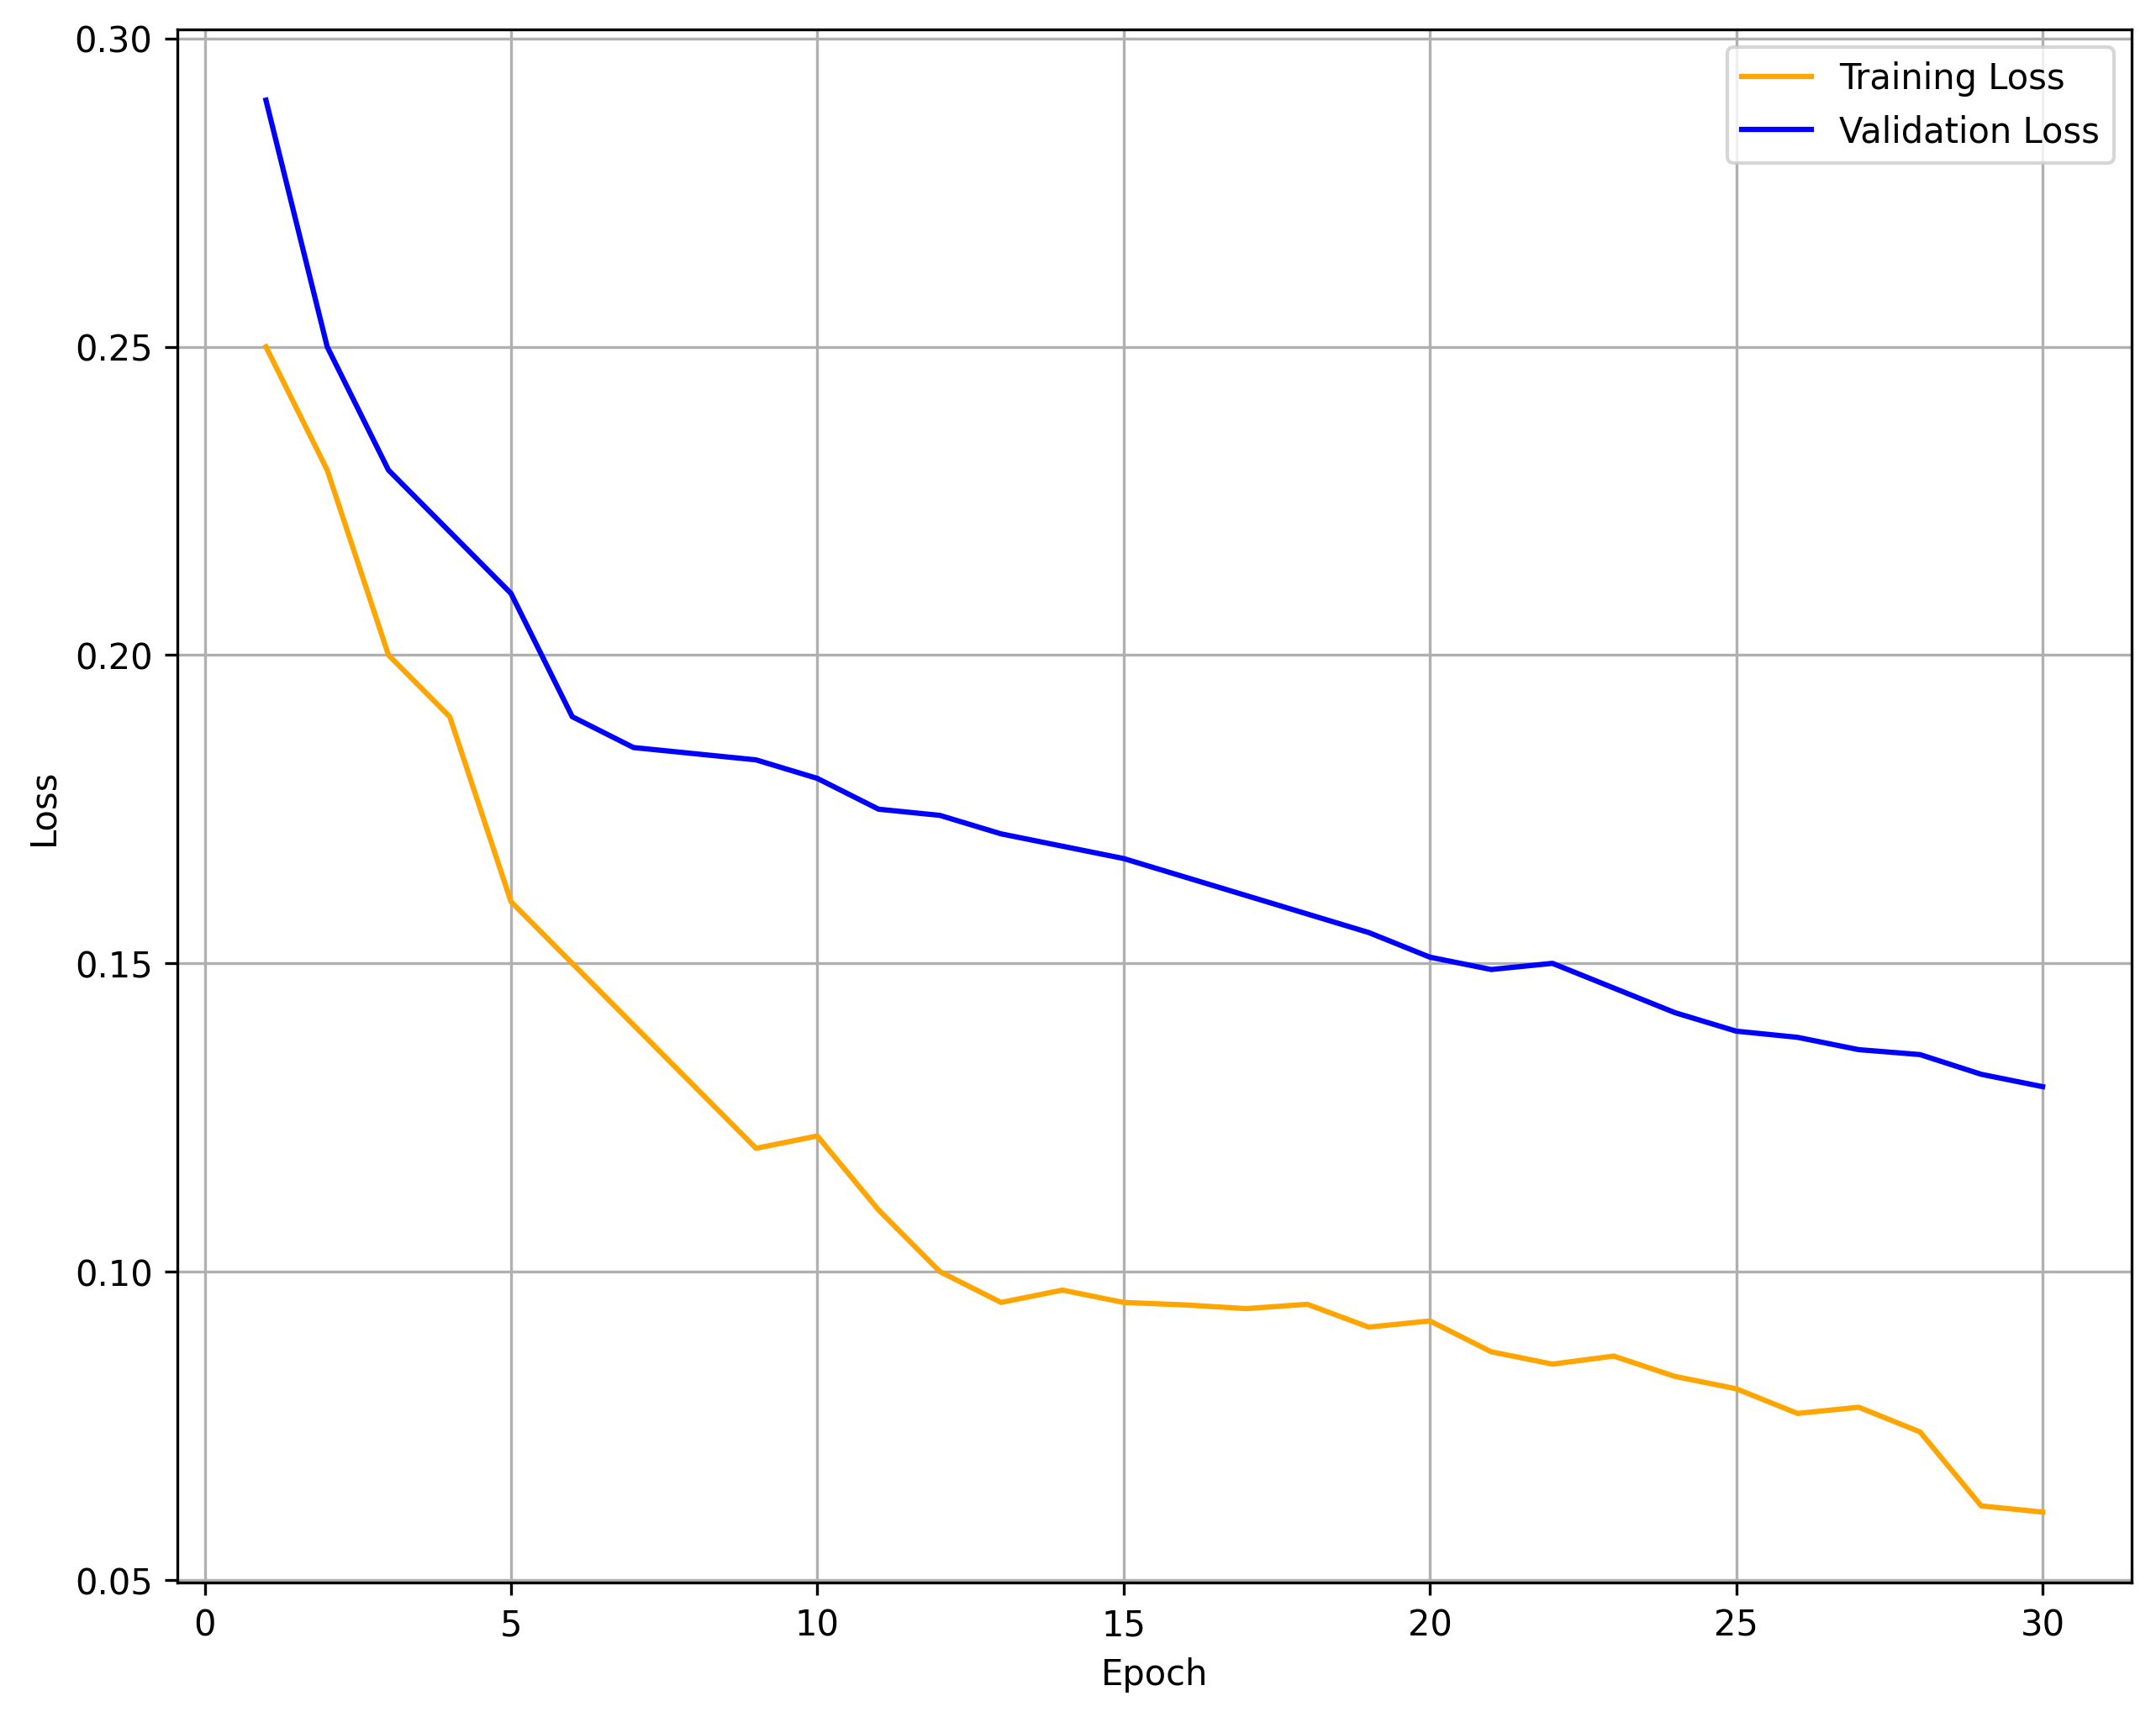

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_acc, val_acc):
    epochs = range(1, len(train_losses) + 1)

    # Plot training & validation loss\
    plt.figure(figsize=(10, 8),dpi=300)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

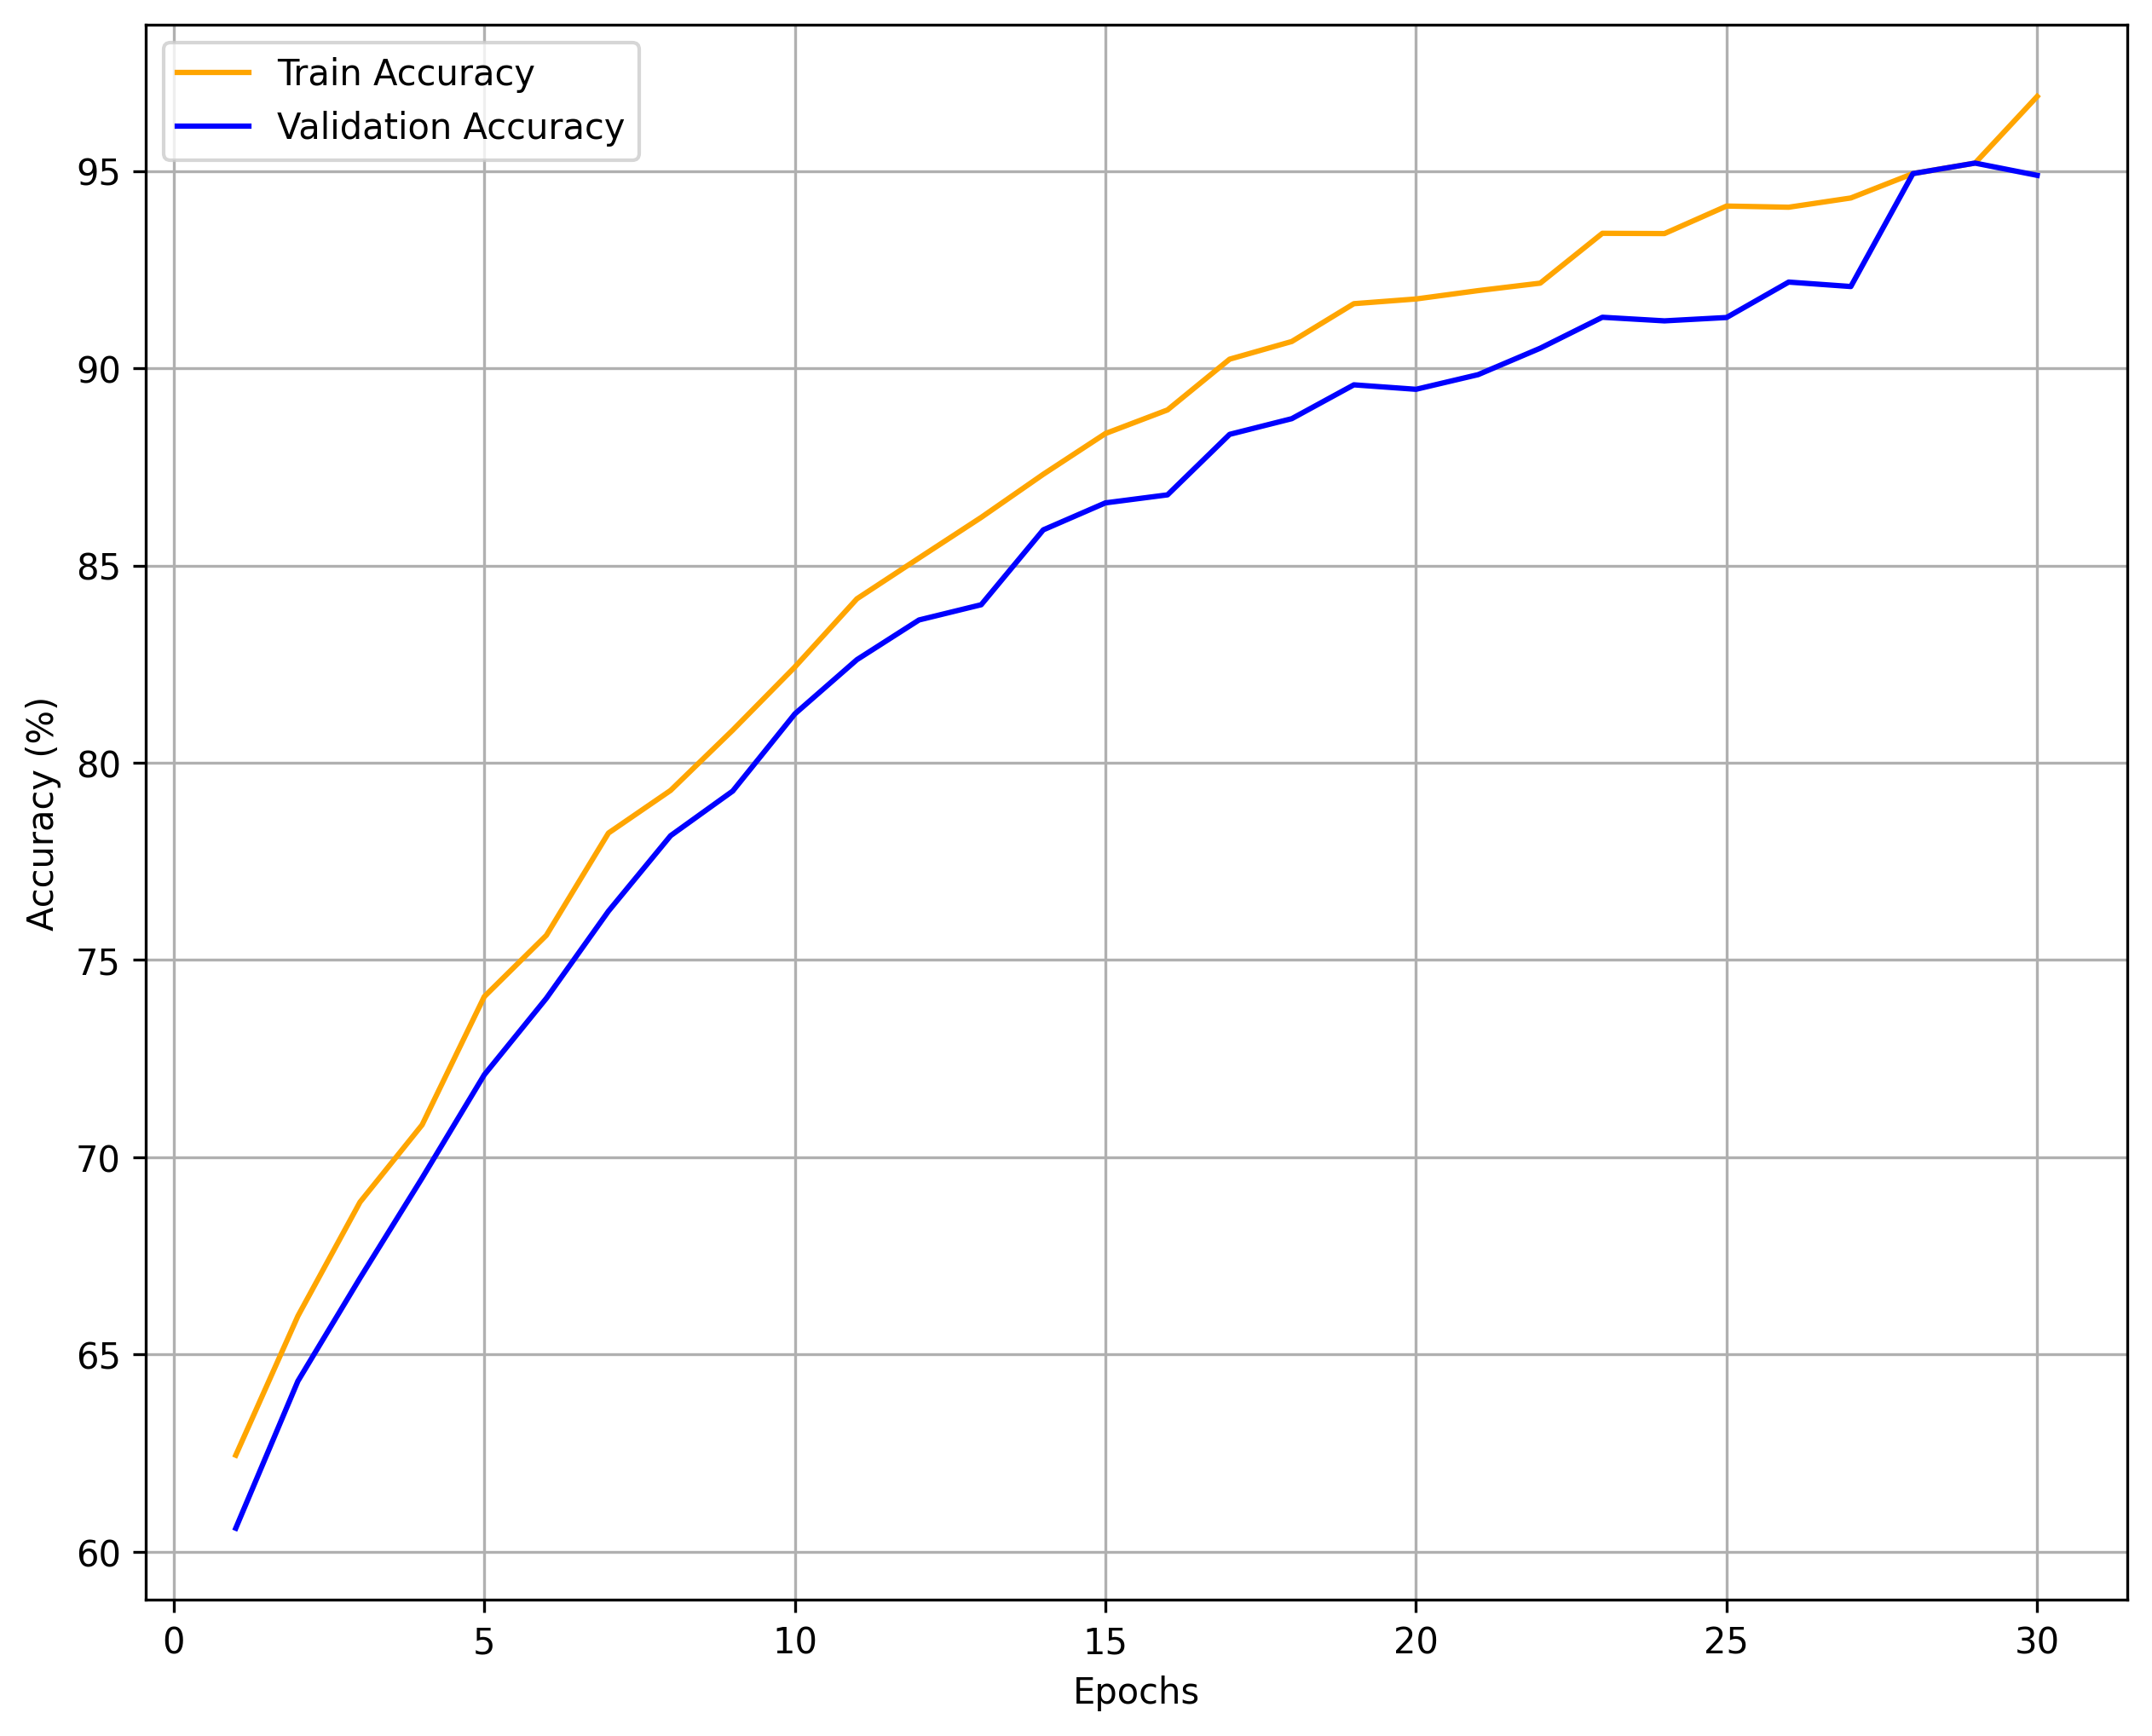

In [34]:
 plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.figure(figsize=(10, 8),dpi=300)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy%')
    plt.legend()
    plt.tight_layout()
    plt.show()


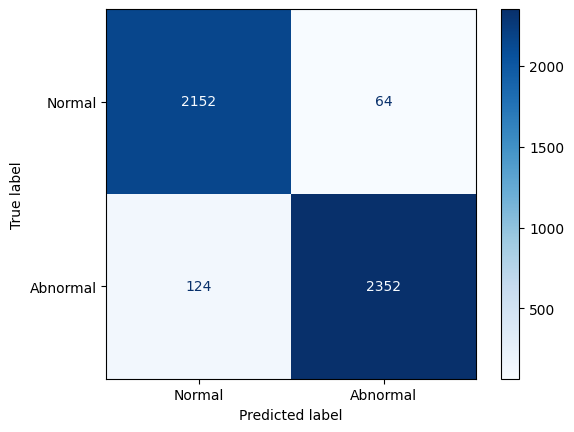

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=["Normal", "Abnormal"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)

plt.show()


In [40]:
import torch
import librosa
import numpy as np


def load_model(model_path, ecg_input_dim, pcg_input_dim, d_model, num_heads, num_layers):
    model = HeartDiseaseDetectionModel(
        ecg_input_dim=ecg_input_dim,
        pcg_input_dim=pcg_input_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


def preprocess_audio(file_path, sample_rate=22050, duration=2, n_mels=64, n_fft=2048, hop_length=512, fixed_length=87):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)
    if len(audio) < sample_rate * duration:
        audio = np.pad(audio, (0, sample_rate * duration - len(audio)))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    if mel_spec_db.shape[1] < fixed_length:
        pad_width = fixed_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :fixed_length]
    return torch.FloatTensor(mel_spec_db).unsqueeze(0).unsqueeze(0)


inputs = {}
inputs['Name'] = input("Enter your name: ")
inputs['Category'] = input("Select category (Child/Adult): ").capitalize()
inputs['Gender'] = input("Select gender (Male/Female): ").capitalize()
inputs['Weight'] = input("Enter your weight (kg): ")
inputs['Height'] = input("Enter your height (cm): ")
locations = input("Select location(s) (AV, TV, MV, PV - separate with commas for multiple): ")
inputs['Location'] = [loc.strip().upper() for loc in locations.split(',')]
inputs['Pregnancy'] = input("Is pregnancy status applicable? (Yes/No): ").capitalize()


model_path = "heart_disease_model.pth"
ecg_input_dim = 87 
pcg_input_dim = 64  
d_model = 128
num_heads = 4
num_layers = 3


model = load_model(model_path, ecg_input_dim, pcg_input_dim, d_model, num_heads, num_layers)


wav_file = input("Enter the path to the .wav file: ")
pcg_input = preprocess_audio(wav_file)


ecg_input = torch.zeros((1, 87, 128))  


with torch.no_grad():
    output = model(ecg_input, pcg_input)
    prediction = torch.argmax(output, dim=1).item()


if prediction == 1:
    result = "According to your ECG or PCG, you are Normal."
else:
    result = "According to your ECG or PCG, you are Abnormal."

print(result)



Enter your name:  saad
Select category (Child/Adult):  Adult
Select gender (Male/Female):  Male
Enter your weight (kg):  78
Enter your height (cm):  109
Select location(s) (AV, TV, MV, PV - separate with commas for multiple):  AV,TV
Is pregnancy status applicable? (Yes/No):  No


Patient file name: 9171.hea
Audio file name: 2553.wav
According to your ECG or PCG, you are Abnormal.
